In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle
import random
import pathlib
import datetime

# from IPython import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.ndimage import gaussian_filter

2024-03-01 13:47:17.351087: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 13:47:20.000686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 13:47:38.733467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from matplotlib import ticker

In [4]:
# strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.MultiWorkerMirroredStrategy()

2024-03-01 13:48:24.086093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6848 MB memory:  -> device: 0, name: Tesla P4, pci bus id: 0000:8a:00.0, compute capability: 6.1
2024-03-01 13:48:24.087575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6848 MB memory:  -> device: 1, name: Tesla P4, pci bus id: 0000:8b:00.0, compute capability: 6.1
2024-03-01 13:48:24.088558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 6848 MB memory:  -> device: 2, name: Tesla P4, pci bus id: 0000:8c:00.0, compute capability: 6.1
2024-03-01 13:48:24.089683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 6848 MB memory:  -> device: 3, name: Tesla P4, pci bus id: 0000:b1:00.0, compute capability: 6.1


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3'), communication = CommunicationImplementation.AUTO


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


In [6]:
plt.rcParams.update({'font.size': 16})

In [7]:
RESULTS_FOLDER = 'results_1_with400'

In [8]:
### Configuration
os.mkdir(RESULTS_FOLDER) if not os.path.isdir(RESULTS_FOLDER) else None
folders = ['all_exp_plots_g', 'all_exp_plots', 'exp_plots', 'model_weights', 'raw_exps', 'training_plots', 'all_val_plots', 'raw_vals',
           'training_plots/train','training_plots/val','training_plots/val_c']
for folder in folders:
    if(not os.path.isdir(f'{RESULTS_FOLDER}/{folder}')):
        os.mkdir(f'{RESULTS_FOLDER}/{folder}')

In [9]:
tf.random.set_seed(seed=20)

In [10]:
### Hyperparameters
# BATCH_SIZE = 128
# EPOCH = 100
# BATCH_SIZE = 32
# EPOCH = 1

In [11]:
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

EPOCHS = 200

In [12]:
BUFFER_SIZE = 90000

In [13]:
import time

### Load dataset 

In [14]:
### Normalization

In [15]:
def add_noise_blur(image, rows=128, cols=128):
    #add random noise
    scale = tf.random.uniform([1], minval = 0.01, maxval = 0.1, dtype = tf.float32 )
    noise = tf.random.normal([rows, cols, 1], mean = 0.0, stddev = 1.0)
    #blur with a random sigma
    # sigmaIn = np.random.uniform(low = 1.0, high = 2.0 )
    sigmaIn = tf.random.uniform(shape=[], minval = 1.0, maxval = 2.0 )
    #image = gaussian_filter(image, sigma = sigmaIn)
    noise = gaussian_filter(noise, sigma = sigmaIn.numpy())
    image *= (1.0 + scale*noise)
    #print("scale %f sigma %f" % (scale, sigmaIn))
    return image

In [16]:
def normalize(dataY):
    max = tf.reduce_max(dataY)
    min = tf.reduce_min(dataY)
    # dataY = dataY / tf.math.abs(min)
    dataY = (dataY - min)/(max - min)
    return dataY

In [17]:
def normalizeTarget(image, bFlag = False):
    image = (image - 1.0) / (5.0)
    if bFlag:
        image = 2.0*image - 1.0
    return image

In [18]:
### EoNormalization

In [19]:
def load(image_file, image_size=(128,128)):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, image_size)
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [20]:
def normalize_val(image, target):
    input_image = add_noise_blur(image)
    return input_image , target

In [21]:
def load_image_train(image_file, target_file):
    input_image = load(image_file)
    target_image = load(target_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [22]:
def load_image_val(image_file, target_file):    
    input_image = load(image_file)
    target_image = load(target_file)
    # input_image = add_noise_blur(image_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [23]:
def check_count(log_path):
    soft = 0
    hard = 0
    for lp in log_path:
        with open(lp) as f:
            data = f.read()
        data = data.split(' ')
        mod = data[9]
        assert mod == 'mod1'
        mod_value = float(data[10].splitlines()[0])
        if mod_value < 1.0:
            soft = soft + 1
        if mod_value > 1.0:
            hard = hard + 1
    return soft, hard

In [24]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [25]:
# input_path = glob.glob('alldata/*TrainData*/*/uY_128x128*.raw')
# target_path = glob.glob('alldata/*TrainData*/*/modulus_128x128*.raw')
# log_path = glob.glob('alldata/*TrainData*/*/logFile.txt')
# input_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
# target_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
# log_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [26]:
# len(input_path), len(target_path), len(log_path)

In [27]:
# input_path = glob.glob('data/TrainData*/*/uY_128x128*.raw')
# target_path = glob.glob('data/TrainData*/*/modulus_128x128*.raw')

In [28]:
# len(input_path), len(target_path), len(log_path)

In [29]:
# input_path[0:8]

In [30]:
# target_path[0:8]

In [31]:
# input_image = load(input_path[0:8][0])
# target_image = load(target_path[0:8][0])

In [32]:
# plt.imshow(input_image, cmap='gray')

In [33]:
# plt.imshow(target_image, cmap='gray')

In [34]:
# t_image = target_image[:,:,0]
# t_image.shape

In [35]:
# top_row = t_image[0, :]
# bottom_row = t_image[-1, :]
# left_column = t_image[:, 0]
# right_column = t_image[:, -1]

In [36]:
# right_column

In [37]:
# bottom_row

In [38]:
# input_image = load(image_file)
# target_image = load(target_file)
# input_image = normalize(input_image)

In [39]:
# check_count(log_path)

In [40]:
input_val_path = glob.glob('alldata/*ValData*/*/uY_128x128*.raw')
target_val_path = glob.glob('alldata/*ValData*/*/modulus_128x128*.raw')
log_val_path = glob.glob('alldata/*ValData*/*/logFile.txt')
input_val_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
target_val_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))
log_val_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [41]:
len(input_val_path), len(target_val_path), len(log_val_path)

(25000, 25000, 3000)

In [42]:
# check_count(log_val_path)

In [43]:
# # train_dataset
# train_dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
# train_dataset = train_dataset.map(load_image_train)
# train_dataset = train_dataset.shuffle(buffer_size=len(input_path)) 
# # train_dataset = train_dataset.shuffle(buffer_size=1000) 
# train_dataset = train_dataset.batch(GLOBAL_BATCH_SIZE)

In [44]:
# len(train_dataset)

In [45]:
# train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

In [46]:
# train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(train_dataset, len(train_dataset))
# print(len(train_dataset), len(val_dataset), len(test_dataset))

In [47]:
## val_dataset
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(GLOBAL_BATCH_SIZE)

In [48]:
val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)

2024-03-01 13:48:27.561987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25000]
	 [[{{node Placeholder/_0}}]]
2024-03-01 13:48:27.562278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [25000]
	 [[{{node Placeholder/_1}}]]
2024-03-01 13:48:27.563777: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"

In [49]:
# for x in val_dataset:
#     print(x[0].shape)
#     break

In [50]:
# # print(len(dataset))
# print(len(train_dataset))
# print(len(val_dataset))
# # print(len(test_dataset))

In [51]:
a = next(iter(val_dataset))
print(len(a))
print(a[0].shape)
print(a[1].shape)

2024-03-01 13:48:27.664482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [25000]
	 [[{{node Placeholder/_1}}]]


2
(128, 128, 128, 1)
(128, 128, 128, 1)


In [52]:
inp, re = a[0][0], a[1][0]

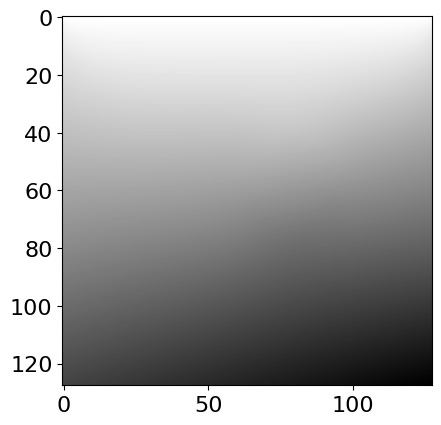

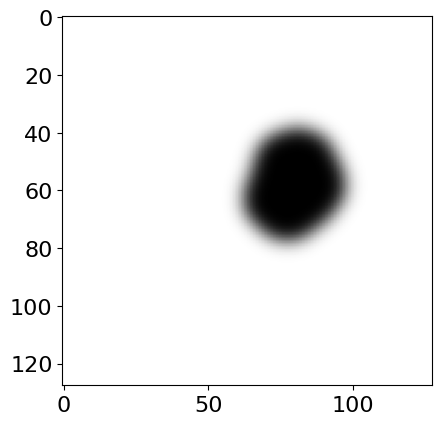

In [53]:
plt.figure()
plt.imshow(inp, cmap='gray')
plt.figure()
plt.imshow(re, cmap='gray')

In [54]:
len(val_dataset)

196

In [55]:
# val_dataset = val_dataset.batch(1)

In [56]:
len(val_dataset)

196

In [57]:
inp.shape

TensorShape([128, 128, 1])

### Generator Model

In [58]:
OUTPUT_CHANNELS = 1

In [59]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [60]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2024-03-01 13:48:33.886101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2024-03-01 13:48:34.913692: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned 32512
2024-03-01 13:48:34.948827: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(1, 64, 64, 3)


In [61]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [62]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [63]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    # down_stack = [
    #     downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    #     downsample(128, 3),  # (batch_size, 64, 64, 128)
    #     downsample(256, 3),  # (batch_size, 32, 32, 256)
    #     downsample(512, 3),  # (batch_size, 16, 16, 512)
    #     downsample(512, 3),  # (batch_size, 8, 8, 512)
    #     downsample(512, 3),  # (batch_size, 4, 4, 512)
    #     downsample(512, 3),  # (batch_size, 2, 2, 512)
    #     # downsample(512, 4),  # (batch_size, 1, 1, 512)
    # ]
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # up_stack = [
    #     # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #     upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #     upsample(512, 3, apply_dropout=False),  # (batch_size, 8, 8, 1024)
    #     upsample(512, 3),  # (batch_size, 16, 16, 1024)
    #     upsample(256, 3),  # (batch_size, 32, 32, 512)
    #     upsample(128, 3),  # (batch_size, 64, 64, 256)
    #     upsample(64, 3),  # (batch_size, 128, 128, 128)
    # ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        # upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # x = last(x)
    # x = 1.0 + (10.0 - 1.0)*x 

    upsampling = tf.keras.layers.UpSampling2D(size=2, interpolation = 'bilinear')
    # last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')
    last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    multiply = tf.keras.layers.Lambda(lambda x: 0.1 + (5.0 - 0.1)*x)
    
    x = upsampling(x)
    x = last_conv(x)
    x = multiply(x)
    
    # x = 0.1 + (10.0 - 0.1)*x
    # this one for both!

    return tf.keras.Model(inputs=inputs, outputs=x)

In [64]:
# Visualizing generator architecture
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

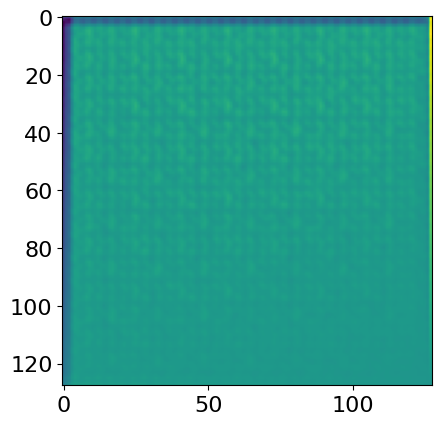

In [65]:
# Testing the generator
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [66]:
# gen_output[0]

In [67]:
gen_output.shape

TensorShape([1, 128, 128, 1])

In [68]:
with strategy.scope():
    generator = Generator()

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce te

In [69]:
# Generator loss
LAMBDA = 100
loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
loss_tracker = tf.keras.metrics.MeanSquaredError(name='train_mse')
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name='val_mse')

In [70]:
with strategy.scope():
    loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    def generator_loss(gen_output, target):
        #Possible addition: regularizer
        # gan_loss = loss_object(gen_output, target)
        # return gan_loss
        per_example_loss = loss_object(gen_output, target)
        loss = tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)
        return loss

In [71]:
with strategy.scope():
    # loss_tracker = tf.keras.metrics.Mean(name="train_loss")
    # val_loss_tracker = tf.keras.metrics.Mean(name="val_loss")
    # val_loss_mean = tf.keras.metrics.Mean(name='val_loss_mean')
    loss_tracker = tf.keras.metrics.MeanSquaredError(name='train_mse')
    val_loss_tracker = tf.keras.metrics.MeanSquaredError(name='val_mse')

In [72]:
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='results/model.png')

In [73]:
generator_loss(gen_output, re[tf.newaxis,...])

<tf.Tensor: shape=(), dtype=float32, numpy=316.64645>

In [74]:
re[tf.newaxis,...].shape

TensorShape([1, 128, 128, 1])

In [75]:
gen_output.shape

TensorShape([1, 128, 128, 1])

### Optimizers and checkpoints

In [76]:
# generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [77]:
checkpoint_dir = f'{RESULTS_FOLDER}/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [78]:
with strategy.scope():
    generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     generator=generator,
                                    )

In [79]:
class MidPointLogNorm(mcolors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

In [80]:
def generate_images(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=False)
    display_list = [test_input[0], tar[0], prediction[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted {mse_loss:.2f} {mape_loss:.2f}%']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.colorbar(location='bottom')
        plt.axis('off')
    plt.savefig(f'{RESULTS_FOLDER}/training_plots/{epoch}-{step}.png')
    plt.close()

In [81]:
plt.tight_layout()
def generate_images8(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=False)
    x = prediction.numpy()
    # if np.amax(x) > 1.0:
    #     x[x < 1.0] = 1.0
    # else:
    #     x[x > 1.0] = 1.0

    display_list = [test_input[0], tar[0], x[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='bwr')
            plt.colorbar(location='bottom',pad=0.1)
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.colorbar(location='bottom',pad=0.1)
        plt.axis('on')
    plt.savefig(f'{RESULTS_FOLDER}/training_plots/{epoch}-{step}.png', bbox_inches='tight')
    plt.close()

    # plt.imshow(target[i][0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # plt.colorbar(location='bottom', pad=0.05)
    # plt.suptitle('Modulus distribution', x=0.5, y = 0.48, fontsize=15)

<Figure size 640x480 with 0 Axes>

In [82]:
for example_input, example_target in val_dataset.take(1):
    generate_images8(generator, example_input, example_target,6,6)

2024-03-01 13:48:41.034195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [25000]
	 [[{{node Placeholder/_1}}]]
2024-03-01 13:48:43.593768: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 7.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-01 13:48:44.568375: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [83]:
# for i, (example_input, example_target) in enumerate(val_dataset.take(1000)):
#     if i+1 == 49 or i+1 == 174:
#         generate_images8(generator, example_input, example_target,i+1,i+1)

### Training

In [82]:
MODEL_PATH = f"{RESULTS_FOLDER}/model_weights/mse_model"
BEST_PATH = f"{RESULTS_FOLDER}/model_weights/best_mse_model"

In [82]:
log_dir=f"{RESULTS_FOLDER}/logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
gen_total_loss_list = []
gen_val_loss_list = []

In [83]:
# @tf.function
def train_step(inputs):
    input_image, target = inputs
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        gen_total_loss = generator_loss(gen_output, target)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    loss_tracker.update_state(gen_output, target)
    return gen_total_loss

     # gen_total_loss_list.append(gen_total_loss.numpy())
    # print(f'Result:{loss_tracker.result()}')

    # with summary_writer.as_default():
    #     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)

In [84]:
# @tf.function
def val_step(inputs):
    input_image, target = inputs
    gen_output = generator(input_image, training=False)
    # v_loss = loss_object(gen_output, target)
    # val_loss_mean.update_state(v_loss)
    val_loss_tracker.update_state(gen_output, target)
    
    # gen_val_loss = generator_loss(gen_output, target)
    # gen_val_loss_list.append(gen_val_loss)
    # val_loss_tracker.update_state(gen_val_loss)

    # print(gen_val_loss)

In [85]:
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

In [86]:
@tf.function
def distributed_val_step(dataset_inputs):
    return strategy.run(val_step, args=(dataset_inputs,))

In [87]:
min_val_loss = 100000;

In [88]:
# epoch_wise_train_loss = []
# epoch_wise_val_loss = []

In [89]:
# for x in train_dataset:
#     total_loss = distributed_train_step(x)
#     break

In [ ]:
# total_loss

In [ ]:
# for x in val_dataset:
#     total_loss = distributed_val_step(x)
#     break

In [ ]:
# total_loss

In [ ]:
# val_loss_mean.result()

In [ ]:
def fit(train_ds, val_ds, epochs, steps=1):
    # example_input, example_target = next(iter(train_ds.take(1)))
    # example_input, example_target = inp, re
    start = time.time()
    min_val_loss = 1000
    
    for epoch in range(epochs):
        print("Iniside loop")
        total_loss = 0.0
        num_batches = 0
        for x in train_ds:
            total_loss += distributed_train_step(x)
            num_batches += 1
        train_loss = total_loss / num_batches
        print("training complete")
        for x in val_ds:
            distributed_val_step(x)
        print("val complete")
        if epoch % 10 == 0:
            checkpoint.save(checkpoint_prefix)
            generate_images(generator, inp[tf.newaxis,...], re[tf.newaxis,...], f'train/train-{epoch}', 10)
            with open(f'{RESULTS_FOLDER}/epoch.txt','a') as f:
                f.write(f"{epoch} epoch: took {time.time()-start:.2f} sec")
                f.write('\n')
                
        ## Save best model
        current_loss = val_loss_tracker.result().numpy()
        # current_loss = val_loss_mean.result().numpy()
        print("current loss",current_loss)
        print("Min vall loss",min_val_loss)
        if(current_loss < min_val_loss and epoch > 0):
            min_val_loss = current_loss
            generator.save_weights(BEST_PATH)
            print(f"Saving best weight with val loss:{min_val_loss} to {BEST_PATH}")

        epoch_wise_train_loss.append(loss_tracker.result().numpy())
        epoch_wise_val_loss.append(val_loss_tracker.result().numpy())
        
        loss_tracker.reset_states()
        val_loss_tracker.reset_states()
        # val_loss_mean.reset_states()
    
    generator.save_weights(MODEL_PATH)
    print(f'\nModel saved to: {MODEL_PATH}')
    print('min_val_loss',min_val_loss)
    with open(f'{RESULTS_FOLDER}/epoch.txt','a') as f:
        f.write(f"{epoch} epoch: took {time.time()-start:.2f} sec")
        f.write('\n')
        f.write(f'min_val_loss:{min_val_loss}')


        # if (epoch) % 10 == 0:
        #     # display.clear_output(wait=True)
        #     if epoch != 0:
        #         print(f'Time taken for 10 epochs: {time.time()-start:.2f} sec\n')
        #     start = time.time()
        #     generate_images(generator, example_input, example_target, f'train/train-{epoch}', step)
        #     print(f"Reached epoch: {epoch}")
        #     with open(f'{RESULTS_FOLDER}/epoch.txt','w') as f:
        #         f.write("\n")
        #         f.write(str(epoch))
        #     # generate_images(generator, exp_img, epoch, step)    

        # # Save (checkpoint) the model every 25 EPOCH
        # if (epoch)%25 == 0:
        #     print(f"Saving checkpoint at epoch:{epoch}")
        #     checkpoint.save(file_prefix=checkpoint_prefix)
        #     print(f"Step: {step}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        
        # print(f"Epoch: {epoch}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        # epoch_wise_train_loss.append(loss_tracker.result())
        # epoch_wise_val_loss.append(val_loss_tracker.result())
        # loss_tracker.reset_states()
        # val_loss_tracker.reset_states()
        # val_loss_mean.reset_states()
          
    # generator.save_weights(MODEL_PATH)
    # print(f'\nModel saved to: {MODEL_PATH}')
    # print('min_val_loss',min_val_loss)
    # with open(f'{RESULTS_FOLDER}/loss.txt','w') as f:
    #     f.write(str(min_val_loss))
    #     f.write("epoch")
    #     f.write(str(epoch))

In [ ]:
# total_loss = 0.0
# num_batches = 0
# for x in train_dist_dataset:
#     total_loss += distributed_train_step(x)
#     num_batches += 1
#     break
#     # print(num_batches)

In [ ]:
# total_loss

In [ ]:
# for x in val_dist_dataset:
#     distributed_val_step(x)
#     break

In [ ]:
# fit(train_dist_dataset,val_dist_dataset, epochs=EPOCHS)

In [ ]:
# a = next(iter(strategy.experimental_distribute_dataset(train_dataset)))

In [ ]:
# len(gen_total_loss_list)

In [ ]:
# len(gen_val_loss_list)

In [ ]:
# # plt.figure(figsize=(20, 15))
# plt.plot(gen_total_loss_list, label='train')
# plt.plot(gen_val_loss_list, label='val')
# plt.title("Training curve")
# plt.xlabel("Steps")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.savefig(f'{RESULTS_FOLDER}/train_val_curve.png')
# plt.show()


In [103]:
# l1 = len(epoch_wise_train_loss)
# l2 = len(epoch_wise_val_loss)
# print(l1)
# print(l2)
# a = range(1,l1+1)
# b = range(1,l2+1)

In [104]:
# plt.figure(figsize=(15,5))
# plt.plot(a, epoch_wise_train_loss, label='train', linewidth=7.0)
# plt.plot(a, epoch_wise_val_loss, label='val', linewidth=7.0)
# plt.title("Training curve")
# plt.xlabel("Epochs")
# plt.ylabel("MSE Loss")
# plt.legend()
# # plt.savefig(f'{RESULTS_FOLDER}/train_val_epoch_curve.png')
# plt.show()

In [105]:
# with open(f"{}/epoch_wise_train_loss", "wb") as fp:   
#     pickle.dump(epoch_wise_train_loss, fp)
# with open("epoch_wise_val_loss", "wb") as fp:   
#     pickle.dump(epoch_wise_val_loss, fp)

In [106]:
# print(f'Train MSE at the end of training: {gen_total_loss_list[-1]}')
# print(f'Val MSE at the end of training: {gen_val_loss_list[-1]}')

### Testing

### Testing

In [ ]:
MODEL_PATH = f"{RESULTS_FOLDER}/model_weights/mse_model"
BEST_PATH = f"{RESULTS_FOLDER}/model_weights/best_mse_model"

In [ ]:
generator.load_weights(BEST_PATH)

In [89]:
len(val_dataset)

196

In [90]:
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(1)

In [91]:
len(val_dataset)

25000

In [92]:
from skimage import filters

In [93]:
def display_otsus(extracted_mod_img):
    numpy_data = extracted_mod_img[:,:,0].numpy()
    val = filters.threshold_otsu(numpy_data)
    thresholded_img = numpy_data > val
    return thresholded_img

In [94]:
def display_otsus2(extracted_mod_img):
    numpy_data = extracted_mod_img[:,:,0].numpy()
    val = filters.threshold_otsu(numpy_data)
    thresholded_img = numpy_data > val
    return thresholded_img,val

In [95]:
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [96]:
def avg_modulus(taget_or_pred, val):
    mod_at_each_point_soft = taget_or_pred[taget_or_pred < val]
    avg_mod_soft = tf.reduce_mean(mod_at_each_point_soft).numpy()
    mod_at_each_point_hard = taget_or_pred[taget_or_pred > val]
    avg_mod_hard = tf.reduce_mean(mod_at_each_point_hard).numpy()
    return avg_mod_soft, avg_mod_hard, mod_at_each_point_soft, mod_at_each_point_hard

In [97]:
def calculate_obj_mse(predicted_mod_img, thresholded_pred_mod, extracted_mod_img, thresholded_gt_mod):
    both_thresholded = np.logical_or(thresholded_pred_mod,thresholded_gt_mod)
    valued = predicted_mod_img.numpy().squeeze()
    numpy_data = extracted_mod_img.numpy().squeeze()
    assert both_thresholded.shape == valued.shape == numpy_data.shape
    ip = valued[both_thresholded]
    op = numpy_data[both_thresholded]
    mse_score_hard = np.mean(np.square(ip-op))
    
    ip = valued[np.logical_not(both_thresholded)]
    op = numpy_data[np.logical_not(both_thresholded)]
    mse_score_soft = np.mean(np.square(ip-op))
    return mse_score_hard, mse_score_soft

In [98]:
# with open(f'{RESULTS_FOLDER}/analysis.csv','w') as f:
#     f.write(f'index,mse,nmse,mape,dice, avg_mod_hard_gt,avg_mod_hard_pred,avg_mod_soft_gt, avg_mod_soft_pred,mod_err_hard,rel_mod_err_hard,mod_err_soft,rel_mod_err_soft,hard_obj_mse,soft_obj_mse\n')

In [ ]:
# avg_mse_loss_list = []
# avg_mape_loss_list = []
# list_dice_scores = []

In [ ]:
# i = 0
# for test_image,test_target in val_dataset:
    
#     test_prediction = generator(test_image,training=False)
#     test_target = test_target
#     mse_loss = tf.keras.metrics.mean_squared_error(test_target, test_prediction)
#     avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()
#     avg_mse_loss_list.append(avg_mse_loss)

#     mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(test_target, test_prediction)
#     avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()
#     avg_mape_loss_list.append(avg_mape_loss)

#     thresholded_pred_mod, value_pred = display_otsus2(test_prediction[0])
#     thresholded_gt_mod, value_gt = display_otsus2(test_target[0])
#     dice_score = dice(thresholded_pred_mod, thresholded_gt_mod, k = 1) 
#     list_dice_scores.append(dice_score)

#     avg_mod_soft_pred, avg_mod_hard_pred, mod_aep_soft_pred, mod_aep_hard_pred = avg_modulus(test_prediction[0], value_pred)
#     avg_mod_soft_gt, avg_mod_hard_gt, mod_aep_soft_gt, mod_aep_hard_gt = avg_modulus(test_target[0], value_gt)


#     nmse_denominator = tf.math.reduce_mean(tf.keras.metrics.mean_squared_error(test_target, 0.0)).numpy()
#     nmse = avg_mse_loss/nmse_denominator

#     mod_err_hard = abs(avg_mod_hard_gt - avg_mod_hard_pred)
#     rel_mod_err_hard = mod_err_hard/avg_mod_hard_gt

#     mod_err_soft = abs(avg_mod_soft_gt - avg_mod_soft_pred)
#     rel_mod_err_soft = mod_err_soft/avg_mod_soft_gt

#     mse_score_hard, mse_score_soft = calculate_obj_mse(test_prediction[0], thresholded_pred_mod, test_target[0], thresholded_gt_mod)    
    
    
#     i = i+1
#     with open(f'{RESULTS_FOLDER}/analysis.csv','a') as f:
#         f.write(f'{i},{avg_mse_loss},{nmse},{avg_mape_loss},{dice_score},{avg_mod_hard_gt},{avg_mod_hard_pred},{avg_mod_soft_gt},{avg_mod_soft_pred},{mod_err_hard},{rel_mod_err_hard},{mod_err_soft},{rel_mod_err_soft},{mse_score_hard},{mse_score_soft}\n')   

#     # if i == 2:
#     #     break

#     # output = np.reshape(test_prediction, (128,128))
#     # gt = np.reshape(test_target, (128,128))
#     # i = i+1

#     # file_name = f"{RESULTS_FOLDER}/raw_vals/{i}-pred.raw"
#     # with open(file_name, 'wb') as fp:     
#     #     output.tofile(fp)
#     # fp.close()

#     # file_name2 = f"{RESULTS_FOLDER}/raw_vals/{i}-gt.raw"
#     # with open(file_name2, 'wb') as fp:     
#     #     gt.tofile(fp)
#     # fp.close()

In [120]:
# final_mse = sum(avg_mse_loss_list)/len(avg_mse_loss_list)
# with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
#     f.write(f'\nFinal_MSE:{final_mse}')
# final_mse

In [121]:
# len(avg_mape_loss_list)

In [122]:
# final_mape = sum(avg_mape_loss_list)/len(avg_mape_loss_list)
# with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
#     f.write(f'\nFinal_MAPE:{final_mape}')
# final_mape

In [123]:
# len(list_dice_scores)

In [124]:
# final_dice = sum(list_dice_scores)/len(list_dice_scores)
# with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
#     f.write(f'\nFinal Dice:{final_dice}')
# final_dice

### Post - analysis

In [196]:
import pandas as pd

In [197]:
names = 'index,mse,nmse,mape,dice,avg_mod_hard_gt,avg_mod_hard_pred,avg_mod_soft_gt,avg_mod_soft_pred,mod_err_hard,rel_mod_err_hard,mod_err_soft,rel_mod_err_soft,hard_obj_mse,soft_obj_mse'

In [198]:
names = names.split(',')

In [199]:
df = pd.read_csv(f'{RESULTS_FOLDER}/analysis.csv',sep=",", header = 0, names=names)

In [200]:
df.head()

index       mse      nmse      mape      dice  avg_mod_hard_gt  \
0      1  0.000005  0.000005  0.177115  0.999510         0.997567   
1      2  0.000059  0.000054  0.317940  0.994619         1.469937   
2      3  0.000591  0.000300  0.388214  0.997340         3.835108   
3      4  0.000059  0.000034  0.246662  0.995486         3.205012   
4      5  0.000132  0.000063  0.303686  0.998549         3.652843   

   avg_mod_hard_pred  avg_mod_soft_gt  avg_mod_soft_pred  mod_err_hard  \
0           0.998923         0.744511           0.746311      0.001356   
1           1.490860         1.003120           1.005118      0.020924   
2           3.855762         1.008709           1.009683      0.020655   
3           3.214258         1.022685           1.024147      0.009246   
4           3.667607         1.019109           1.020727      0.014764   

   rel_mod_err_hard  mod_err_soft  rel_mod_err_soft  hard_obj_mse  \
0          0.001359      0.001800          0.002417      0.000004   
1          0.014234      0.001998          0.001992      0.000637   
2          0.005386      0.000974          0.000966      0.006258   
3          0.002885      0.001462          0.001430      0.000555   
4          0.004042      0.001617          0.001587      0.001135   

   soft_obj_mse  
0      0.000023  
1      0.000016  
2      0.000170  
3      0.000019  
4      0.000040

In [201]:
df.shape

(25000, 15)

In [202]:
inclusion = []
for a_log_path in log_val_path:
    with open(a_log_path) as f:
        data = f.read()
    data = data.split(' ')
    mod = data[9]
    assert mod == 'mod1'
    foreground = float(data[10].splitlines()[0])
    if foreground < 1.0:
        inclusion.append('soft')
    elif foreground > 1.0:
        inclusion.append('hard')
    else:
        print('error')

In [203]:
len(inclusion)

3000

In [204]:
s1 = inclusion[0:1000]
s2 = inclusion[1000:2000]
s2_updated = list(np.repeat(s2,8))
s3 = inclusion[2000:3000]
s3_updated = list(np.repeat(s3,16))
inclusion = s1 + s2_updated + s3_updated

In [205]:
len(inclusion)

25000

In [206]:
df['inclusion'] = inclusion

In [207]:
df['inclusion']

0        soft
1        hard
2        hard
3        hard
4        hard
         ... 
24995    hard
24996    hard
24997    hard
24998    hard
24999    hard
Name: inclusion, Length: 25000, dtype: object

In [208]:
df.head(6)

index       mse      nmse      mape      dice  avg_mod_hard_gt  \
0      1  0.000005  0.000005  0.177115  0.999510         0.997567   
1      2  0.000059  0.000054  0.317940  0.994619         1.469937   
2      3  0.000591  0.000300  0.388214  0.997340         3.835108   
3      4  0.000059  0.000034  0.246662  0.995486         3.205012   
4      5  0.000132  0.000063  0.303686  0.998549         3.652843   
5      6  0.000385  0.000428  1.922595  0.998440         0.997148   

   avg_mod_hard_pred  avg_mod_soft_gt  avg_mod_soft_pred  mod_err_hard  \
0           0.998923         0.744511           0.746311      0.001356   
1           1.490860         1.003120           1.005118      0.020924   
2           3.855762         1.008709           1.009683      0.020655   
3           3.214258         1.022685           1.024147      0.009246   
4           3.667607         1.019109           1.020727      0.014764   
5           0.999696         0.120360           0.146425      0.002548   

   rel_mod_err_hard  mod_err_soft  rel_mod_err_soft  hard_obj_mse  \
0          0.001359      0.001800          0.002417      0.000004   
1          0.014234      0.001998          0.001992      0.000637   
2          0.005386      0.000974          0.000966      0.006258   
3          0.002885      0.001462          0.001430      0.000555   
4          0.004042      0.001617          0.001587      0.001135   
5          0.002555      0.026065          0.216556      0.000363   

   soft_obj_mse inclusion  
0      0.000023      soft  
1      0.000016      hard  
2      0.000170      hard  
3      0.000019      hard  
4      0.000040      hard  
5      0.000583      soft

In [209]:
df_soft = df[df['inclusion']=='soft']

In [210]:
df_hard = df[df['inclusion']=='hard']

In [211]:
df_hard['mape'] = df_hard['mape']
df_soft['mape'] = df_soft['mape']

In [212]:
df_soft.shape

(12735, 16)

In [213]:
df_hard.shape

(12265, 16)

In [214]:
# df

In [215]:
# df_soft

In [216]:
# df_hard

In [217]:
df_hard = df_hard.drop(columns=['inclusion'])

In [218]:
df_hard.mean()

index                12589.233102
mse                      0.000413
nmse                     0.000222
mape                     0.292849
dice                     0.852085
avg_mod_hard_gt          2.734836
avg_mod_hard_pred        2.502704
avg_mod_soft_gt          1.010533
avg_mod_soft_pred        1.010535
mod_err_hard             0.037478
rel_mod_err_hard         0.013441
mod_err_soft             0.001489
rel_mod_err_soft         0.001477
hard_obj_mse             0.009138
soft_obj_mse             0.000074
dtype: float64

In [219]:
df_hard.max()

index                25000.000000
mse                      0.012205
nmse                     0.005500
mape                     1.189531
dice                     1.000000
avg_mod_hard_gt          4.901711
avg_mod_hard_pred        4.855330
avg_mod_soft_gt          1.068278
avg_mod_soft_pred        1.069587
mod_err_hard             2.200212
rel_mod_err_hard         0.650569
mod_err_soft             0.026864
rel_mod_err_soft         0.026862
hard_obj_mse             2.295625
soft_obj_mse             0.002005
dtype: float64

In [220]:
df_hard.std()

index                7235.023264
mse                     0.000780
nmse                    0.000367
mape                    0.127754
dice                    0.339217
avg_mod_hard_gt         1.059920
avg_mod_hard_pred       1.129174
avg_mod_soft_gt         0.012202
avg_mod_soft_pred       0.011823
mod_err_hard            0.073842
rel_mod_err_hard        0.026895
mod_err_soft            0.000879
rel_mod_err_soft        0.000878
hard_obj_mse            0.054308
soft_obj_mse            0.000138
dtype: float64

In [221]:
df_soft = df_soft.drop(columns=['inclusion'])

In [222]:
df_soft.mean()

index                12415.041696
mse                      0.000046
nmse                     0.000049
mape                     0.352986
dice                     0.856594
avg_mod_hard_gt          0.997342
avg_mod_hard_pred        0.999293
avg_mod_soft_gt          0.573110
avg_mod_soft_pred        0.634598
mod_err_hard             0.001479
rel_mod_err_hard         0.001483
mod_err_soft             0.009820
rel_mod_err_soft         0.024891
hard_obj_mse             0.000034
soft_obj_mse             0.000755
dtype: float64

In [223]:
df_soft.std()

index                7198.894109
mse                     0.000077
nmse                    0.000085
mape                    0.290363
dice                    0.342661
avg_mod_hard_gt         0.002597
avg_mod_hard_pred       0.002858
avg_mod_soft_gt         0.231297
avg_mod_soft_pred       0.257818
mod_err_hard            0.000689
rel_mod_err_hard        0.000690
mod_err_soft            0.025319
rel_mod_err_soft        0.075640
hard_obj_mse            0.000069
soft_obj_mse            0.005028
dtype: float64

In [224]:
df_soft.min()

index                1.000000e+00
mse                  2.414387e-06
nmse                 2.414386e-06
mape                 1.284138e-01
dice                 0.000000e+00
avg_mod_hard_gt      9.845751e-01
avg_mod_hard_pred    9.860791e-01
avg_mod_soft_gt      1.042571e-01
avg_mod_soft_pred    1.358417e-01
mod_err_hard         1.251698e-06
rel_mod_err_hard     1.255434e-06
mod_err_soft         7.748604e-07
rel_mod_err_soft     1.513742e-06
hard_obj_mse         2.404527e-06
soft_obj_mse         2.164243e-07
dtype: float64

In [227]:
### EOF - Analysis

In [139]:
generator.load_weights(BEST_PATH)

In [140]:
len(val_dataset)

36

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(1)

In [122]:
avg_mse_loss_list = []
avg_mape_loss_list = []

i = 0
for test_image,test_target in val_dataset:
    test_prediction = generator(test_image,training=False)
    test_target = test_target
    mse_loss = tf.keras.metrics.mean_squared_error(test_target, test_prediction)
    avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()
    avg_mse_loss_list.append(avg_mse_loss)

    mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(test_target, test_prediction)
    avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()
    avg_mape_loss_list.append(avg_mape_loss)

    output = np.reshape(test_prediction, (128,128))
    gt = np.reshape(test_target, (128,128))
    i = i+1

    file_name = f"{RESULTS_FOLDER}/raw_vals/{i}-pred.raw"
    with open(file_name, 'wb') as fp:     
        output.tofile(fp)
    fp.close()

    file_name2 = f"{RESULTS_FOLDER}/raw_vals/{i}-gt.raw"
    with open(file_name2, 'wb') as fp:     
        gt.tofile(fp)
    fp.close()

In [123]:
len(avg_mse_loss_list)

In [124]:
final_mse = sum(avg_mse_loss_list)/len(avg_mse_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MSE:{final_mse}')
final_mse

In [125]:
len(avg_mape_loss_list)

In [126]:
final_mape = sum(avg_mape_loss_list)/len(avg_mape_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MAPE:{final_mape}')
final_mape

In [128]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images(generator, test_image, test_target,'val/valfull-',i)

2023-07-31 14:46:02.935510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [9000]
	 [[{{node Placeholder/_1}}]]
2023-07-31 14:46:07.195764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-31 14:46:12.033163: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned 32512
2023-07-31 14:46:12.074995: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


In [129]:
# generator.load_weights(BEST_PATH)

In [ ]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images8(generator, test_image, test_target,'val_c/valfull_c-',i)

In [ ]:
# Generate plots for test set
# for i, (test_input, test_target) in val_dataset.take(500).enumerate():
#     generate_images(generator, test_input, test_target,'test',i)

In [50]:
len(val_dataset)

9000

In [ ]:
## Calculate modulus

In [ ]:
# all_raw_data_path = 'raw_exps/*.raw'
# all_raw_data = glob.glob(all_raw_data_path)

In [ ]:
# all_raw_data.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
# all_raw_data

In [ ]:
# threshold = 0.45

In [ ]:
# all_modulus = []

In [ ]:
# for a_data in all_raw_data:
#     img = np.fromfile(a_data,dtype = 'float32', sep="")
#     name = a_data.split('/')[-1].split('.')[0]
#     modulus = img[img<threshold]
#     if len(modulus) != 0:
#         avg_modulus = sum(modulus)/len(modulus)
    
#     all_modulus.append((name,avg_modulus))

#     with open('modulus_values.txt', 'a') as f:
#         f.write(f"{name},{avg_modulus}\n")
    
    

In [ ]:
# for i in all_modulus:
#     print(i)

### Inference

In [82]:
# generator2 = Generator()

In [83]:
# checkpoint_dir = f'{RESULTS_FOLDER}/training_checkpoints/'

In [84]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# checkpoint.restore(latest)

In [84]:
MODEL_PATH = f"{RESULTS_FOLDER}/model_weights/mse_model"
BEST_PATH = f"{RESULTS_FOLDER}/model_weights/best_mse_model"

In [85]:
with strategy.scope():
    generator = Generator()

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce te

In [86]:
generator.load_weights(BEST_PATH)

In [87]:
from skimage import filters

In [88]:
### getting rid of edges with zero values
def remove_zero_pad(image):
    dummy = np.argwhere(image != 0) # assume blackground is zero
    max_y = dummy[:, 0].max()
    min_y = dummy[:, 0].min()
    min_x = dummy[:, 1].min()
    max_x = dummy[:, 1].max()
    crop_image = image[min_y:max_y, min_x:max_x]
    return crop_image

In [89]:
def load2(image_file,size=(508,2596)):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, size)
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [90]:
def normalize2(dataY):
    dataY = 1 - dataY
    return dataY

### For simulated data

In [89]:
## Step by step prpcess for simulated data

In [260]:
sim_test_data_path = glob.glob('data_for_testing/simulated2/10/uY_128x128*.raw')
sim_test_data_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [261]:
sim_test_data_gt_path = glob.glob('data_for_testing/simulated2/10/modulus_128x128*.raw')
sim_test_data_gt_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [262]:
sim_test_data_path

['data_for_testing/simulated2/10/uY_128x128_1.raw',
 'data_for_testing/simulated2/10/uY_128x128_2.raw',
 'data_for_testing/simulated2/10/uY_128x128_3.raw',
 'data_for_testing/simulated2/10/uY_128x128_4.raw',
 'data_for_testing/simulated2/10/uY_128x128_5.raw',
 'data_for_testing/simulated2/10/uY_128x128_6.raw',
 'data_for_testing/simulated2/10/uY_128x128_7.raw',
 'data_for_testing/simulated2/10/uY_128x128_8.raw']

In [93]:
ii = 4
sim_image_path = sim_test_data_path[ii]
sim_gt_path = sim_test_data_gt_path[ii]
sim_image_path, sim_gt_path

('data_for_testing/simulated2/10/uY_128x128_5.raw',
 'data_for_testing/simulated2/10/modulus_128x128_5.raw')

In [95]:
sim_image_unnorma = load(sim_image_path)
sim_image = normalize(sim_image_unnorma)

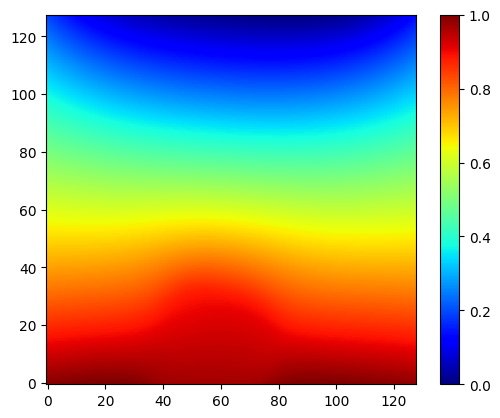

In [96]:
plt.imshow(sim_image, cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()

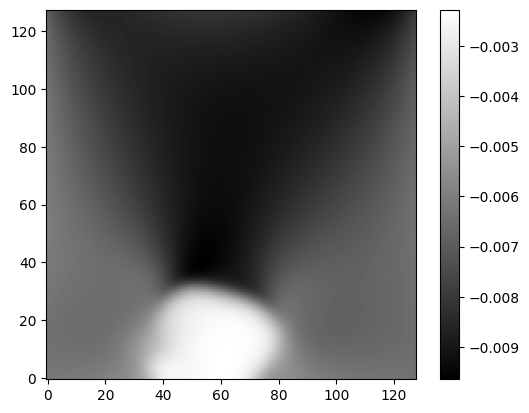

In [97]:
sim_strain = np.gradient(sim_image, axis=0)
plt.imshow(sim_strain, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

In [98]:
sim_gt = load(sim_gt_path)

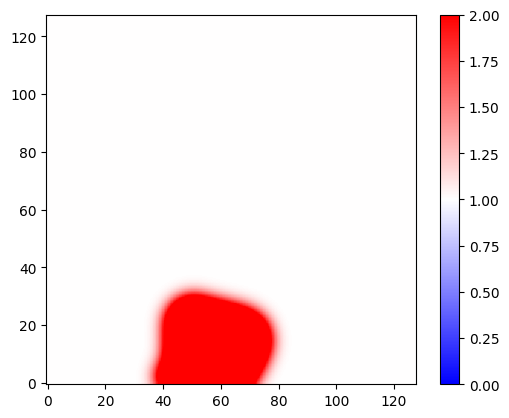

In [99]:
plt.imshow(sim_gt, cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
plt.gca().invert_yaxis()
plt.clim(0,2)
plt.colorbar() #format=ticker.ScalarFormatter(), ticks=[0.01, 0.1, 1, 5])

In [100]:
nn_prediction = generator(sim_image[tf.newaxis, ...], training=False)

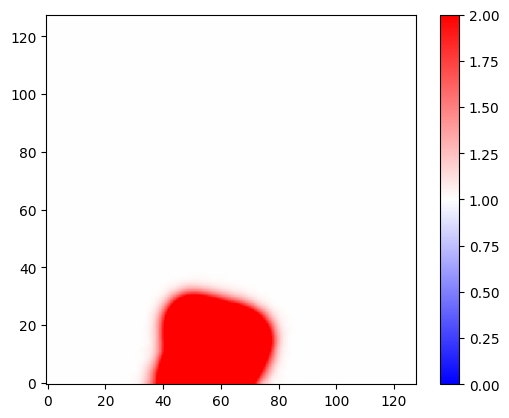

In [101]:
plt.imshow(nn_prediction[0, ...], cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1)))
plt.gca().invert_yaxis()
plt.clim(0,2)
plt.colorbar()

In [102]:
original_range = (0, 128)
new_range = (0, 3.8)
def convert_to_original(new_value, original_range, new_range):
    return (new_value / new_range[1]) * original_range[1]

In [103]:
original_range_y = (128, 0)
new_range_y = (0+0.0, 3.8+0.0)

In [104]:
pixel_range = (128, 0)  # Pixel range from 128 to 0
cm_range = (0.0+0.0, 3.8+0.0) # cm range from 0.58 to 4.38
scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
# cm_position = 1.0
pixel_position = (0.0 - cm_range[0]) * scale_factor
pixel_position = pixel_range[0] - pixel_position

def pix_pos(cm_position):
    scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
    pixel_position = (0.0 - cm_range[0]) * scale_factor
    pixel_position = pixel_range[0] - pixel_position
    return pixel_position
    
def convert_to_original_y(new_value, original_range_y, new_range_y):
    return (new_value / new_range_y[1]) * original_range[1]

In [105]:
cm_points = [x for x in range(3,-1,-1)]
cm_points

[3, 2, 1, 0]

In [106]:
plt.rcParams.update({'font.size': 16})

In [107]:
np.linspace(0, 128, 5)

array([  0.,  32.,  64.,  96., 128.])

In [108]:
np.array([32., 64., 96.])

array([32., 64., 96.])

In [123]:
plt.tight_layout()
def generate_images_plots(sim_image, sim_gt, nn_prediction, number):
    
    display_list = [sim_image, sim_gt, nn_prediction]
    if tf.reduce_max(nn_prediction[0, ...]).numpy() > 1.1:
        # type_of_inc = 'hard'
        climlim = 5
    else:
        # type_of_inc = 'soft'
        climlim = 2
    mse_loss = tf.keras.losses.MeanSquaredError()(sim_gt, nn_prediction).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(sim_gt, nn_prediction).numpy()
    # print(mse_loss, mape_loss)
    with open('a_results_for_paper2/losses.csv', "a") as file:
        file.write(f"{number}, {mse_loss}, {mape_loss}\n")
    title = ['Displacement (a.u.)', 'Ground Truth', f'Predicted'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    plt.tight_layout()
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.tight_layout()
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='jet')
            plt.colorbar(location='right',fraction=0.0455)
            plt.gca().invert_yaxis()
            
            new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
            plt.gca().set_xticks(new_tick_locations)
            scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
            plt.gca().set_xticklabels(scaled_tick_labels)
            new_tick_locations = [convert_to_original_y(val, original_range_y, new_range_y) for val in range(3,-1,-1)] #np.linspace(128, 0, 5)
            # new_tick_locations = [pix_pos(x) for x in cm_points][::-1] #np.linspace(128, 0, 5)
            print('new_tick_locations',new_tick_locations)
            # offset = pixel_position-new_tick_locations[0]
            # new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
            # print('new_tick_locations',new_tick_locations)
            
            offset = 128-new_tick_locations[0]
            new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
            print('new_tick_locations',new_tick_locations)
            plt.gca().set_yticks(new_tick_locations)
            scaled_tick_labels = [f'{val:.0f}' for val in range(cm_points[-1],cm_points[0]+1)] #["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
            plt.gca().set_yticklabels(scaled_tick_labels)
            plt.gca().set_xlabel('(cm)')
            plt.gca().set_ylabel('(cm)')
            # plt.subplots_adjust(wspace=None, hspace=None)

    
        else:
            plt.imshow(display_list[i], cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.colorbar(location='right',fraction=0.0455)
            plt.gca().invert_yaxis()
            climlim = 5
            plt.clim([0, climlim])
            # plt.clim(0,2)
            new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
            plt.gca().set_xticks(new_tick_locations)
            scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
            plt.gca().set_xticklabels(scaled_tick_labels)

            plt.gca().set_yticklabels([])
            plt.gca().set_xlabel('(cm)')
            if i == 2:
                plt.subplots_adjust(left=0.0)
            
        
        plt.axis('on')
        plt.tight_layout()
        # plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    # plt.subplots_adjust(wspace=None, hspace=None)
    plt.savefig(f'a_results_for_paper2/simulated/{number}.png', bbox_inches='tight', dpi=300) 
    # print(mse_loss, mape_loss)
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [124]:
new_tick_locations = [32*val+32 for val in range(3)] #np.linspace(0, 128, 5)
new_tick_locations

[32, 64, 96]

In [125]:
ii

4

In [126]:
128-101.053

26.947000000000003

new_tick_locations [101.05263157894737, 67.36842105263158, 33.68421052631579, 0.0]
new_tick_locations [128.0, 94.3157894736842, 60.63157894736842, 26.94736842105263]


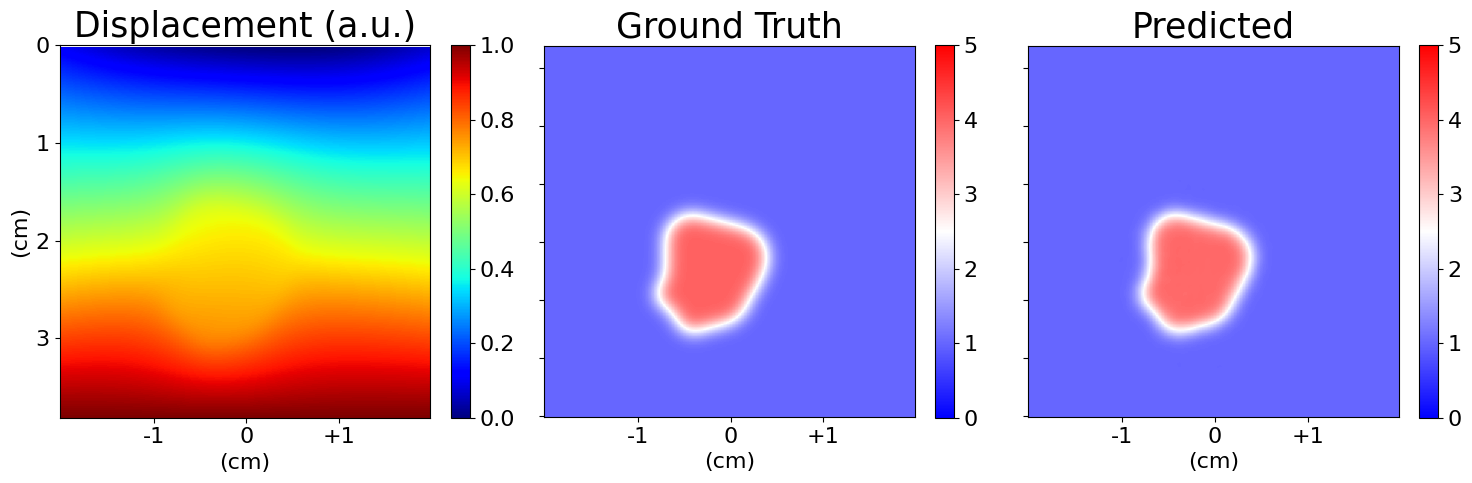

In [129]:
generate_images_plots(sim_image, sim_gt, nn_prediction[0, ...], ii)

In [130]:
# def plot_it(counter, p_value, disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
#     # if file_name[0] == '1':
#     #     c_nn = 1/c_nn
#     #     c_mike = 1/c_mike
#     #     climlim = 2
#     # elif file_name[0] == '2':
#     #     c_nn = 1/c_nn
#     #     c_mike = 1/c_mike
#     #     climlim = 2
#     # elif file_name[0] == '3':
#     #     climlim = 3.5
#     # else:
#     #     climlim = 5
#     inclusion_number = file_name.split('_')[0]
#     frame_number = file_name.split('_')[1]
    
#     print('inclusion_number',inclusion_number)
#     print('frame_number',frame_number)
#     print('window',p_value) 
        
#     if p_value == 1:
#         window_offset = 0.0
#         cm_position = 0.0
#         cm_points = [x for x in range(3,-1,-1)]
#     elif p_value == 2:
#         window_offset = 0.58*1
#         cm_position = 1.0
#         cm_points = [x for x in range(4,0,-1)]
#     elif p_value == 3:
#         window_offset = 0.58*2
#         cm_position = 2.0
#         cm_points = [x for x in range(4,1,-1)]
#     elif p_value == 4:
#         window_offset = 0.58*3
#         cm_position = 2.0
#         cm_points = [x for x in range(5,1,-1)]
#     else:
#         print('invalid window')
    
#     climlim_lower = 0
#     # climlim = 5
    
#     disp = disp*1000 #converting m into mm
    
#     # strain = np.gradient(disp, 30.0, 1540/40e6/2*1000)
#     # strain = normalize(strain)
#     strain = np.gradient(disp, axis=0)
#     strain = strain*100/0.3

#     def px_to_mm(values):
#         return values*trans_width/128

#     def mm_to_px(values):
#         return values*128/trans_width
    
#     original_range = (0, 128)
#     new_range = (0, 3.8)
#     def convert_to_original(new_value, original_range, new_range):
#         return (new_value / new_range[1]) * original_range[1]

#     original_range_y = (128, 0)
#     new_range_y = (0+window_offset, 3.8+window_offset)

#     pixel_range = (128, 0)  # Pixel range from 128 to 0
#     cm_range = (0.0+window_offset, 3.8+window_offset) # cm range from 0.58 to 4.38
#     scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
#     # cm_position = 1.0
#     pixel_position = (cm_position - cm_range[0]) * scale_factor
#     pixel_position = pixel_range[0] - pixel_position

#     def pix_pos(cm_position):
#         scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
#         pixel_position = (cm_position - cm_range[0]) * scale_factor
#         pixel_position = pixel_range[0] - pixel_position
#         return pixel_position
        
#     def convert_to_original_y(new_value, original_range_y, new_range_y):
#         return (new_value / new_range_y[1]) * original_range[1]
        
#     # fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
#     fig, (ax1, ax11, ax2) = plt.subplots(1,3, figsize=(15, 8))
#     fig.tight_layout(pad=2.5)
#     im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
#     # ax.invert_yaxis()
#     # ax1.set_xlabel('pixel')
#     # ax1.set_ylabel('pixel')
#     # yticks = np.arange(0,128)
#     # ax.set_yticklabels(yticks[::-1])  
#     # ax.figure.savefig('1.png')
#     # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
#     # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
#     # # v2.set_ylabel('cm')
#     # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
#     # # ax.figure.savefig('2.png')
#     # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
#     # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
#     # # h2.set_xlabel('cm')
#     # # ax.figure.savefig('3.png')
#     ax1.title.set_text(f'Displacement (mm)')
#     ax1.invert_yaxis()

#     # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
#     new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
#     ax1.set_xticks(new_tick_locations)
#     scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
#     ax1.set_xticklabels(scaled_tick_labels)

#     # new_tick_locations = [convert_to_original_y(val, original_range_y, new_range_y) for val in range(3,-1,-1)] #np.linspace(128, 0, 5)
#     new_tick_locations = [pix_pos(x) for x in cm_points][::-1] #np.linspace(128, 0, 5)
#     print('new_tick_locations',new_tick_locations)
#     # offset = pixel_position-new_tick_locations[0]
#     # new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
#     # print('new_tick_locations',new_tick_locations)
#     ax1.set_yticks(new_tick_locations)

#     scaled_tick_labels = [f'{val:.0f}' for val in range(cm_points[-1],cm_points[0]+1)] #["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
#     ax1.set_yticklabels(scaled_tick_labels)
#     ax1.set_xlabel('(cm)')
#     ax1.set_ylabel('(cm)')
#     # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
#     # # # v2.set_ylabel('cm')
#     # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # 
#     # h1 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
#     # h1.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    
#     im1.set_clim(-0.65,0.0)
    
#     cbar = fig.colorbar(im1,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
#     cbar.set_ticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0])
    
#     # fig.colorbar(im1,orientation='vertical',fraction=0.046) #,fraction=0.046, pad=0.09)

#     ######################################################## Strain
#     im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
#     # ax.invert_yaxis()
#     # ax1.set_xlabel('pixel')
#     # ax1.set_ylabel('pixel')
#     # yticks = np.arange(0,128)
#     # ax.set_yticklabels(yticks[::-1])  
#     # ax.figure.savefig('1.png')
#     # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
#     # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
#     # # v2.set_ylabel('cm')
#     # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
#     # # ax.figure.savefig('2.png')
#     # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
#     # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
#     # # h2.set_xlabel('cm')
#     # # ax.figure.savefig('3.png')
#     ax11.title.set_text('Strain (%)')
#     ax11.invert_yaxis()

#     # new_tick_locations =  np.linspace(0, 128, 5)
#     # ax11.set_xticks(new_tick_locations)
#     # scaled_tick_labels = ["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
#     # ax11.set_xticklabels(scaled_tick_labels)
#     # new_tick_locations = np.linspace(128, 0, 5)
#     # ax11.set_yticks(new_tick_locations)
#     # scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
#     # ax11.set_yticklabels(scaled_tick_labels)
#     # ax2.get_yaxis().set_ticks([])
#     # ax11.set_xlabel('(cm)')

#     new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
#     ax11.set_xticks(new_tick_locations)
#     scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
#     ax11.set_xticklabels(scaled_tick_labels)
#     ax11.set_xlabel('(cm)')
    
#     ax11.get_yaxis().set_ticks([])

#     im11.set_clim(0.0,2.75)
    
#     cbar = fig.colorbar(im11,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
#     cbar.set_ticks([0.0,0.5,1.0,1.5,2.0,2.5])
    

#     # divnorm=colors.TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=5.0)
#     im2 = ax2.imshow(mike_mod, aspect='equal',cmap='bwr') #, norm=divnorm) # MidPointLogNorm(vmin=0.01, vmax=5.0, midpoint=1.0) )
#     # ax.invert_yaxis()
#     # ax2.set_xlabel('pixel')
#     # ax2.set_ylabel('pixel')
#     # yticks = np.arange(0,128)
#     # ax.set_yticklabels(yticks[::-1])  
#     # ax.figure.savefig('1.png')
#     # v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
#     # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
#     # # v2.set_ylabel('cm')
#     # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
#     # ax.figure.savefig('2.png')
#     # h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
#     # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
#     # h2.set_xlabel('cm')
#     # ax.figure.savefig('3.png')
#     ax2.title.set_text(f'DL Prediction')
#     # im2.set_clim(climlim_lower,climlim)
#     ax2.invert_yaxis()
#     # ax2.set_yticks([])

#     ## New code starts here
#     original_range = (0, 128)
#     new_range = (0, 3.8)
#     # Function to convert from new range to original range
#     def convert_to_original(new_value, original_range, new_range):
#         return (new_value / new_range[1]) * original_range[1]
    
#     new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
#     ax2.set_xticks(new_tick_locations)
#     scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
#     ax2.set_xticklabels(scaled_tick_labels)
#     # ax2.get_xaxis().set_ticks([0,64])
    
#     new_tick_locations = np.linspace(128, 0, 5)
#     ax2.set_yticks(new_tick_locations)
#     scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
#     ax2.set_yticklabels(scaled_tick_labels)
#     ax2.get_yaxis().set_ticks([])
#     ax2.set_xlabel('(cm)')
#     # # ax2.set_ylabel('(cm)')
#     # integer_locator = ticker.MaxNLocator(integer=True)
#     # ax2.xaxis.set_major_locator(integer_locator)
#     # im2.set_clim(0,5)

#     print('asdfasdfasdf',inclusion_number)
#     climlim = get_climlim(inclusion_number)       
#     im2.set_clim(0,climlim)
    
#     cbar = fig.colorbar(im2,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)

#     if climlim == 2:
#         cbar.set_ticks([0,0.5,1,1.5,2])
#     else:
#         cbar.set_ticks([0,1,2,3,4,5]) #,  labels=['0.01', '1.0', '5.0'])
    
#     # cbar = fig.colorbar(cax, orientation='horizontal')
#     # cbar.set_ticks(ticks=[-1, 0, 1], labels=['Low', 'Medium', 'High'])
#     # im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
#     # # ax.invert_yaxis()
#     # # ax3.set_xlabel('pixel')
#     # # ax3.set_ylabel('pixel')
#     # # yticks = np.arange(0,128)
#     # # ax.set_yticklabels(yticks[::-1])  
#     # # ax.figure.savefig('1.png')
#     # v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
#     # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
#     # # v2.set_ylabel('cm')
#     # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
#     # # ax.figure.savefig('2.png')
#     # h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
#     # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
#     # # h2.set_xlabel('cm')
#     # # ax.figure.savefig('3.png')
#     # ax3.title.set_text(f'DL Modulus, Contrast={c_mike:.3f}')
#     # # im3.set_clim(0, climlim)
#     # ax3.invert_yaxis()
#     # ax3.set_yticks([])
#     # fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)
#     fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
#     fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}_{p_value}.png', dpi=300)   # save the figure to file
#     # plt.show(fig)
#     plt.close(fig) 

In [131]:
sim_test_data_path = glob.glob('data_for_testing/simulated*/*/uY_128x128*.raw')
sim_test_data_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [132]:
len(sim_test_data_path)

500

In [133]:
sim_test_data_gt_path = glob.glob('data_for_testing/simulated*/*/modulus_128x128*.raw')
sim_test_data_gt_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [134]:
len(sim_test_data_gt_path)

500

In [229]:
plt.tight_layout()
def generate_images_plots(sim_image, sim_gt, nn_prediction, number):
    
    display_list = [sim_image, sim_gt, nn_prediction]
    print(tf.reduce_max(nn_prediction[0, ...]).numpy())
    if tf.reduce_max(nn_prediction[0, ...]).numpy() > 1.1:
        # type_of_inc = 'hard'
        climlim = 5
    else:
        # type_of_inc = 'soft'
        climlim = 2
    mse_loss = tf.keras.losses.MeanSquaredError()(sim_gt, nn_prediction).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(sim_gt, nn_prediction).numpy()
    # print(mse_loss, mape_loss)
    with open('a_results_for_paper2/losses.csv', "a") as file:
        file.write(f"{number}, {mse_loss}, {mape_loss}\n")
    title = ['Displacement (a.u.)', 'Ground Truth Modulus', f'Predicted Modulus'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    plt.tight_layout()
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.tight_layout()
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='jet')
            plt.colorbar(location='right',fraction=0.0455)
            plt.gca().invert_yaxis()
            
            new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
            plt.gca().set_xticks(new_tick_locations)
            scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
            plt.gca().set_xticklabels(scaled_tick_labels)
            new_tick_locations = [convert_to_original_y(val, original_range_y, new_range_y) for val in range(3,-1,-1)] #np.linspace(128, 0, 5)
            # new_tick_locations = [pix_pos(x) for x in cm_points][::-1] #np.linspace(128, 0, 5)
            print('new_tick_locations',new_tick_locations)
            # offset = pixel_position-new_tick_locations[0]
            # new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
            # print('new_tick_locations',new_tick_locations)
            
            offset = 128-new_tick_locations[0]
            new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
            print('new_tick_locations',new_tick_locations)
            plt.gca().set_yticks(new_tick_locations)
            scaled_tick_labels = [f'{val:.0f}' for val in range(cm_points[-1],cm_points[0]+1)] #["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
            plt.gca().set_yticklabels(scaled_tick_labels)
            plt.gca().set_ylabel('Depth (cm)')
            plt.gca().set_xlabel('Lateral Positon (cm)')
            # plt.subplots_adjust(wspace=None, hspace=None)

    
        else:
            plt.imshow(display_list[i], cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            cbar=plt.colorbar(location='right',fraction=0.0455)
            cbar.set_ticks([0,0.5,1,1.5,2])
            plt.gca().invert_yaxis()
            # climlim = 5
            plt.clim([0, climlim])
            # plt.clim(0,2)
            new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
            plt.gca().set_xticks(new_tick_locations)
            scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
            plt.gca().set_xticklabels(scaled_tick_labels)

            plt.gca().set_yticklabels([])
            plt.gca().set_xlabel('Lateral Position (cm)')
            if i == 2:
                plt.subplots_adjust(left=0.0)
            
        
        plt.axis('on')
        plt.tight_layout()
        # plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    # plt.subplots_adjust(wspace=None, hspace=None)
    plt.savefig(f'a_results_for_paper2/simulated/{number}.png', bbox_inches='tight', dpi=300) 
    # print(mse_loss, mape_loss)
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [232]:
# file_names_choses = ['simulated2_1_uY_128x128_5.raw']
file_names_choses= ['simulated2_1_uY_128x128_1.raw']
# file_names_choses = ['simulated2_10_uY_128x128_1.raw']
# file_names_choses = ['simulated2_10_uY_128x128_5.raw'] 

1.0071752
new_tick_locations [101.05263157894737, 67.36842105263158, 33.68421052631579, 0.0]
new_tick_locations [128.0, 94.3157894736842, 60.63157894736842, 26.94736842105263]


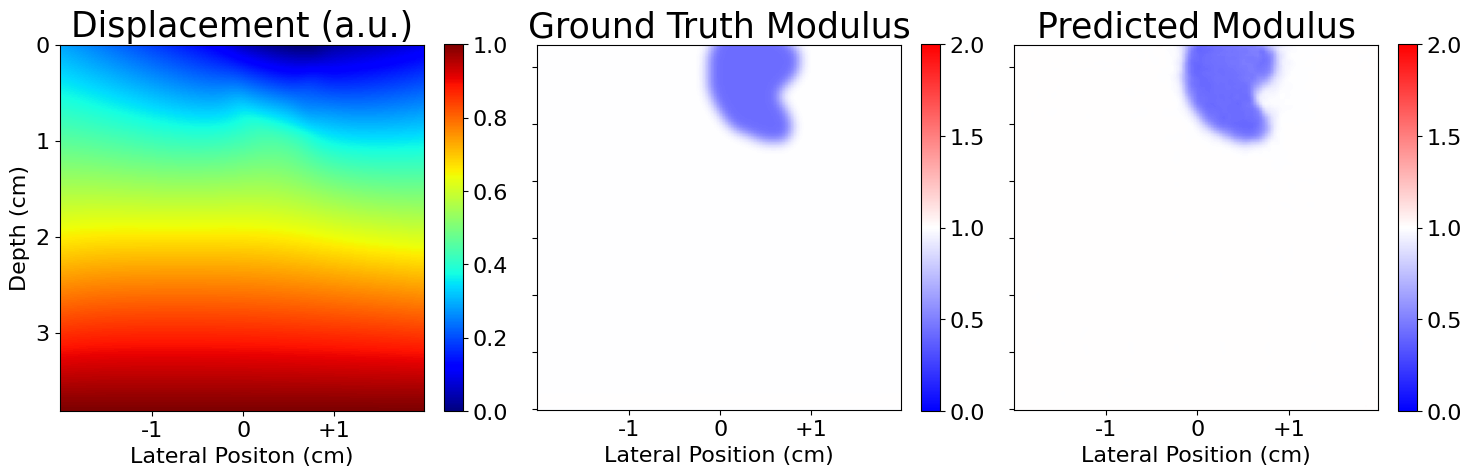

In [233]:
for sim_image_path, sim_gt_path in zip(sim_test_data_path,sim_test_data_gt_path):
    file_name = sim_image_path.split('/')[-3] + '_' + sim_image_path.split('/')[-2] + '_' + sim_image_path.split('/')[-1]
    if file_name in file_names_choses:
        sim_image = load(sim_image_path)
        sim_image = normalize(sim_image)
    
        sim_gt = load(sim_gt_path)
        nn_prediction = generator(sim_image[tf.newaxis, ...], training=False)
        
        generate_images_plots(sim_image, sim_gt, nn_prediction[0, ...], file_name)
    else:
        continue

In [234]:
file_name = sim_image_path.split('/')[-3] + '_' + sim_image_path.split('/')[-2] + '_' + sim_image_path.split('/')[-1]

In [235]:
file_name

'simulated4_20_uY_128x128_9.raw'

In [158]:
### Old model

### Old generator

In [236]:
OUTPUT_CHANNELS2 = 1

In [237]:
def downsample2(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [238]:
# down_model = downsample(3, 4)
# down_result = down_model(tf.expand_dims(inp, 0))
# print (down_result.shape)

In [239]:
def upsample2(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [240]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

In [241]:
def Generator2():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
        downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 3),  # (batch_size, 64, 64, 128)
        downsample(256, 3),  # (batch_size, 32, 32, 256)
        downsample(512, 3),  # (batch_size, 16, 16, 512)
        downsample(512, 3),  # (batch_size, 8, 8, 512)
        downsample(512, 3),  # (batch_size, 4, 4, 512)
        downsample(512, 3),  # (batch_size, 2, 2, 512)
        # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 3, apply_dropout=False),  # (batch_size, 8, 8, 1024)
        upsample(512, 3),  # (batch_size, 16, 16, 1024)
        upsample(256, 3),  # (batch_size, 32, 32, 512)
        upsample(128, 3),  # (batch_size, 64, 64, 256)
        upsample(64, 3),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS2, 3,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # x = last(x)
    # x = 1.0 + (10.0 - 1.0)*x 

    upsampling = tf.keras.layers.UpSampling2D(size=2, interpolation = 'bilinear')
    # last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')
    last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    multiply = tf.keras.layers.Lambda(lambda x: 0.1 + (5.0 - 0.1)*x)
    
    x = upsampling(x)
    x = last_conv(x)
    x = multiply(x)
    
    # x = 0.1 + (10.0 - 0.1)*x
    # this one for both!

    return tf.keras.Model(inputs=inputs, outputs=x)

In [242]:
# Visualizing generator architecture
generator2 = Generator2()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [243]:
# Testing the generator
# gen_output = generator(inp[tf.newaxis, ...], training=False)
# plt.imshow(gen_output[0, ...])

In [244]:
# gen_output.shape

In [245]:
# Generator loss
LAMBDA2 = 100
loss_object2 = tf.keras.losses.MeanSquaredError()
loss_tracker2 = tf.keras.metrics.Mean(name="loss")
val_loss_tracker2 = tf.keras.metrics.Mean(name="loss")

In [246]:
def generator_loss2(gen_output, target):
    #Possible addition: regularizer
    gan_loss2 = loss_object2(gen_output, target)
    return gan_loss2

In [247]:
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='results/model.png')

In [248]:
MODEL_PATH = "resultsspie/model_weights/mse_model"
BEST_PATH = "resultsspie-1/model_weights/best_mse_model"

In [249]:
generator2.load_weights(BEST_PATH)

In [250]:
nn_prediction_old = generator2(sim_image[tf.newaxis, ...], training=True)

In [427]:
plt.tight_layout()
def generate_images_plots(sim_image, sim_gt, nn_prediction, nn_prediction_old, number):
    display_list = [sim_image, sim_gt, nn_prediction, nn_prediction_old]
    mse_loss = tf.keras.losses.MeanSquaredError()(sim_gt, nn_prediction).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(sim_gt, nn_prediction).numpy()
    print(mse_loss, mape_loss)
    title = ['Displacement (a.u.)', 'Ground Truth modulus', f'Current DL modulus', 'Previous DL modulus'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i], fontsize=15)
        if i==0:
            plt.imshow(display_list[i], cmap='jet')
            plt.colorbar(location='right',fraction=0.0455, pad=0.04)
            plt.gca().invert_yaxis()

            new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
            plt.gca().set_xticks(new_tick_locations)
            scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
            plt.gca().set_xticklabels(scaled_tick_labels)
            new_tick_locations = [convert_to_original_y(val, original_range_y, new_range_y) for val in range(3,-1,-1)] #np.linspace(128, 0, 5)
            # new_tick_locations = [pix_pos(x) for x in cm_points][::-1] #np.linspace(128, 0, 5)
            print('new_tick_locations',new_tick_locations)
            # offset = pixel_position-new_tick_locations[0]
            # new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
            # print('new_tick_locations',new_tick_locations)
            
            offset = 128-new_tick_locations[0]
            new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
            print('new_tick_locations',new_tick_locations)
            plt.gca().set_yticks(new_tick_locations)
            # scaled_tick_labels = np.array([1,2,3,4])
            scaled_tick_labels = [f'{val:.0f}' for val in range(cm_points[-1],cm_points[0]+1)] #["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
            plt.gca().set_yticklabels(scaled_tick_labels)
            plt.gca().set_ylabel('Depth (cm)')
            plt.gca().set_xlabel('Lateral Positon (cm)')
            # plt.subplots_adjust(wspace=None, hspace=None)
            
        else:
            plt.imshow(display_list[i], cmap='bwr') #, norm=LLL MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.colorbar(location='right',fraction=0.0455, pad=0.04)
            plt.gca().invert_yaxis()
            plt.yticks([])
            plt.clim(0,2)

            new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
            plt.gca().set_xticks(new_tick_locations)
            scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
            plt.gca().set_xticklabels(scaled_tick_labels)
            plt.gca().set_xlabel('Lateral Positon (cm)')
            
        plt.axis('on')
    plt.tight_layout()
    plt.savefig(f'a_results_for_paper2/abl_{number}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [428]:
sim_test_data_path = glob.glob('data_for_testing/simulated2/10/uY_128x128*.raw')
sim_test_data_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [429]:
sim_test_data_gt_path = glob.glob('data_for_testing/simulated2/10/modulus_128x128*.raw')
sim_test_data_gt_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [430]:
sim_test_data_path

['data_for_testing/simulated2/10/uY_128x128_1.raw',
 'data_for_testing/simulated2/10/uY_128x128_2.raw',
 'data_for_testing/simulated2/10/uY_128x128_3.raw',
 'data_for_testing/simulated2/10/uY_128x128_4.raw',
 'data_for_testing/simulated2/10/uY_128x128_5.raw',
 'data_for_testing/simulated2/10/uY_128x128_6.raw',
 'data_for_testing/simulated2/10/uY_128x128_7.raw',
 'data_for_testing/simulated2/10/uY_128x128_8.raw']

In [431]:
ii = 0
sim_image_path = sim_test_data_path[ii]
sim_gt_path = sim_test_data_gt_path[ii]
sim_image_path, sim_gt_path

('data_for_testing/simulated2/10/uY_128x128_1.raw',
 'data_for_testing/simulated2/10/modulus_128x128_1.raw')

In [432]:
sim_image = load(sim_image_path)
sim_image = normalize(sim_image)

In [433]:
sim_gt = load(sim_gt_path)

In [434]:
nn_prediction = generator(sim_image[tf.newaxis, ...], training=False)

In [435]:
nn_prediction_old = generator2(sim_image[tf.newaxis, ...], training=True)

0.00027630146 0.30716893
new_tick_locations [101.05263157894737, 67.36842105263158, 33.68421052631579, 0.0]
new_tick_locations [128.0, 94.3157894736842, 60.63157894736842, 26.94736842105263]


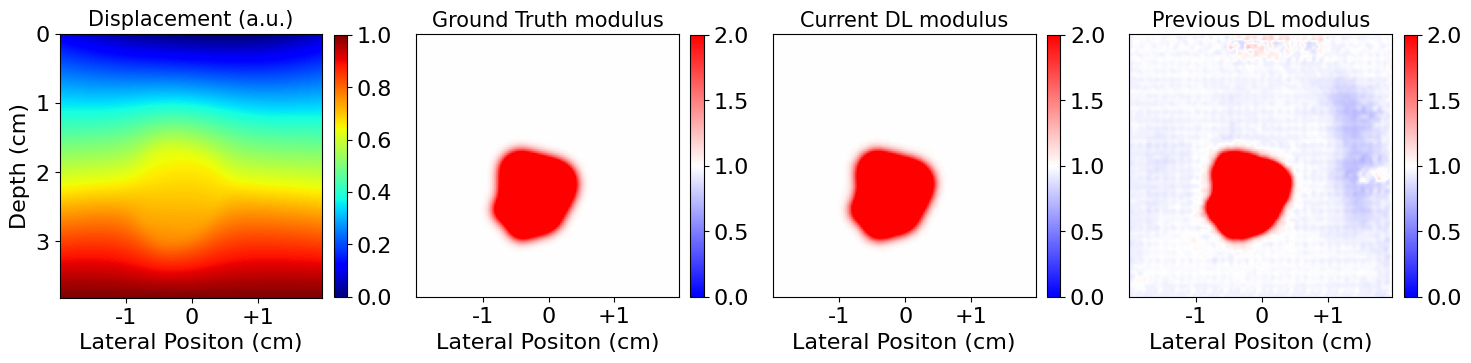

In [436]:
generate_images_plots(sim_image, sim_gt, nn_prediction[0, ...], nn_prediction_old[0, ...], ii)

In [ ]:
def plot_it(counter, p_value, disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    inclusion_number = file_name.split('_')[0][-1]
    frame_number = file_name.split('_')[1]
    
    print('inclusion_number',inclusion_number)
    print('frame_number',frame_number)
    print('window',p_value)

    if p_value == 1:
        window_offset = 0.0
        cm_position = 0.0
        cm_points = [x for x in range(3,-1,-1)]
        dx_dx = 0.378 #128*37.8/508
        climlim_s1 = 0
        climlim_s2 = 2
    elif p_value == 2:
        window_offset = 0.58*1
        cm_position = 1.0
        cm_points = [x for x in range(4,0,-1)]
        dx_dx = 0.378 #128*37.8/360
    elif p_value == 3:    
        window_offset = 0.58*2
        cm_position = 2.0
        cm_points = [x for x in range(4,1,-1)]
        dx_dx = 0.378 # 128*37.8/256
    elif p_value == 4:
        window_offset = 0.58*3
        cm_position = 2.0
        cm_points = [x for x in range(5,1,-1)]
        dx_dx = 0.378 #128*37.8/360
    else:
        climlim_s1 = 0
        climlim_s2 = 2
        print('invalid window')
        
    climlim_s1 = 0
    climlim_s2 = 2

    climlim_lower = 0
    climlim = 5
    
    # disp = -disp*1000 #converting m into mm
    
    # strain = np.gradient(disp, 30.0, 1540/40e6/2*1000)
    # strain = normalize(strain)
    strain = np.gradient(disp, axis=0)
    strain = strain*100/(dx_dx)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    original_range = (0, 128)
    new_range = (0, 3.8)
    def convert_to_original(new_value, original_range, new_range):
        return (new_value / new_range[1]) * original_range[1]

    original_range_y = (128, 0)
    new_range_y = (0+window_offset, 3.8+window_offset)

    pixel_range = (128, 0)  # Pixel range from 128 to 0
    cm_range = (0.0+window_offset, 3.8+window_offset) # cm range from 0.58 to 4.38
    scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
    # cm_position = 1.0
    pixel_position = (cm_position - cm_range[0]) * scale_factor
    pixel_position = pixel_range[0] - pixel_position

    def pix_pos(cm_position):
        scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
        pixel_position = (cm_position - cm_range[0]) * scale_factor
        pixel_position = pixel_range[0] - pixel_position
        return pixel_position
        
    def convert_to_original_y(new_value, original_range_y, new_range_y):
        return (new_value / new_range_y[1]) * original_range[1]
        
    # fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig, (ax1, ax11, ax2) = plt.subplots(1,3, figsize=(15, 8))
    fig.tight_layout(pad=2.5)
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement (mm)')
    ax1.invert_yaxis()

    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    ax1.set_xticks(new_tick_locations)
    scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax1.set_xticklabels(scaled_tick_labels)

    # new_tick_locations = [convert_to_original_y(val, original_range_y, new_range_y) for val in range(3,-1,-1)] #np.linspace(128, 0, 5)
    new_tick_locations = [pix_pos(x) for x in cm_points][::-1] #np.linspace(128, 0, 5)
    print('new_tick_locations',new_tick_locations)
    # offset = pixel_position-new_tick_locations[0]
    # new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
    # print('new_tick_locations',new_tick_locations)
    ax1.set_yticks(new_tick_locations)

    scaled_tick_labels = [f'{val:.0f}' for val in range(cm_points[-1],cm_points[0]+1)] #["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    ax1.set_yticklabels(scaled_tick_labels)
    ax1.set_xlabel('(cm)')
    ax1.set_ylabel('(cm)')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # 
    # h1 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h1.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    
    # im1.set_clim(-0.65,0.0)
    
    cbar = fig.colorbar(im1,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    # cbar.set_ticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0])
    
    # fig.colorbar(im1,orientation='vertical',fraction=0.046) #,fraction=0.046, pad=0.09)

    ######################################################## Strain
    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain (%)')
    ax11.invert_yaxis()

    # new_tick_locations =  np.linspace(0, 128, 5)
    # ax11.set_xticks(new_tick_locations)
    # scaled_tick_labels = ["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax11.set_xticklabels(scaled_tick_labels)
    # new_tick_locations = np.linspace(128, 0, 5)
    # ax11.set_yticks(new_tick_locations)
    # scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    # ax11.set_yticklabels(scaled_tick_labels)
    # ax2.get_yaxis().set_ticks([])
    # ax11.set_xlabel('(cm)')

    new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    ax11.set_xticks(new_tick_locations)
    scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax11.set_xticklabels(scaled_tick_labels)
    ax11.set_xlabel('(cm)')
    
    ax11.get_yaxis().set_ticks([])
        
    # im11.set_clim(0.0,2.75)
    # im11.set_clim(climlim_s1,climlim_s2)
    cbar = fig.colorbar(im11,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    # cbar.set_ticks([0.0,0.5,1.0,1.5,2.0,2.5])
    

    # divnorm=colors.TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=5.0)
    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm=divnorm) # MidPointLogNorm(vmin=0.01, vmax=5.0, midpoint=1.0) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    # h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Prediction')
    # im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])

    ## New code starts here
    original_range = (0, 128)
    new_range = (0, 3.78)
    # Function to convert from new range to original range
    def convert_to_original(new_value, original_range, new_range):
        return (new_value / new_range[1]) * original_range[1]
    
    new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    ax2.set_xticks(new_tick_locations)
    scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax2.set_xticklabels(scaled_tick_labels)
    # ax2.get_xaxis().set_ticks([0,64])
    
    new_tick_locations = np.linspace(128, 0, 5)
    ax2.set_yticks(new_tick_locations)
    scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    ax2.set_yticklabels(scaled_tick_labels)
    ax2.get_yaxis().set_ticks([])
    ax2.set_xlabel('(cm)')
    # # ax2.set_ylabel('(cm)')
    # integer_locator = ticker.MaxNLocator(integer=True)
    # ax2.xaxis.set_major_locator(integer_locator)
    im2.set_clim(0,5)
    
    cbar = fig.colorbar(im2,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    cbar.set_ticks([0,1,2,3,4,5]) #,  labels=['0.01', '1.0', '5.0'])
    
    # cbar = fig.colorbar(cax, orientation='horizontal')
    # cbar.set_ticks(ticks=[-1, 0, 1], labels=['Low', 'Medium', 'High'])
    # im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # # ax.invert_yaxis()
    # # ax3.set_xlabel('pixel')
    # # ax3.set_ylabel('pixel')
    # # yticks = np.arange(0,128)
    # # ax.set_yticklabels(yticks[::-1])  
    # # ax.figure.savefig('1.png')
    # v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    # ax3.title.set_text(f'DL Modulus, Contrast={c_mike:.3f}')
    # # im3.set_clim(0, climlim)
    # ax3.invert_yaxis()
    # ax3.set_yticks([])
    # fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.savefig(f'a_results_for_paper2/abl2_{p_value}.png',dpi=300)   # save the figure to file
    plt.show(fig)
    plt.close(fig) 

In [ ]:
 plot_it(counter, p_value, disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78)

In [ ]:
### End of Old Generatoe

In [766]:
mse_loss = tf.keras.metrics.mean_squared_error(sim_gt, nn_prediction[0, ...])
avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()

mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(sim_gt, nn_prediction[0, ...])
avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()

thresholded_pred_mod, value_pred = display_otsus2(nn_prediction[0, ...])
thresholded_gt_mod, value_gt = display_otsus2(sim_gt)
dice_score = dice(thresholded_pred_mod, thresholded_gt_mod, k = 1) 

avg_mod_soft_pred, avg_mod_hard_pred, mod_aep_soft_pred, mod_aep_hard_pred = avg_modulus(nn_prediction[0, ...], value_pred)
avg_mod_soft_gt, avg_mod_hard_gt, mod_aep_soft_gt, mod_aep_hard_gt = avg_modulus(sim_gt, value_gt)

nmse_denominator = tf.math.reduce_mean(tf.keras.metrics.mean_squared_error(sim_gt, 0.0)).numpy()
nmse = avg_mse_loss/nmse_denominator

mod_err_hard = abs(avg_mod_hard_gt - avg_mod_hard_pred)
rel_mod_err_hard = mod_err_hard/avg_mod_hard_gt

mod_err_soft = abs(avg_mod_soft_gt - avg_mod_soft_pred)
rel_mod_err_soft = mod_err_soft/avg_mod_soft_gt

mse_score_hard, mse_score_soft = calculate_obj_mse(nn_prediction[0, ...], thresholded_pred_mod, sim_gt, thresholded_gt_mod)    

In [767]:
avg_mse_loss,avg_mape_loss,nmse

(7.132411e-05, 0.44448024, 7.467317e-05)

In [768]:
avg_mod_hard_gt,avg_mod_hard_pred

(0.9974993, 0.9990257)

In [769]:
avg_mod_soft_gt,avg_mod_soft_pred

(0.47633255, 0.487678)

In [770]:
mod_err_hard,rel_mod_err_hard

(0.0015264153, 0.001530242)

In [771]:
mod_err_soft,rel_mod_err_soft

(0.011345446, 0.02381833)

In [772]:
dice_score

0.999258853478555

In [154]:
### ITR Reconstruction HOW!!!!!!!!

In [213]:
plt.tight_layout()
def generate_images_plots(sim_image, sim_gt, nn_prediction, number):
    display_list = [sim_image, sim_gt, nn_prediction]
    mse_loss = tf.keras.losses.MeanSquaredError()(sim_gt, nn_prediction).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(sim_gt, nn_prediction).numpy()
    print(mse_loss, mape_loss)
    title = ['Input Image', 'Ground Truth', f'Predicted'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='jet')
            plt.colorbar(location='bottom',pad=0.1)
            plt.gca().invert_yaxis()
        else:
            plt.imshow(display_list[i], cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.colorbar(location='bottom',pad=0.1)
            plt.gca().invert_yaxis()
        plt.axis('on')
    plt.savefig(f'{RESULTS_FOLDER}/forpaper/200_{number}.png', bbox_inches='tight')
    # plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [195]:
generate_images_plots(sim_image, sim_gt, nn_prediction[0, ...], 2)

6.651033e-05 0.5887934


In [215]:
sim_test_data_path = glob.glob('data_for_testing/simulated2/2/uY_128x128*.raw')
sim_test_data_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [216]:
sim_test_data_gt_path = glob.glob('data_for_testing/simulated2/2/modulus_128x128*.raw')
sim_test_data_gt_path.sort(key= lambda x: (x.split('/')[-3], int(x.split('/')[-2]), x.split('/')[-1]))

In [217]:
sim_test_data_path

['data_for_testing/simulated2/2/uY_128x128_1.raw',
 'data_for_testing/simulated2/2/uY_128x128_2.raw',
 'data_for_testing/simulated2/2/uY_128x128_3.raw',
 'data_for_testing/simulated2/2/uY_128x128_4.raw',
 'data_for_testing/simulated2/2/uY_128x128_5.raw',
 'data_for_testing/simulated2/2/uY_128x128_6.raw',
 'data_for_testing/simulated2/2/uY_128x128_7.raw',
 'data_for_testing/simulated2/2/uY_128x128_8.raw']

In [218]:
sim_test_data_gt_path

['data_for_testing/simulated2/2/modulus_128x128_1.raw',
 'data_for_testing/simulated2/2/modulus_128x128_2.raw',
 'data_for_testing/simulated2/2/modulus_128x128_3.raw',
 'data_for_testing/simulated2/2/modulus_128x128_4.raw',
 'data_for_testing/simulated2/2/modulus_128x128_5.raw',
 'data_for_testing/simulated2/2/modulus_128x128_6.raw',
 'data_for_testing/simulated2/2/modulus_128x128_7.raw',
 'data_for_testing/simulated2/2/modulus_128x128_8.raw']

In [219]:
number = 1
for sim_image_path, sim_gt_path in zip(sim_test_data_path, sim_test_data_gt_path):
    sim_image = load(sim_image_path)
    sim_image = normalize(sim_image)
    sim_gt = load(sim_gt_path)
    nn_prediction = generator(sim_image[tf.newaxis, ...], training=False)
    generate_images_plots(sim_image, sim_gt, nn_prediction[0, ...], f'2_{number}')
    number = number + 1

2.459895e-05 0.22847661
2.015983e-05 0.21953684
2.523845e-05 0.22498748
3.7396243e-05 0.23746672
4.0245388e-05 0.24047247
0.00013775796 0.29320222
6.693587e-05 0.24971752
7.0377944e-05 0.24457428


In [ ]:
plt.tight_layout()
def plot_images_4(disp, mod, mike_mod, save='off',map_color='gray'):
    strain = np.gradient(disp, axis=0)
    # strain = normalize(strain)
    
    display_list = [disp, mod, mike_mod, strain]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', f'NN Mod, Contrast={contrast1:.3f}', f'ITR Mod, Constrast {contrast_mike1:.3f}', 'Strain'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==1:
            plt.imshow(display_list[i], cmap=map_color)#, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.gca().invert_yaxis()
            plt.clim(0,5)
            plt.colorbar(location='bottom',pad=0.1)
        elif i==2:
            plt.imshow(display_list[i], cmap=map_color)
            plt.colorbar(location='bottom',pad=0.1)
            plt.clim(0,5)
        else:
            plt.imshow(display_list[i], cmap=map_color)
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1)
            
        plt.axis('on')
    # plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
def plot_phantom(phantom_image, prediction,color_map='gray', k=1):
    display_list = [phantom_image[:,:,0], phantom_image[:,:,1], prediction[0][:,:,0]] 
    
    title = ['Displacement X (mm)','Displacement Y (mm)','Predicted Modulus (KPa)']
    plt.figure(figsize=(15, 8))
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=15)
        if i==0 or i==1:
            plt.imshow(display_list[i], cmap='seismic')
            plt.colorbar(location='bottom',pad=0.05) #.set_ticks([-0.0015, 0.0, 0.002])
        else:
            plt.imshow(display_list[i], cmap='seismic') #norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.colorbar(location='bottom',pad=0.05) #.set_ticks(k*np.array([0,1,2,3,4]))
            plt.clim(0,100)
        plt.axis('on')
    plt.show()
    # plt.savefig(f'{RESULTS_FOLDER}/training_plots/forposter-p.png', bbox_inches='tight')
    plt.close()

In [ ]:
plt.tight_layout()
def plot_images_4(disp, mod, mike_mod, save='off',map_color='gray'):
    strain = np.gradient(disp, axis=0)
    # strain = normalize(strain)
    
    display_list = [disp, mod, mike_mod, strain]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', f'NN Mod, Contrast={contrast1:.3f}', f'ITR Mod, Constrast {contrast_mike1:.3f}', 'Strain'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==1:
            plt.imshow(display_list[i], cmap=map_color)#, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.gca().invert_yaxis()
            plt.clim(0,5)
            plt.colorbar(location='bottom',pad=0.1)
        elif i==2:
            plt.imshow(display_list[i], cmap=map_color)
            plt.colorbar(location='bottom',pad=0.1)
            plt.clim(0,5)
        else:
            plt.imshow(display_list[i], cmap=map_color)
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1)
            
        plt.axis('on')
    # plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

### Step by step process for phantom data

In [92]:
## Step by step prpcess for phantom data

In [108]:
# phantom_images = glob.glob('data_phantom/frequencystudy/raw_3h6*_x.raw')
phantom_images = glob.glob('data_phantom/apples/patient/hassan_disp/patient*.raw')
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
phantom_images.sort()
phantom_images

['data_phantom/apples/patient/hassan_disp/patient1_1.raw',
 'data_phantom/apples/patient/hassan_disp/patient1_2.raw',
 'data_phantom/apples/patient/hassan_disp/patient1_3.raw',
 'data_phantom/apples/patient/hassan_disp/patient1_4.raw',
 'data_phantom/apples/patient/hassan_disp/patient2_1.raw',
 'data_phantom/apples/patient/hassan_disp/patient2_2.raw',
 'data_phantom/apples/patient/hassan_disp/patient2_3.raw',
 'data_phantom/apples/patient/hassan_disp/patient2_4.raw',
 'data_phantom/apples/patient/hassan_disp/patient3_1.raw',
 'data_phantom/apples/patient/hassan_disp/patient3_2.raw',
 'data_phantom/apples/patient/hassan_disp/patient3_3.raw',
 'data_phantom/apples/patient/hassan_disp/patient3_4.raw',
 'data_phantom/apples/patient/hassan_disp/patient4_1.raw',
 'data_phantom/apples/patient/hassan_disp/patient4_2.raw']

In [109]:
# gt = phantom_images[0]
# gt = load2(gt,size=(200,200))
# gt1 = normalize3(gt)
# plt.imshow(gt1, cmap='gray')
# plt.colorbar()

In [110]:
img = phantom_images[2]
img

'data_phantom/apples/patient/hassan_disp/patient1_3.raw'

In [111]:
file_name = img.split('_')[-2]
file_name

'disp/patient1'

In [112]:
phantom_image = load2(img,size=(508,1964)) #1976
# phantom_image = load2(img,size=(200,200))

In [113]:
phantom_image.shape

TensorShape([508, 1964, 1])

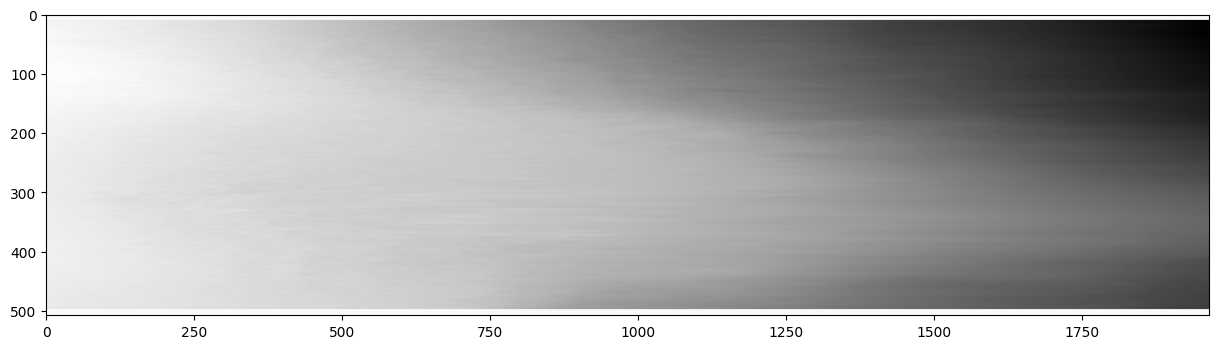

In [114]:
plt.figure(figsize=(15, 8))
plt.imshow(phantom_image, cmap='gray')
# # plt.colorbar()

In [115]:
phantom_image = remove_zero_pad(phantom_image)
phantom_image.shape

TensorShape([487, 1963, 1])

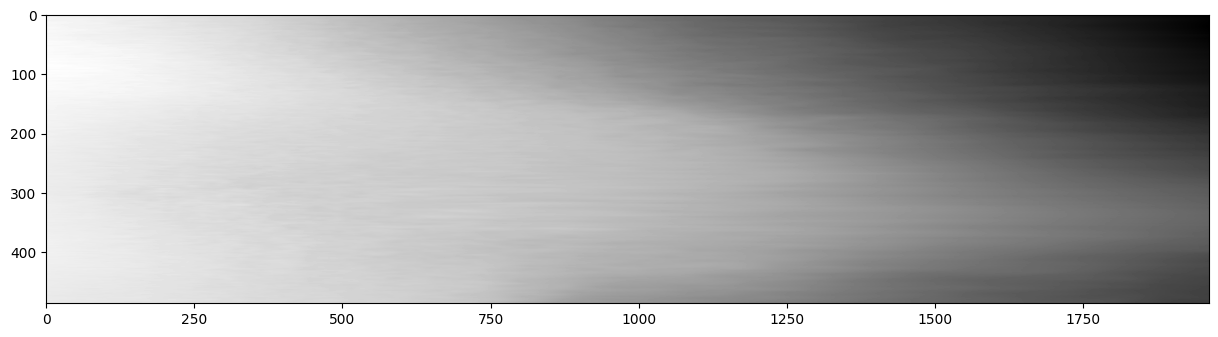

In [116]:
plt.figure(figsize=(15, 8))
plt.imshow(phantom_image, cmap='gray')

In [117]:
phantom_image.shape

TensorShape([487, 1963, 1])

In [118]:
2080*1.9250e-5/0.3*1000

133.46666666666667

In [119]:
2608*1.9250e-5/0.3*1000

167.34666666666666

In [120]:
2509*1.9250e-5/0.3*1000

160.9941666666667

In [121]:
3120*1.9250e-5/0.3*1000

200.20000000000002

In [122]:
3021*1.9250e-5/0.3*1000

193.8475

In [123]:
3648*1.9250e-5/0.3*1000

234.07999999999998

In [124]:
4160*1.9250e-5/0.3*1000

266.93333333333334

In [125]:
3378*1.9250e-5/0.3*1000

216.755

In [126]:
phantom_image.shape

TensorShape([487, 1963, 1])

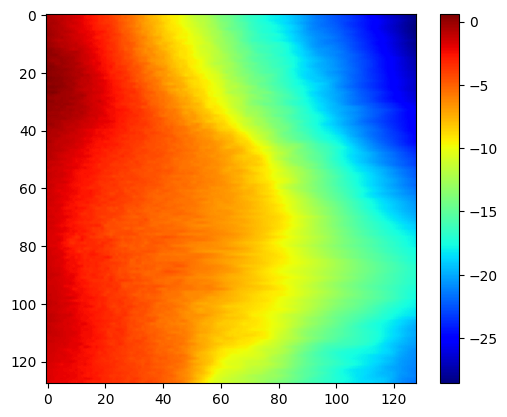

In [127]:
phantom_image1 = tf.image.resize(phantom_image, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
plt.imshow(phantom_image1, cmap='jet')
plt.colorbar()
# phantom_image1 = phantom_image

In [128]:
# phantom_image1 = tf.image.resize(phantom_image, (128,128))
# phantom_image = remove_zero_pad(phantom_image)
# phantom_image = tf.image.resize(phantom_image, (128,128))
# phantom_image = tf.image.flip_left_right(phantom_image)
# phantom_image1 = normalize(phantom_image1)
# phantom_image1 = normalize2(phantom_image1)

In [129]:
phantom_image2 = tf.image.rot90(phantom_image1,1)
# phantom_image3 = tf.image.flip_left_right(phantom_image2)
phantom_image3 = phantom_image2

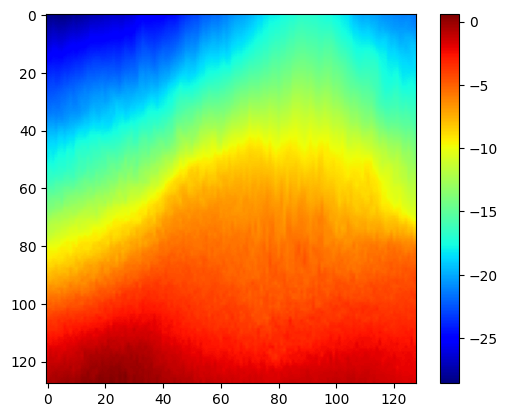

In [130]:
plt.imshow(phantom_image3, cmap='jet')
plt.colorbar()

In [131]:
phantom_image3.shape

TensorShape([128, 128, 1])

In [130]:
# phantom_image4 = tf.image.rot90(phantom_image3,4)
# plt.imshow(phantom_image4, cmap='jet')
# plt.colorbar()

In [131]:
# phantom_image3 = tf.image.resize(phantom_image3, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
# plt.imshow(phantom_image3, cmap='gray')
# plt.colorbar()

In [132]:
# phantom_image4.shape

In [133]:
# phantom_image = remove_zero_pad(phantom_image)

In [134]:
# phantom_image4 = normalize(phantom_image3)

In [139]:
phantom_image4 = phantom_image3

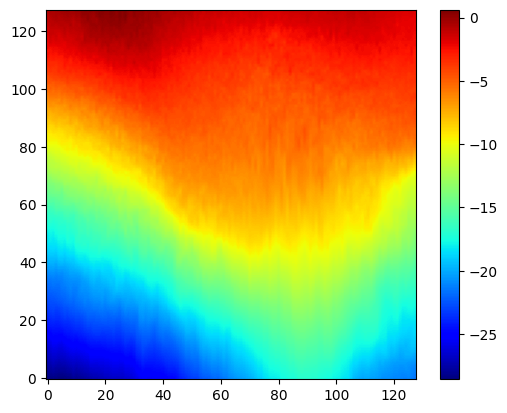

In [140]:
plt.imshow(phantom_image4, cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()

In [141]:
phantom_image4.shape

TensorShape([128, 128, 1])

In [142]:
# phantom_image4 = phantom_image4[20:148,:,:]
# phantom_image4.shape

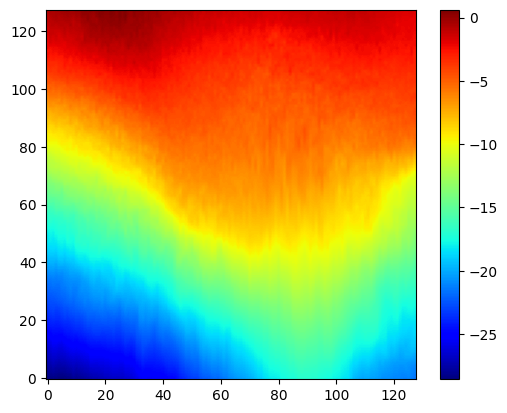

In [143]:
plt.imshow(phantom_image4, cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()

In [148]:
phantom_image4 = normalize(phantom_image4)
phantom_image4 = normalize2(phantom_image4)

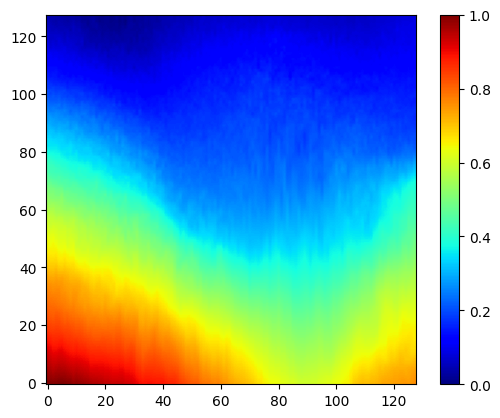

In [149]:
plt.imshow(phantom_image4, cmap='jet')
plt.gca().invert_yaxis()
plt.colorbar()

In [150]:
mod_image = generator(phantom_image4[tf.newaxis, ...], training=False)

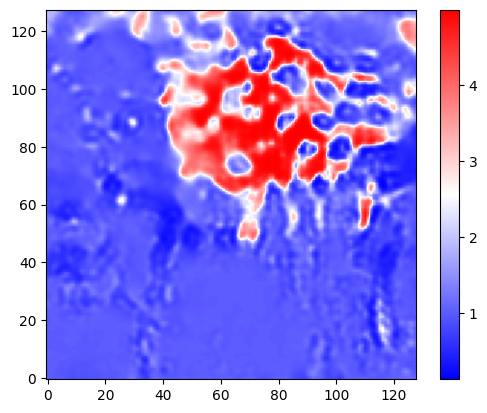

In [151]:
plt.imshow(mod_image[0],cmap='bwr')
plt.gca().invert_yaxis()
# plt.clim(1,5) 
plt.colorbar()

In [152]:
output = np.reshape(mod_image, (128,128))
file_name = f"data_phantom/predictions_raw/4h6-1_0.raw"
with open(file_name, 'wb') as fp:     
    output.tofile(fp)
fp.close()

In [153]:
# def normalize3(dataY):
#     max = tf.reduce_max(dataY)
#     min = tf.reduce_min(dataY)
#     # dataY = dataY / tf.math.abs(min)
#     dataY = (dataY - min)/(max - min) * (5.0-1.0) + 1.0
#     return dataY

In [154]:
# mod_image[0].shape

In [155]:
# n_mod = normalize3(mod_image[0])

In [156]:
# plt.imshow(n_mod,cmap='gray')
# plt.colorbar()

In [157]:
# plt.imshow(mod_image[0],cmap='gray')
# plt.colorbar()

In [158]:
# mod_image[0].shape

In [160]:
phantom_images_mod = glob.glob('data_phantom/apples/patient/itr_mod/*_mod.raw')
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
phantom_images_mod .sort()
phantom_images_mod 

['data_phantom/apples/patient/itr_mod/patient1_1_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient1_2_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient1_3_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient1_4_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient2_1_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient2_2_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient2_3_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient2_4_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient3_1_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient3_2_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient3_3_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient3_4_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient4_1_mod.raw',
 'data_phantom/apples/patient/itr_mod/patient4_2_mod.raw']

In [161]:
img_mike = phantom_images_mod[2]
img_mike

'data_phantom/apples/patient/itr_mod/patient1_3_mod.raw'

In [162]:
file_name = img.split('_')[-2]
phantom_image_mod = load2(img_mike,size=(128,128))

TensorShape([128, 128, 1])

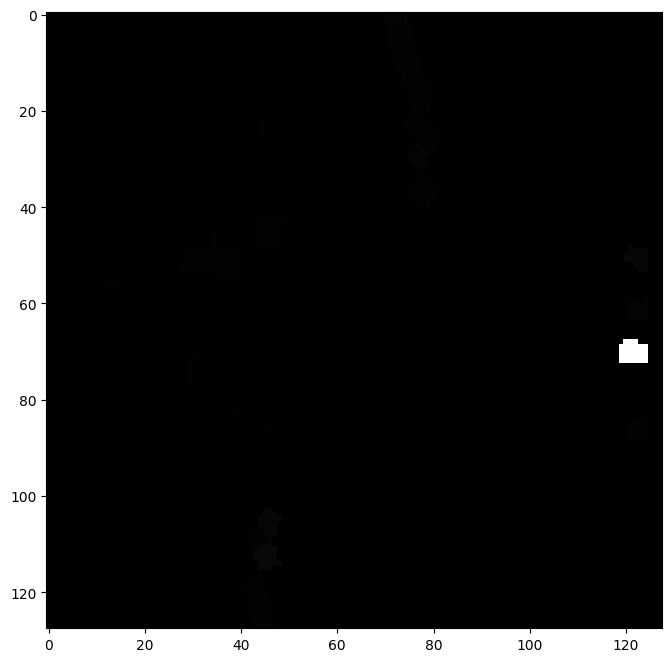

In [163]:
plt.figure(figsize=(15, 8))
plt.imshow(phantom_image_mod, cmap='gray')
phantom_image_mod.shape

In [164]:
# phantom_image = remove_zero_pad(phantom_image)
# phantom_image.shape

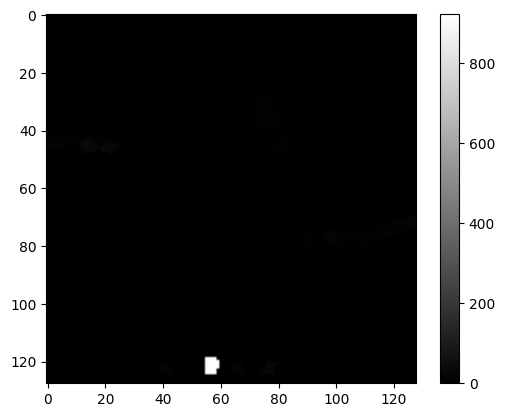

In [165]:
# phantom_image1 = tf.image.resize(phantom_image, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
phantom_image_mod1 = tf.image.rot90(phantom_image_mod,3)
plt.imshow(phantom_image_mod1, cmap='gray')
plt.colorbar()

### Scaling contrast

In [166]:
mike_mod1 = phantom_image_mod1

In [167]:
nn_mod1 = mod_image[0]

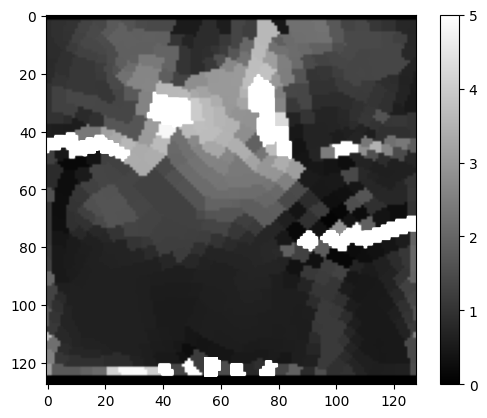

In [168]:
plt.imshow(mike_mod1, cmap='gray')
plt.clim(0,5)
plt.colorbar()

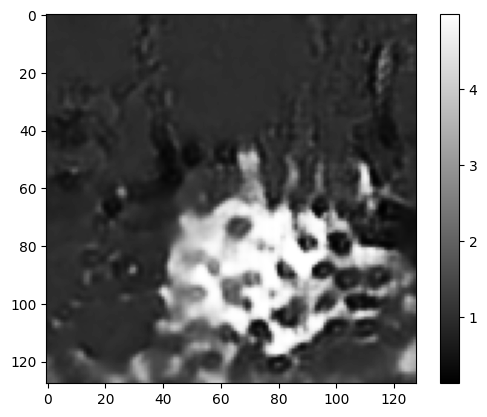

In [169]:
plt.imshow(nn_mod1, cmap='gray')
plt.colorbar()

In [170]:
# for nn image

In [171]:
nn_mod = nn_mod1.numpy()
val = filters.threshold_otsu(nn_mod)
# plt.imshow(nn_mod < val, cmap='gray', interpolation='nearest')
# plt.colorbar()

In [172]:
mean_of_background = nn_mod[nn_mod < val].mean()
print('Bg:',mean_of_background)
mean_of_foreground = nn_mod[nn_mod > val].mean()
print('Fg:',mean_of_foreground)
contrast=mean_of_foreground/mean_of_background
print('contrast =',contrast)

Bg: 1.0465789
Fg: 3.935411
contrast = 3.7602623


In [173]:
nn_mod_scaled = nn_mod*1.0/mean_of_background

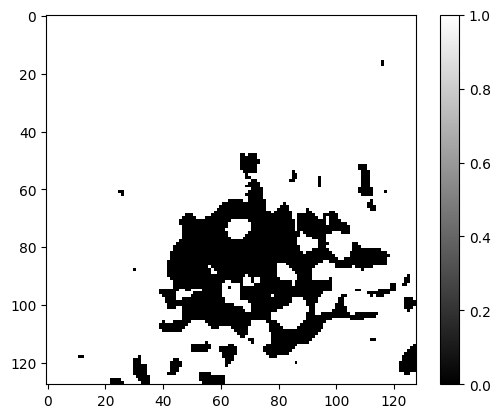

In [174]:
val_scaled = filters.threshold_otsu(nn_mod_scaled)
plt.imshow(nn_mod_scaled < val_scaled, cmap='gray', interpolation='nearest')
plt.colorbar()

In [175]:
mean_of_background1 = nn_mod_scaled[nn_mod_scaled < val_scaled].mean()
print('Bg:',mean_of_background1)
mean_of_foreground1 = nn_mod_scaled[nn_mod_scaled > val_scaled].mean()
print('Fg:',mean_of_foreground1)
contrast1=mean_of_foreground1/mean_of_background1
print('contrast =',contrast1)

Bg: 1.0
Fg: 3.760262
contrast = 3.760262


In [176]:
# for mike mod image

In [177]:
plt.imshow(mike_mod, cmap='gray', interpolation='nearest')
plt.colorbar()

NameError: name 'mike_mod' is not defined

In [ ]:
removed = remove_zero_pad(mike_mod)
removed = tf.image.resize(removed, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
plt.imshow(removed, cmap='gray', interpolation='nearest')
plt.colorbar()

In [ ]:
mike_mod = mike_mod1.numpy()
val2 = filters.threshold_otsu(mike_mod)
print(val2)
plt.imshow(mike_mod < val2, cmap='gray', interpolation='nearest')
plt.colorbar()

In [ ]:
mean_of_background_mike = mike_mod[mike_mod < val2].mean()
print('Bg:',mean_of_background_mike)
mean_of_foreground_mike = mike_mod[mike_mod > val2].mean()
print('Fg:',mean_of_foreground_mike)
contrast_mike=mean_of_foreground_mike/mean_of_background_mike
print('contrast =',contrast_mike)

In [ ]:
mike_mod_scaled = mike_mod*1.0/mean_of_background_mike

In [ ]:
val2_scaled = filters.threshold_otsu(mike_mod_scaled)

In [ ]:
mean_of_background_mike1 = mike_mod_scaled[mike_mod_scaled < val2_scaled].mean()
print('Bg:',mean_of_background_mike1)
mean_of_foreground_mike1 = mike_mod_scaled[mike_mod_scaled > val2_scaled].mean()
print('Fg:',mean_of_foreground_mike1)
contrast_mike1=mean_of_foreground_mike1/mean_of_background_mike1
print('contrast =',contrast_mike1)

In [ ]:
plt.tight_layout()
def plot_images_4(disp, mod, mike_mod, save='off',map_color='gray'):
    strain = np.gradient(disp, axis=0)
    # strain = normalize(strain)
    
    display_list = [disp, mod, mike_mod, strain]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', f'NN Mod, Contrast={contrast1:.3f}', f'ITR Mod, Constrast {contrast_mike1:.3f}', 'Strain'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==1:
            plt.imshow(display_list[i], cmap=map_color)#, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.gca().invert_yaxis()
            plt.clim(0,5)
            plt.colorbar(location='bottom',pad=0.1)
        elif i==2:
            plt.imshow(display_list[i], cmap=map_color)
            plt.colorbar(location='bottom',pad=0.1)
            plt.clim(0,5)
        else:
            plt.imshow(display_list[i], cmap=map_color)
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1)
            
        plt.axis('on')
    # plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled, save='off',map_color='gray' )

In [ ]:
plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled, save='off',map_color='bwr' )

In [ ]:
plt.subplot(1, 2, 1)
plt.title('File: 4h6-1, Position: 3')
plt.imshow(nn_mod_scaled < val_scaled, cmap='gray', interpolation='nearest')
plt.gca().invert_yaxis()
# plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(mike_mod_scaled < val2_scaled, cmap='gray', interpolation='nearest')
# plt.colorbar()

### Phantom predictions and comparison

In [90]:
results_plots_folder_name = 'phantom_rick'

In [91]:
def process_phantom_image(phantom_image, again_normalise = True):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]
    # file_name = file_name.split('/')[-2]
    print('file_name:',file_name)

    # if file_name[2] == '3':
    #     size = (118,1824)
    # elif file_name[2] == '4':
    #     size = (128,1775)
    # else:
    #     print('invalid size')

    phantom_image = load2(img,size=(128,1979)) #2162))
    # print('Original phantom size:',phantom_image.shape)
    phantom_image = remove_zero_pad(phantom_image)
    # print('Removed zeroes phantom size:',phantom_image.shape)
    phantom_image1 = tf.image.resize(phantom_image, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
    phantom_image1 = normalize(phantom_image1)
    if again_normalise == True:
        phantom_image1 = normalize2(phantom_image1)
    phantom_image2 = tf.image.rot90(phantom_image1,1)
    # phantom_image3 = tf.image.flip_left_right(phantom_image2)
    phantom_image3 = phantom_image2
    # print('NN input phantom size:',phantom_image3.shape)
    phantom_image4 = phantom_image3
    mod_image = generator(phantom_image4[tf.newaxis, ...], training=False)
    output = np.reshape(mod_image, (128,128))
    file_name2 = f"data_phantom/predictions_raw/{results_plots_folder_name}/{file_name}.raw"
    with open(file_name2, 'wb') as fp:     
        output.tofile(fp)
    fp.close()
    return phantom_image4, mod_image, file_name

In [92]:
def process_phantom_recon(recon_image):
    img_mike = recon_image
    phantom_image_mod = load2(img_mike,size=(128,128))
    phantom_image_mod1 = tf.image.rot90(phantom_image_mod,3)
    phantom_image_mod2 = tf.image.flip_left_right(phantom_image_mod1)
    removed = remove_zero_pad(phantom_image_mod2)
    phantom_image_mod2 = tf.image.resize(removed, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
    return phantom_image_mod2

In [93]:
def threshold_mask(nn_mod):
    val = filters.threshold_otsu(nn_mod)
    mean_of_background = nn_mod[nn_mod < val].mean()
    print('Bg:',mean_of_background)
    mean_of_foreground = nn_mod[nn_mod > val].mean()
    print('Fg:',mean_of_foreground)
    contrast=mean_of_foreground/mean_of_background
    print('contrast =',contrast)
    return mean_of_background, val, contrast

In [94]:
def scale_contrast(nn_mod1):
    nn_mod = nn_mod1.numpy()
    mean_of_background,val,c = threshold_mask(nn_mod)
    nn_mod_scaled = nn_mod*1.0/mean_of_background
    mean_of_background_scaled,val,c = threshold_mask(nn_mod_scaled)
    return nn_mod_scaled, mean_of_background_scaled, val, c

In [95]:
plt.tight_layout()
def plot_images_4(disp, mod, mike_mod,contrast_nn,contrast_mike, save='off',map_color='gray'):
    strain = np.gradient(disp, axis=0)
    # strain = normalize(strain)
    
    display_list = [disp,strain, mod, mike_mod]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', 'Strain', f'NN Mod, Contrast={contrast_nn:.3f}', f'ITR Mod, Constrast {contrast_mike:.3f}'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==2:
            plt.imshow(display_list[i], cmap=map_color)#, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.gca().invert_yaxis()
            # plt.clim(0,5)
            plt.colorbar(location='bottom',pad=0.1)

            # # Create a second y-axis
            # ax2 = plt.gca().twinx()
            
            # # Example: Overlaying a line plot on the secondary y-axis
            # x = np.linspace(0, 128*3.78/128, 8)
            # y = np.linspace(0, 128*3.78/128, 8)
            # # ax2.plot(x, y, 'r-', label='Additional Data')
            # ax2.set_ylabel('Additional Y-axis', color='r')
            # ax2.set_xlabel('Additional Y-axis', color='r')
            # ax2.tick_params('y', colors='r')
            # ax2.tick_params('x', colors='r')
            
            # # Show colorbar
            # # plt.colorbar(location='bottom', pad=0.1)
            # # plt.show()
    
        elif i==3:
            plt.imshow(display_list[i], cmap=map_color)
            plt.colorbar(location='bottom',pad=0.1)
            # plt.clim(0,5)
        elif i==1:
            plt.imshow(display_list[i], cmap='autumn')
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1) #.set_ticks(np.array([-0.010,-0.0075,-0.0025]))            
        else:
            plt.imshow(display_list[i], cmap='jet')
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1)
            
        plt.axis('on')
    # plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [96]:
def plot_thresholdmap(file_name,nn_mod_scaled, val_scaled, mike_mod_scaled, val2_scaled):
    plt.subplot(1, 2, 1)
    plt.title(f'NN, pos: {file_name}')
    plt.imshow(nn_mod_scaled < val_scaled, cmap='gray', interpolation='nearest')
    plt.gca().invert_yaxis()
    # plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title(f'ITR, pos: {file_name}')
    plt.imshow(mike_mod_scaled < val2_scaled, cmap='gray', interpolation='nearest')
    # plt.colorbar()
    # plt.show()
    plt.savefig(f'a_results_for_paper/{results_plots_folder_name}/map_{file_name}.png')   # save the figure to file
    plt.close()

In [97]:
def plot_it(counter,disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    
    file_num = counter
    if 1 <= file_num <=20:
        climlim_lower = 1
        climlim = 5
    elif 21 <= file_num <=80:
        climlim_lower = 0
        climlim = 2
    elif 81 <= file_num <=100:
        climlim_lower = 1
        climlim = 4
    elif 101 <= file_num <=180:
        climlim_lower = 0
        climlim = 2

    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig.tight_layout()
    
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement: {file_name}')
    ax1.invert_yaxis()
    fig.colorbar(im1,orientation='horizontal',fraction=0.046, pad=0.09)

    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain')
    ax11.invert_yaxis()
    # ax11.set_yticks([])
    fig.colorbar(im11,orientation='horizontal',fraction=0.046, pad=0.09)

    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Modulus, Contrast={c_nn:.3f}')
    im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])
    fig.colorbar(im2,orientation='horizontal',fraction=0.046, pad=0.09)

    im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # ax.invert_yaxis()
    # ax3.set_xlabel('pixel')
    # ax3.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax3.title.set_text(f'DL Modulus, Contrast={c_mike:.3f}')
    # im3.set_clim(0, climlim)
    ax3.invert_yaxis()
    ax3.set_yticks([])
    fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)

    fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}.png')   # save the figure to file
    plt.close(fig) 

In [108]:
# phantom_images_path = 'data_phantom/apples/sim/disp/*Inclusion10*.raw'
# phantom_images_path = 'data_phantom/apples/phantom_reg12_10k/disp/*.raw'
# phantom_images_path = 'data_phantom/ExpData_7_27_2021/*/uy*.raw'
phantom_images_path = 'data_phantom/apples/phantom_rick-alpha1e-5/*.raw'

In [109]:
# recon_image_path = 'data_phantom/apples/sim/itr_mod/Inclusion10*_mod.raw'
# recon_image_path = 'data_phantom/apples/phantom_legendary/itr_mod/*_mod.raw'
recon_image_path = phantom_images_path

In [110]:
phantom_images = glob.glob(phantom_images_path)
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
phantom_images.sort()
len(phantom_images)

3600

In [171]:
recon_images = glob.glob(recon_image_path)
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
recon_images.sort()
# recon_images

In [172]:
# phantom_images = glob.glob('data_phantom/apples/liver*.raw')
# phantom_images.sort()
# phantom_images

In [173]:
# i=0

In [174]:
len(phantom_images), len(recon_images)

(180, 180)

In [177]:
for i in range(len(phantom_images)):
    phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], False)
    # phantom_image_mod1 = process_phantom_recon(recon_images[i])
    mike_mod1 = mod_image[0]
    nn_mod1 = mod_image[0]
    nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
    print('mean_of_background_scaled_nn',mean_of_background_scaled)
    mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
    print('mean_of_background_scaled_mike',mean_of_background_scaled2)
    # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
    plot_it(i+1,phantom_image4, nn_mod1,nn_mod_scaled,c_nn,c_mike,f_name)
    plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
    # break

file_name: 10-44-19_1
Bg: 0.14489178
Fg: 0.66106325
contrast = 4.562462
Bg: 0.9999999
Fg: 4.5624623
contrast = 4.562463
mean_of_background_scaled_nn 0.9999999
Bg: 0.14489178
Fg: 0.66106325
contrast = 4.562462
Bg: 0.9999999
Fg: 4.5624623
contrast = 4.562463
mean_of_background_scaled_mike 0.9999999
file_name: 10-44-19_2
Bg: 0.1473152
Fg: 0.63820964
contrast = 4.3322725
Bg: 1.0000001
Fg: 4.332272
contrast = 4.3322716
mean_of_background_scaled_nn 1.0000001
Bg: 0.1473152
Fg: 0.63820964
contrast = 4.3322725
Bg: 1.0000001
Fg: 4.332272
contrast = 4.3322716
mean_of_background_scaled_mike 1.0000001
file_name: 10-44-19_3
Bg: 0.15438688
Fg: 0.65349764
contrast = 4.232857
Bg: 1.0000001
Fg: 4.2328568
contrast = 4.2328563
mean_of_background_scaled_nn 1.0000001
Bg: 0.15438688
Fg: 0.65349764
contrast = 4.232857
Bg: 1.0000001
Fg: 4.2328568
contrast = 4.2328563
mean_of_background_scaled_mike 1.0000001
file_name: 10-44-19_4
Bg: 0.14930767
Fg: 0.61842066
contrast = 4.1419215
Bg: 1.0
Fg: 4.1419215
contrast 

In [ ]:
## For legendary data

In [239]:
def process_phantom_image_legend(phantom_image, again_normalise = False):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]

    file_name = file_name.split('/')[-2]
    print('file_name:',file_name)

    phantom_image = load(img)#,size=(128,128)) #2162))
    # # print('Original phantom size:',phantom_image.shape)
    # phantom_image = remove_zero_pad(phantom_image)
    # # print('Removed zeroes phantom size:',phantom_image.shape)
    # phantom_image1 = tf.image.resize(phantom_image, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
    phantom_image1 = normalize(phantom_image)
    if again_normalise == True:
        phantom_image1 = normalize2(phantom_image1)
    # phantom_image2 = tf.image.rot90(phantom_image1,1)
    # # phantom_image3 = tf.image.flip_left_right(phantom_image2)
    # phantom_image3 = phantom_image2
    # # print('NN input phantom size:',phantom_image3.shape)
    phantom_image4 = phantom_image1
    mod_image = generator(phantom_image4[tf.newaxis, ...], training=False)
    output = np.reshape(mod_image, (128,128))
    file_name2 = f"data_phantom/predictions_raw/patient/phantom1_{file_name}.raw"
    with open(file_name2, 'wb') as fp:     
        output.tofile(fp)
    fp.close()
    return phantom_image1, mod_image, file_name

In [240]:
# # phantom_legendary
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image_legend(phantom_images[i], False)
#     phantom_image_mod1 = process_phantom_recon(recon_images[i])
#     mike_mod1 = phantom_image_mod1
#     nn_mod1 = mod_image[0]
#     nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
#     print('mean_of_background_scaled_nn',mean_of_background_scaled)
#     mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
#     print('mean_of_background_scaled_mike',mean_of_background_scaled2)
#     # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
#     plot_it(i,phantom_image4, nn_mod1,nn_mod1,c_nn,c_mike,f_name)
#     plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
#     # break

file_name: 1
Bg: 1.062461
Fg: 4.107942
contrast = 3.8664403
Bg: 1.0
Fg: 3.86644
contrast = 3.86644
mean_of_background_scaled_nn 1.0
Bg: -0.009220412
Fg: -0.004421134
contrast = 0.47949418
Bg: 0.47646096
Fg: 0.99645084
contrast = 2.091359
mean_of_background_scaled_mike 0.47646096
file_name: 10
Bg: 0.94605523
Fg: 1.4008658
contrast = 1.4807442
Bg: 1.0000001
Fg: 1.480744
contrast = 1.4807439
mean_of_background_scaled_nn 1.0000001
Bg: -0.014819974
Fg: -0.0059738695
contrast = 0.4030958
Bg: 0.40071923
Fg: 0.99679375
contrast = 2.4875116
mean_of_background_scaled_mike 0.40071923
file_name: 11
Bg: 0.8615696
Fg: 1.4839175
contrast = 1.722342
Bg: 1.0
Fg: 1.7223421
contrast = 1.7223421
mean_of_background_scaled_nn 1.0
Bg: -0.017504575
Fg: -0.005039806
contrast = 0.28791365
Bg: 0.2856221
Fg: 0.9966104
contrast = 3.4892623
mean_of_background_scaled_mike 0.2856221
file_name: 12
Bg: 0.8927607
Fg: 1.7293372
contrast = 1.9370669
Bg: 0.99999994
Fg: 1.937067
contrast = 1.9370672
mean_of_background_scale

In [167]:
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], True)
#     phantom_image_mod1 = process_phantom_recon(recon_images[i])
#     mike_mod1 = phantom_image_mod1
#     nn_mod1 = mod_image[0]
#     nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
#     print('mean_of_background_scaled_nn',mean_of_background_scaled)
#     mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
#     print('mean_of_background_scaled_mike',mean_of_background_scaled2)
#     # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
#     plot_it(phantom_image4, nn_mod_scaled,mike_mod_scaled,c_nn,c_mike,f_name)
#     plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
#     # break

In [339]:
# plot_it(phantom_image4, nn_mod_scaled,mike_mod_scaled,c_nn,c_mike)

In [340]:
def plot_it(disp, nn_mod, mike_mod, c_nn,c_mike, size=128, trans_width=3.78):
    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig.tight_layout()
    
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text('Hassan Displacement')
    ax1.invert_yaxis()
    fig.colorbar(im1,orientation='horizontal',fraction=0.046, pad=0.09)

    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain')
    ax11.invert_yaxis()
    # ax11.set_yticks([])
    fig.colorbar(im11,orientation='horizontal',fraction=0.046, pad=0.09)

    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Modulus, Contrast={c_nn:.3f}')
    im2.set_clim(0,5)
    ax2.invert_yaxis()
    # ax2.set_yticks([])
    fig.colorbar(im2,orientation='horizontal',fraction=0.046, pad=0.09)

    im3 = ax3.imshow(mike_mod, aspect='equal',cmap='bwr')
    # ax.invert_yaxis()
    # ax3.set_xlabel('pixel')
    # ax3.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax3.title.set_text(f'ITR Modulus, Contrast={c_mike:.3f}')
    im3.set_clim(0, 5)
    # ax3.invert_yaxis()
    ax3.set_yticks([])
    fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)
    fig.savefig('path/to/save/image/to.png')   # save the figure to file
    plt.close(fig) 

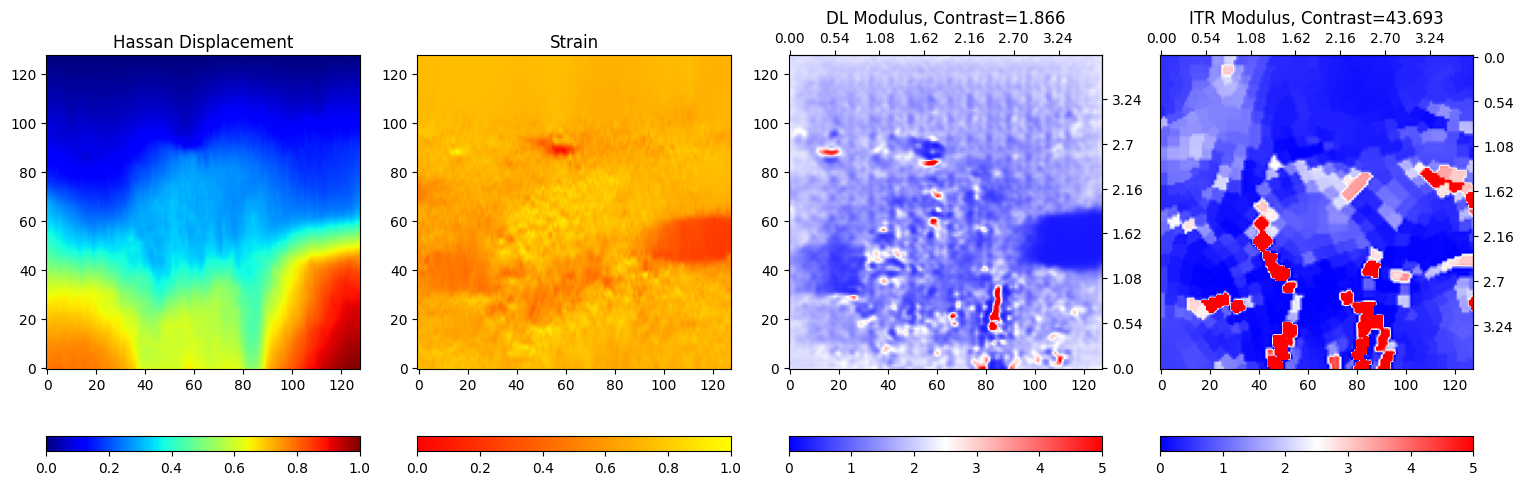

In [341]:
plot_it(phantom_image4, nn_mod_scaled,mike_mod_scaled,c_nn,c_mike)

In [ ]:

phantom_image = remove_zero_pad(phantom_image)
phantom_image1 = normalize(phantom_image1)
phantom_image2 = tf.image.rot90(phantom_image1,1)
phantom_image3 = tf.image.flip_left_right(phantom_image2)
phantom_image4 = normalize(phantom_image3)
mod_image = generator(phantom_image4[tf.newaxis, ...], training=False)

In [220]:
plt.tight_layout()
def plot_images8(disp, mod, save='off'):
    strain = np.gradient(disp, axis=0)
    # strain = normalize(strain)
    
    display_list = [disp, mod, strain]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', 'Predicted Modulus', 'Strain'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==1:
            plt.imshow(display_list[i], cmap='gray')#, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.gca().invert_yaxis()
            plt.clim(1,5)
            plt.colorbar(location='bottom',pad=0.1)
        else:
            plt.imshow(display_list[i], cmap='gray')
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1)
            
        plt.axis('on')
    # plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

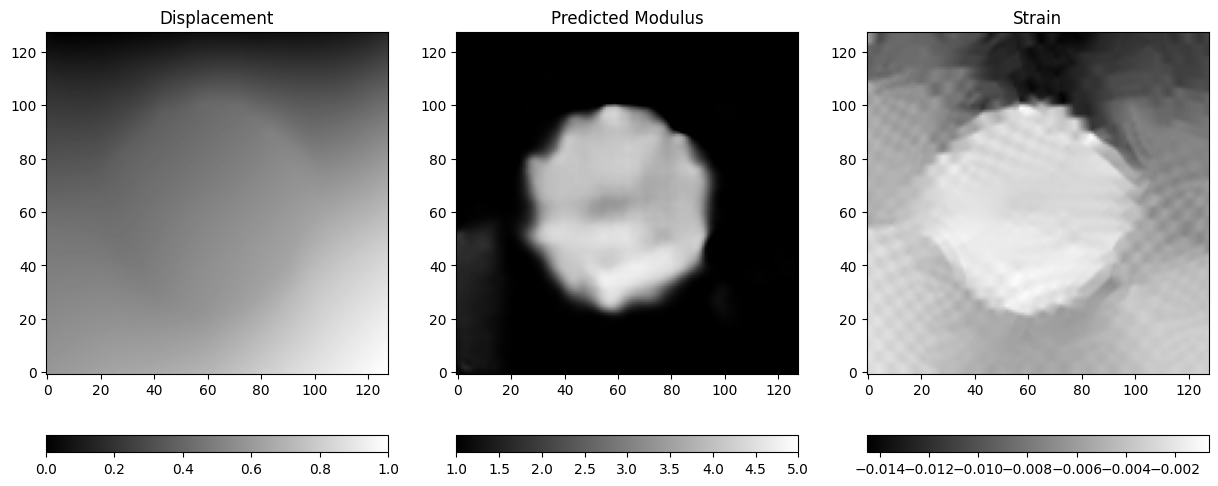

In [221]:
plot_images8(phantom_image4,mod_image[0],file_name)

In [ ]:
output = np.reshape(mod_image, (128,128))
file_name = f"data_phantom/predictions_raw/4h6-1_2.raw"
with open(file_name, 'wb') as fp:     
    output.tofile(fp)
fp.close()

In [229]:
phantom_images = glob.glob('data_phantom/apples/*_x.raw')
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
phantom_images.sort()
phantom_images

['data_phantom/apples/raw_4h6-1_0_x.raw',
 'data_phantom/apples/raw_4h6-1_1_x.raw',
 'data_phantom/apples/raw_4h6-1_2_x.raw',
 'data_phantom/apples/raw_4h6-1_3_x.raw',
 'data_phantom/apples/raw_4h6-1_4_x.raw']

In [230]:
img = phantom_images[-1]
img

'data_phantom/apples/raw_4h6-1_4_x.raw'

In [231]:
file_name = img.split('_')[-2]
phantom_image = load2(img,size=(128,1997))
phantom_image = remove_zero_pad(phantom_image)
phantom_image1 = tf.image.resize(phantom_image, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
phantom_image1 = normalize(phantom_image1)
phantom_image2 = tf.image.rot90(phantom_image1,1)
phantom_image3 = tf.image.flip_left_right(phantom_image2)
phantom_image4 = normalize(phantom_image3)
mod_image = generator(phantom_image4[tf.newaxis, ...], training=False)

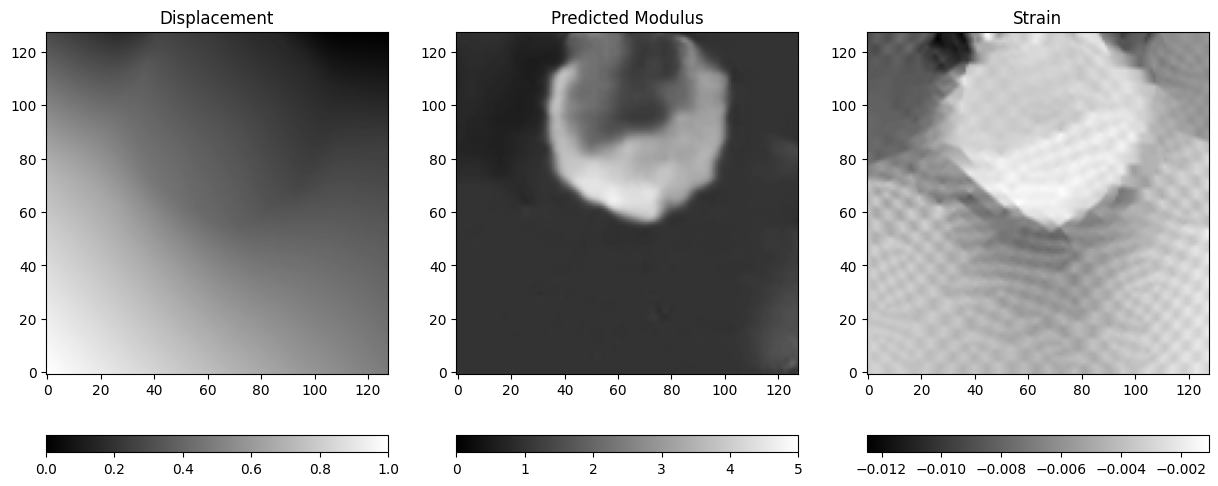

In [232]:
plot_images8(phantom_image4,mod_image[0],file_name)

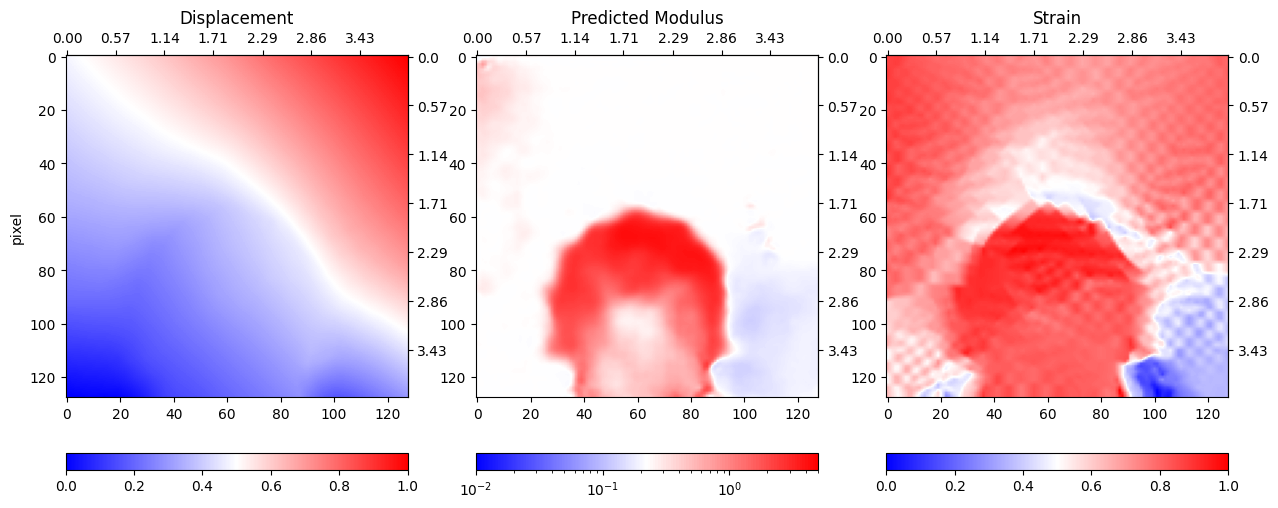

In [389]:
plot_it(phantom_image4, mod_image[0])

In [275]:
plt.tight_layout()
def plot_images(disp, mod, save='off'):
    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)
    
    display_list = [disp, mod, strain]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', 'Predicted Modulus', 'Strain'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(10, 4))
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==1:
            plot_it(display_list[i])
        else:
            plot_it(display_list[i])    
        plt.axis('on')
    plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

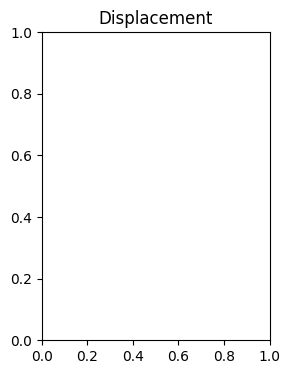

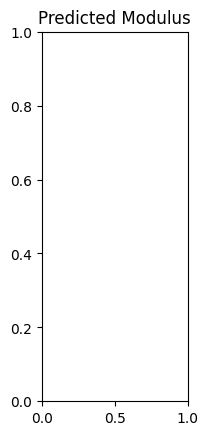

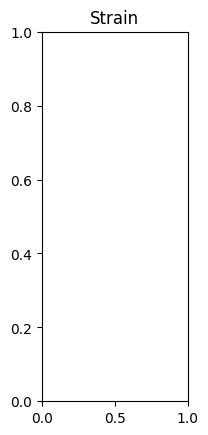

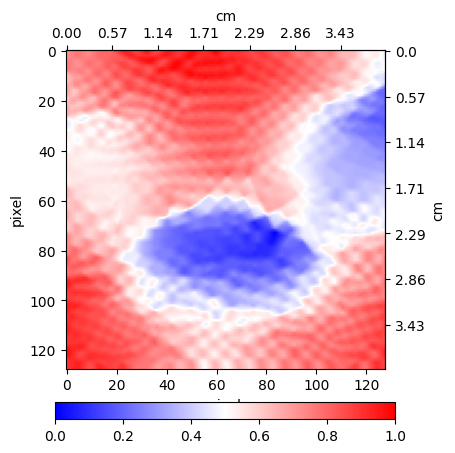

In [276]:
plot_images(phantom_image3,mod_image[0],file_name)

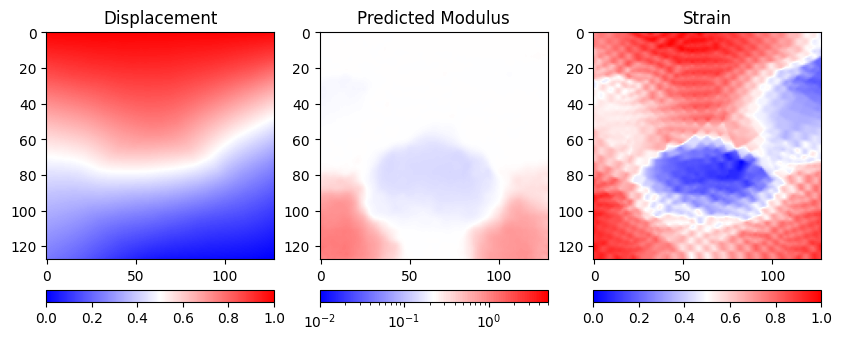

In [141]:
phantom_images = glob.glob('data_phantom/ExpData_7_27_2021/*/uy*.raw')

In [142]:
phantom_images

['data_phantom/ExpData_7_27_2021/21/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/19/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/8/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/27/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/3/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/15/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/9/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/31/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/36/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/20/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/12/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/39/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/10/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/34/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/2/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/43/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/38/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/4/uy_128x128.raw',
 'data_phantom/ExpData_7_27_2021/42/uy_128x128.raw'

In [164]:
phantom_images[4]

'data_phantom/ExpData_7_27_2021/3/uy_128x128.raw'

In [165]:
old_phantom = load(phantom_images[4])
old_phantom = normalize(old_phantom)

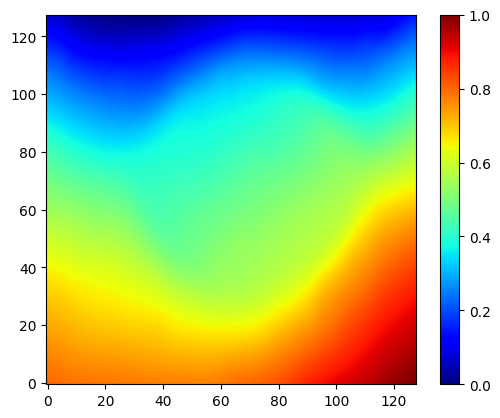

In [166]:
plt.imshow(old_phantom, cmap = 'jet')
plt.gca().invert_yaxis()
plt.colorbar()

In [167]:
mod = generator(old_phantom[tf.newaxis, ...], training=False)

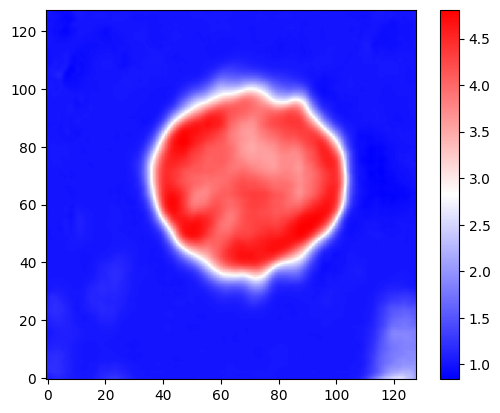

In [168]:
plt.imshow(mod[0],cmap='bwr')
plt.gca().invert_yaxis()
plt.colorbar()

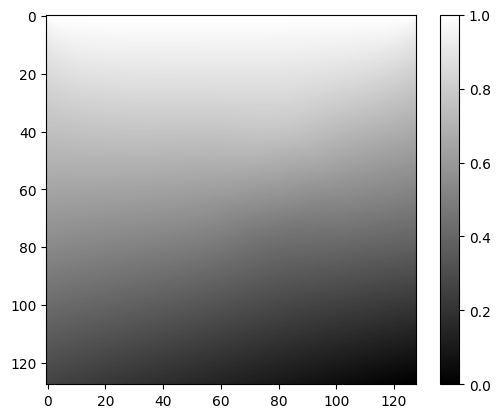

In [137]:
plt.imshow(inp, cmap='gray')
plt.colorbar()

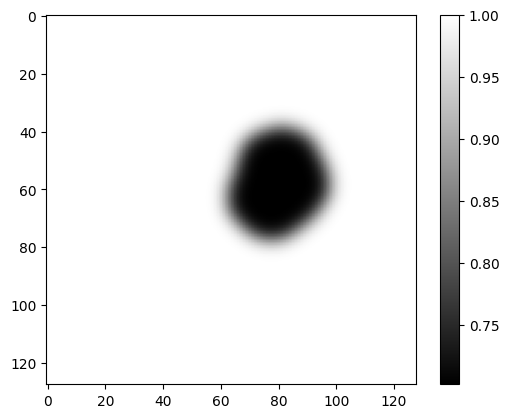

In [138]:
plt.imshow(re, cmap='gray')
plt.colorbar()

In [139]:
pred = generator(inp[tf.newaxis, ...], training=False)

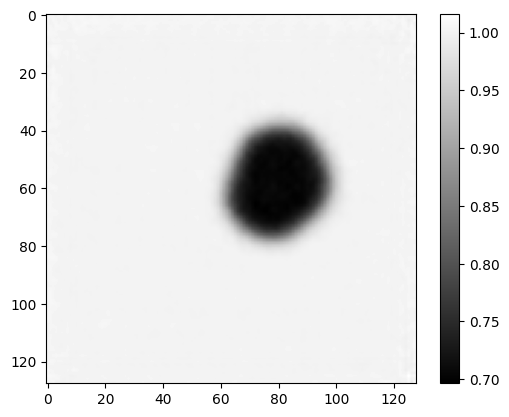

In [140]:
plt.imshow(pred[0],cmap='gray')
plt.colorbar()

In [173]:
mod_image = generator(phantom_image[tf.newaxis, ...], training=False)

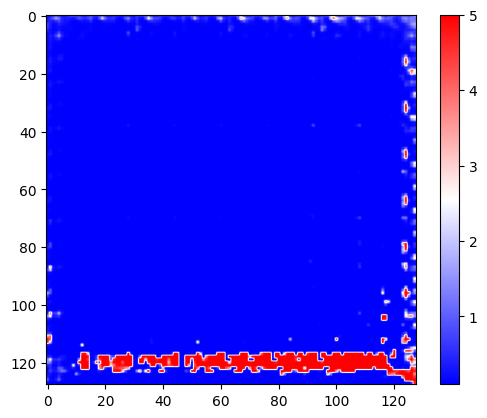

In [174]:
plt.imshow(mod_image[0],cmap='bwr')
plt.colorbar()

### Phantom predictions and no comparison

In [91]:
results_plots_folder_name = 'new_phantom_rick_paper_12_time'

In [92]:
a_results_for_paper_dir = 'a_results_for_paper/' + results_plots_folder_name
a_results_for_paper_dir

'a_results_for_paper/new_phantom_rick_paper_12_time'

In [93]:
os.mkdir(a_results_for_paper_dir) if not os.path.isdir(a_results_for_paper_dir) else None
# folders = [str(i) for i in range(2,82)]
# for folder in folders:
#     if(not os.path.isdir(f'{a_results_for_paper_dir}/{folder}')):
#         os.mkdir(f'{a_results_for_paper_dir}/{folder}')

In [94]:
def process_phantom_recon(recon_image):
    img_mike = recon_image
    phantom_image_mod = load2(img_mike,size=(128,128))
    phantom_image_mod1 = tf.image.rot90(phantom_image_mod,3)
    phantom_image_mod2 = tf.image.flip_left_right(phantom_image_mod1)
    removed = remove_zero_pad(phantom_image_mod2)
    phantom_image_mod2 = tf.image.resize(removed, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
    return phantom_image_mod2

In [95]:
def calculate_cnr(st, sdt, sp, sdp):
    cnr = 2*((st-sp)**2)/(sdt**2+sdp**2)
    cnr = np.sqrt(cnr)
    return cnr

In [96]:
def get_hardness(inclusion_number):
    if ((int(inclusion_number)>= 1.0) & (int(inclusion_number) <= 5.0)):
        climlim = 5
    elif (int(inclusion_number) >= 6.0) & (int(inclusion_number) <= 10.0):
        climlim = 5
    elif (int(inclusion_number)>= 11.0) & (int(inclusion_number) <= 15.0):
        climlim = 2 
    elif (int(inclusion_number) >= 16.0) & (int(inclusion_number) <= 20.0):
        climlim = 2
    elif (int(inclusion_number) >= 21.0) & (int(inclusion_number) <= 25.0):
        climlim = 5
    elif (int(inclusion_number) >= 26.0) & (int(inclusion_number) <= 30.0):
        climlim = 5
    elif (int(inclusion_number) >= 31.0) & (int(inclusion_number) <= 35.0):
        climlim = 2
    elif (int(inclusion_number) >= 36.0) & (int(inclusion_number) <= 40.0):
        climlim = 2
    elif (int(inclusion_number) >= 41.0) & (int(inclusion_number) <= 45.0):
        climlim = 5
    else:
        print('Inccusion number',inclusion_number)
    return climlim

In [97]:
def threshold_mask(nn_mod, f_name, p):
    print(nn_mod[:,:100].shape)
    inclusion_number = f_name.split('_')[0]
    climlim = get_hardness(inclusion_number)
    if climlim == 2:
        # print('yo thiyo',nn_mod.shape)
        val = filters.threshold_otsu(nn_mod)
        if p == 1:
            val = filters.threshold_otsu(nn_mod[0:100,:])
        # print('Yo bhayo',nn_mod.shape)
        mean_of_foreground = nn_mod[nn_mod < val].mean()
        print('Bg(Soft):',mean_of_foreground)
        mean_of_background = nn_mod[nn_mod > val].mean()
        print('Fg(Soft):',mean_of_background)
        contrast= (mean_of_foreground-mean_of_background)/mean_of_background
        print('contrast =',contrast)
        std_of_foreground = nn_mod[nn_mod < val].std()
        std_of_background = nn_mod[nn_mod > val].std()
    else:   
        # print('yo thiyo',nn_mod.shape)
        val = filters.threshold_otsu(nn_mod)
        if p == 1:
            val = filters.threshold_otsu(nn_mod[0:100,:])
        # print('Yo bhayo',nn_mod.shape)
        mean_of_background = nn_mod[nn_mod < val].mean()
        print('Bg:(Hard)',mean_of_background)
        mean_of_foreground = nn_mod[nn_mod > val].mean()
        print('Fg:(Hard)',mean_of_foreground)
        contrast=(mean_of_foreground-mean_of_background)/mean_of_background
        print('contrast =',contrast)
        std_of_background = nn_mod[nn_mod < val].std()
        std_of_foreground = nn_mod[nn_mod > val].std()
    
    cnr = calculate_cnr(mean_of_foreground, std_of_foreground, mean_of_background, std_of_background)

    
    # inclusion_number = f_name.split('_')[0]
    # climlim = get_climlim(inclusion_number)
    # if climlim == 2:
    #     mean_of_background = mean_of_foreground
    return mean_of_background, val, contrast, cnr

In [98]:
def scale_contrast(nn_mod1, f_name, p):
    nn_mod = nn_mod1.numpy()
    # nn_mod = np.log(nn_mod)
    mean_of_background,val,c,cnr = threshold_mask(nn_mod, f_name, p)
    nn_mod_scaled = nn_mod*1.0/mean_of_background
    mean_of_background_scaled,val,c,cnr = threshold_mask(nn_mod_scaled, f_name, p)
    return nn_mod_scaled, mean_of_background_scaled, val, c,cnr

In [99]:
plt.tight_layout()
def plot_images_4(disp, mod, mike_mod,contrast_nn,contrast_mike, save='off',map_color='gray'):
    strain = np.gradient(disp, axis=0)
    # strain = normalize(strain)
    
    display_list = [disp,strain, mod, mike_mod]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', 'Strain', f'NN Mod, Contrast={contrast_nn:.3f}', f'ITR Mod, Constrast {contrast_mike:.3f}'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==2:
            plt.imshow(display_list[i], cmap=map_color)#, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.gca().invert_yaxis()
            # plt.clim(0,5)
            plt.colorbar(location='bottom',pad=0.1)

            # # Create a second y-axis
            # ax2 = plt.gca().twinx()
            
            # # Example: Overlaying a line plot on the secondary y-axis
            # x = np.linspace(0, 128*3.78/128, 8)
            # y = np.linspace(0, 128*3.78/128, 8)
            # # ax2.plot(x, y, 'r-', label='Additional Data')
            # ax2.set_ylabel('Additional Y-axis', color='r')
            # ax2.set_xlabel('Additional Y-axis', color='r')
            # ax2.tick_params('y', colors='r')
            # ax2.tick_params('x', colors='r')
            
            # # Show colorbar
            # # plt.colorbar(location='bottom', pad=0.1)
            # # plt.show()
    
        elif i==3:
            plt.imshow(display_list[i], cmap=map_color)
            plt.colorbar(location='bottom',pad=0.1)
            # plt.clim(0,5)
        elif i==1:
            plt.imshow(display_list[i], cmap='autumn')
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1) #.set_ticks(np.array([-0.010,-0.0075,-0.0025]))            
        else:
            plt.imshow(display_list[i], cmap='jet')
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1)
            
        plt.axis('on')
    # plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [100]:
def plot_thresholdmap(file_name,nn_mod_scaled, val_scaled, c_nn,p_value):
    plt.subplot(1, 1, 1)
    plt.title(f'NN, :{file_name}, C={c_nn:.3f}')
    plt.imshow(nn_mod_scaled < val_scaled, cmap='gray', interpolation='nearest')
    plt.gca().invert_yaxis()
    # plt.colorbar()
    # plt.subplot(1, 2, 2)
    # plt.title(f'ITR, pos: {file_name}')
    # plt.imshow(mike_mod_scaled < val2_scaled, cmap='gray', interpolation='nearest')
    # plt.colorbar()
    # plt.show()
    plt.savefig(f'a_results_for_paper/{results_plots_folder_name}/map_{file_name}_{p_value}.png')   # save the figure to file
    # plt.show()
    plt.close()

In [101]:
def plot_it(counter,disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    
    file_num = counter
    if 1 <= file_num <=5:
        climlim_lower = 1
        climlim = 5
    elif 21 <= file_num <=20:
        climlim_lower = 0
        climlim = 2
    elif 81 <= file_num <=25:
        climlim_lower = 1
        climlim = 4
    elif 101 <= file_num <=45:
        climlim_lower = 0
        climlim = 2

    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig.tight_layout()
    
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement: {file_name}')
    ax1.invert_yaxis()
    fig.colorbar(im1,orientation='horizontal',fraction=0.046, pad=0.09)

    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain')
    ax11.invert_yaxis()
    # ax11.set_yticks([])
    fig.colorbar(im11,orientation='horizontal',fraction=0.046, pad=0.09)

    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Modulus, Contrast={c_nn:.3f}')
    im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])
    fig.colorbar(im2,orientation='horizontal',fraction=0.046, pad=0.09)

    im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # ax.invert_yaxis()
    # ax3.set_xlabel('pixel')
    # ax3.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax3.title.set_text(f'DL Prediction')
    # im3.set_clim(0, climlim)
    ax3.invert_yaxis()
    ax3.set_yticks([])
    fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)

    fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}.png')   # save the figure to file
    plt.close(fig) 

In [102]:
# phantom_images_path = 'data_phantom/apples/sim/disp/*Inclusion10*.raw'
# phantom_images_path = 'data_phantom/apples/phantom_reg12_10k/disp/*.raw'
# phantom_images_path = 'data_phantom/ExpData_7_27_2021/*/uy*.raw'
# phantom_images_path = 'data_phantom/apples/phantom_rick-strain_after1-windowstudy/*_x.raw'
phantom_images_path = f'data_phantom/apples/phantom_rick-strain_after1-1e-4/*_x.raw'
# phantom_images_path = f'data_phantom/apples/patient/disp/*_x.raw'

In [103]:
# recon_image_path = 'data_phantom/apples/sim/itr_mod/Inclusion10*_mod.raw'
# recon_image_path = 'data_phantom/apples/phantom_legendary/itr_mod/*_mod.raw'
recon_image_path = phantom_images_path

In [104]:
phantom_images = glob.glob(phantom_images_path)
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
phantom_images.sort()
len(phantom_images)

45

In [105]:
# phantom_images

In [106]:
recon_images = glob.glob(recon_image_path)
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
recon_images.sort()
# recon_images

In [107]:
# phantom_images = glob.glob('data_phantom/apples/liver*.raw')
# phantom_images.sort()
# phantom_images

In [108]:
# i=0

In [109]:
len(phantom_images), len(recon_images)

(45, 45)

In [110]:
phantom_images[2]

'data_phantom/apples/phantom_rick-strain_after1-1e-4/raw_12_41_x.raw'

In [111]:
img = phantom_images[2]
file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]
inclusion_number = file_name.split('_')[0][-1]
frame_number = file_name.split('_')[1]
inclusion_number,frame_number

('2', '41')

In [112]:
2864*1.9250e-5/0.3*1000

183.77333333333334

In [126]:
def process_phantom_image(phantom_image, again_normalize = False):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]
    inclusion_number = file_name.split('_')[0]
    frame_number = file_name.split('_')[1]
    # again_norma = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
    #                21,31,32,33,34,35,36,40]
    # if int(inclusion_number) in again_norma:
    #     again_normalize = True
    phantom_image = load2(img,size=(128,2864)) #2162))
    phantom_image = remove_zero_pad(phantom_image)
    phantom_image1 = tf.image.resize(phantom_image,(128,184), method = 'bicubic', preserve_aspect_ratio=False)
    
    phantom_image1_p1_un = phantom_image1[:,0:128]
    phantom_image1_p2_un = phantom_image1[:,0+20:128+20]
    phantom_image1_p3_un = phantom_image1[:,0+40:128+40]
    phantom_image1_p4_un = phantom_image1[:,0+60-4:128+60-4]

    phantom_image1_p1 = normalize(phantom_image1_p1_un)
    phantom_image1_p2 = normalize(phantom_image1_p2_un)
    phantom_image1_p3 = normalize(phantom_image1_p3_un)
    phantom_image1_p4 = normalize(phantom_image1_p4_un)

    if again_normalize == True:
        phantom_image1_p1 = normalize2(phantom_image1_p1)
        phantom_image1_p2 = normalize2(phantom_image1_p2)
        phantom_image1_p3 = normalize2(phantom_image1_p3)
        phantom_image1_p4 = normalize2(phantom_image1_p4)
        
    phantom_image4_p1 = tf.image.rot90(phantom_image1_p1,1)
    phantom_image4_p2 = tf.image.rot90(phantom_image1_p2,1)
    phantom_image4_p3 = tf.image.rot90(phantom_image1_p3,1)
    phantom_image4_p4 = tf.image.rot90(phantom_image1_p4,1)

    start_time = time.time()
    mod_image_p1 = generator(phantom_image4_p1[tf.newaxis, ...], training=False)
    end_time = time.time()
    time_taken1 = end_time - start_time

    start_time = time.time()
    mod_image_p2 = generator(phantom_image4_p2[tf.newaxis, ...], training=False)
    end_time = time.time()
    time_taken2 = end_time - start_time

    start_time = time.time()
    mod_image_p3 = generator(phantom_image4_p3[tf.newaxis, ...], training=False)
    end_time = time.time()
    time_taken3 = end_time - start_time

    start_time = time.time()
    mod_image_p4 = generator(phantom_image4_p4[tf.newaxis, ...], training=False)
    end_time = time.time()
    time_taken4 = end_time - start_time

    phantom_image4_p1_un = tf.image.rot90(phantom_image1_p1_un,1)
    phantom_image4_p2_un = tf.image.rot90(phantom_image1_p2_un,1)
    phantom_image4_p3_un = tf.image.rot90(phantom_image1_p3_un,1)
    phantom_image4_p4_un = tf.image.rot90(phantom_image1_p4_un,1)

    phantom_image4 = []
    phantom_image4.append(phantom_image4_p1_un)
    phantom_image4.append(phantom_image4_p2_un)
    phantom_image4.append(phantom_image4_p3_un)
    phantom_image4.append(phantom_image4_p4_un)
    
    mod_image =[]
    mod_image.append(mod_image_p1)
    mod_image.append(mod_image_p2)
    mod_image.append(mod_image_p3)
    mod_image.append(mod_image_p4)

    time_taken = []
    time_taken.append(time_taken1)
    time_taken.append(time_taken2)
    time_taken.append(time_taken3)
    time_taken.append(time_taken4)
    
    return phantom_image4, mod_image, file_name, time_taken

In [127]:
def process_phantom_image_1(phantom_image, again_normalize = False):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]
    patient_number = file_name.split('_')[0][-1]
    frame_number = file_name.split('_')[1]

    if patient_number == '1':
        img_size_x = 508
        img_size_y = 1964
    elif patient_number == '2':
        img_size_x = 360
        img_size_y = 1965
    elif patient_number == '3':
        img_size_x = 256
        img_size_y = 1891
    elif patient_number == '4':
        img_size_x = 360
        img_size_y = 1965
        again_normalize = True
    phantom_image = load2(img,size=(img_size_x,img_size_y)) #2162))
    phantom_image = remove_zero_pad(phantom_image)
    phantom_image1 = tf.image.resize(phantom_image,(128,128), method = 'bicubic', preserve_aspect_ratio=False)
    phantom_image1_un = tf.image.rot90(phantom_image1,1)
    phantom_image1 = normalize(phantom_image1)
    if again_normalize == True:
        phantom_image1 = normalize2(phantom_image1)
    phantom_image2 =tf.image.rot90(phantom_image1,1)
    mod_image1 = generator(phantom_image2[tf.newaxis, ...], training=False)
    phantom_image4 = []
    phantom_image4.append(phantom_image1_un)
    mod_image =[]
    mod_image.append(mod_image1)
    return phantom_image4, mod_image, file_name

In [128]:
from matplotlib import colors
import matplotlib.ticker as ticker
import math

In [129]:
np.linspace(128, 0, 5)

array([128.,  96.,  64.,  32.,   0.])

In [130]:
def get_climlim(inclusion_number):
    if ((int(inclusion_number)>= 1.0) & (int(inclusion_number) <= 5.0)):
        climlim = 5
    elif (int(inclusion_number) >= 6.0) & (int(inclusion_number) <= 10.0):
        climlim = 2
    elif (int(inclusion_number)>= 11.0) & (int(inclusion_number) <= 15.0):
        climlim = 2 
    elif (int(inclusion_number) >= 16.0) & (int(inclusion_number) <= 20.0):
        climlim = 2
    elif (int(inclusion_number) >= 21.0) & (int(inclusion_number) <= 25.0):
        climlim = 5
    elif (int(inclusion_number) >= 26.0) & (int(inclusion_number) <= 30.0):
        climlim = 2
    elif (int(inclusion_number) >= 31.0) & (int(inclusion_number) <= 35.0):
        climlim = 2
    elif (int(inclusion_number) >= 36.0) & (int(inclusion_number) <= 40.0):
        climlim = 2
    elif (int(inclusion_number) >= 41.0) & (int(inclusion_number) <= 45.0):
        climlim = 5
    else:
        print('Inccusion number',inclusion_number)
    return climlim

In [131]:
get_climlim(11)

2

In [132]:
def plot_it(counter, p_value, disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    inclusion_number = file_name.split('_')[0]
    frame_number = file_name.split('_')[1]
    
    print('inclusion_number',inclusion_number)
    print('frame_number',frame_number)
    print('window',p_value) 
        
    if p_value == 1:
        window_offset = 0.0
        cm_position = 0.0
        cm_points = [x for x in range(3,-1,-1)]
    elif p_value == 2:
        window_offset = 0.58*1
        cm_position = 1.0
        cm_points = [x for x in range(4,0,-1)]
    elif p_value == 3:
        window_offset = 0.58*2
        cm_position = 2.0
        cm_points = [x for x in range(4,1,-1)]
    elif p_value == 4:
        window_offset = 0.58*3
        cm_position = 2.0
        cm_points = [x for x in range(5,1,-1)]
    else:
        print('invalid window')
    
    climlim_lower = 0
    # climlim = 5
    
    disp = disp*1000 #converting m into mm
    
    # strain = np.gradient(disp, 30.0, 1540/40e6/2*1000)
    # strain = normalize(strain)
    strain = np.gradient(disp, axis=0)
    strain = strain*100/0.3

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    original_range = (0, 128)
    new_range = (0, 3.8)
    def convert_to_original(new_value, original_range, new_range):
        return (new_value / new_range[1]) * original_range[1]

    original_range_y = (128, 0)
    new_range_y = (0+window_offset, 3.8+window_offset)

    pixel_range = (128, 0)  # Pixel range from 128 to 0
    cm_range = (0.0+window_offset, 3.8+window_offset) # cm range from 0.58 to 4.38
    scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
    # cm_position = 1.0
    pixel_position = (cm_position - cm_range[0]) * scale_factor
    pixel_position = pixel_range[0] - pixel_position

    def pix_pos(cm_position):
        scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
        pixel_position = (cm_position - cm_range[0]) * scale_factor
        pixel_position = pixel_range[0] - pixel_position
        return pixel_position
        
    def convert_to_original_y(new_value, original_range_y, new_range_y):
        return (new_value / new_range_y[1]) * original_range[1]
        
    # fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig, (ax1, ax11, ax2) = plt.subplots(1,3, figsize=(15, 8))
    fig.tight_layout(pad=2.5)
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement (mm)')
    ax1.invert_yaxis()

    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # ax1.set_xticks(new_tick_locations)
    # scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax1.set_xticklabels(scaled_tick_labels)

    new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
    ax1.set_xticks(new_tick_locations)
    scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax1.set_xticklabels(scaled_tick_labels)

    # new_tick_locations = [convert_to_original_y(val, original_range_y, new_range_y) for val in range(3,-1,-1)] #np.linspace(128, 0, 5)
    new_tick_locations = [pix_pos(x) for x in cm_points][::-1] #np.linspace(128, 0, 5)
    print('new_tick_locations',new_tick_locations)
    # offset = pixel_position-new_tick_locations[0]
    # new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
    # print('new_tick_locations',new_tick_locations)
    ax1.set_yticks(new_tick_locations)

    scaled_tick_labels = [f'{val:.0f}' for val in range(cm_points[-1],cm_points[0]+1)] #["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    ax1.set_yticklabels(scaled_tick_labels)
    ax1.set_xlabel('Lateral Position (cm)')
    ax1.set_ylabel('Depth (cm)')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # 
    # h1 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h1.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    
    im1.set_clim(-0.65,0.0)
    
    cbar = fig.colorbar(im1,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    cbar.set_ticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0])
    
    # fig.colorbar(im1,orientation='vertical',fraction=0.046) #,fraction=0.046, pad=0.09)

    ######################################################## Strain
    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain (%)')
    ax11.invert_yaxis()

    # new_tick_locations =  np.linspace(0, 128, 5)
    # ax11.set_xticks(new_tick_locations)
    # scaled_tick_labels = ["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax11.set_xticklabels(scaled_tick_labels)
    # new_tick_locations = np.linspace(128, 0, 5)
    # ax11.set_yticks(new_tick_locations)
    # scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    # ax11.set_yticklabels(scaled_tick_labels)
    # ax2.get_yaxis().set_ticks([])
    # ax11.set_xlabel('(cm)')

    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # ax11.set_xticks(new_tick_locations)
    # scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax11.set_xticklabels(scaled_tick_labels)
    new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
    ax11.set_xticks(new_tick_locations)
    scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax11.set_xticklabels(scaled_tick_labels)

    ax11.set_xlabel('Lateral Position (cm)')
    
    ax11.get_yaxis().set_ticks([])

    im11.set_clim(0.0,2.0)
    
    cbar = fig.colorbar(im11,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    cbar.set_ticks([0.0,0.5,1.0,1.5,2.0])
    
    ######################################################## Modulus
    # divnorm=colors.TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=5.0)
    im2 = ax2.imshow(mike_mod, aspect='equal',cmap='bwr') #, norm=divnorm) # MidPointLogNorm(vmin=0.01, vmax=5.0, midpoint=1.0) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    # h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Prediction')
    # im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])

    ## New code starts here
    original_range = (0, 128)
    new_range = (0, 3.8)
    # Function to convert from new range to original range
    def convert_to_original(new_value, original_range, new_range):
        return (new_value / new_range[1]) * original_range[1]
    
    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # ax2.set_xticks(new_tick_locations)
    # scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax2.set_xticklabels(scaled_tick_labels)
    # ax2.get_xaxis().set_ticks([0,64])
    new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
    ax2.set_xticks(new_tick_locations)
    scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax2.set_xticklabels(scaled_tick_labels)

    new_tick_locations = np.linspace(128, 0, 5)
    ax2.set_yticks(new_tick_locations)
    scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    ax2.set_yticklabels(scaled_tick_labels)
    ax2.get_yaxis().set_ticks([])
    ax2.set_xlabel('Lateral Position (cm)')
    # # ax2.set_ylabel('(cm)')
    # integer_locator = ticker.MaxNLocator(integer=True)
    # ax2.xaxis.set_major_locator(integer_locator)
    # im2.set_clim(0,5)

    print('asdfasdfasdf',inclusion_number)
    climlim = get_climlim(inclusion_number)       
    im2.set_clim(0,climlim)
    
    cbar = fig.colorbar(im2,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)

    if climlim == 2:
        cbar.set_ticks([0,0.5,1,1.5,2])
    else:
        cbar.set_ticks([0,1,2,3,4,5]) #,  labels=['0.01', '1.0', '5.0'])
    
    # cbar = fig.colorbar(cax, orientation='horizontal')
    # cbar.set_ticks(ticks=[-1, 0, 1], labels=['Low', 'Medium', 'High'])
    # im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # # ax.invert_yaxis()
    # # ax3.set_xlabel('pixel')
    # # ax3.set_ylabel('pixel')
    # # yticks = np.arange(0,128)
    # # ax.set_yticklabels(yticks[::-1])  
    # # ax.figure.savefig('1.png')
    # v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    # ax3.title.set_text(f'DL Modulus, Contrast={c_mike:.3f}')
    # # im3.set_clim(0, climlim)
    # ax3.invert_yaxis()
    # ax3.set_yticks([])
    # fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}_{p_value}.png', dpi=300)   # save the figure to file
    # plt.show(fig)
    plt.close(fig) 

In [133]:
def plot_it_1(disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    print(file_name)
    inclusion_number = file_name.split('_')[0]
    frame_number = file_name.split('_')[1]
    
    print('inclusion_number',inclusion_number)
    print('widow_number',frame_number)

    
    file_num = int(inclusion_number)
    if 1 <= file_num <=5:
        climlim_lower = 1
        climlim = 5
    elif 6 <= file_num <=20:
        climlim_lower = 0
        climlim = 2
    elif 21 <= file_num <=25:
        climlim_lower = 1
        climlim = 4
    elif 26 <= file_num <=45:
        climlim_lower = 0
        climlim = 2

    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig.tight_layout()
    
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement: {inclusion_number}_p{frame_number}')
    ax1.invert_yaxis()
    fig.colorbar(im1,orientation='horizontal',fraction=0.046, pad=0.09)

    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain')
    ax11.invert_yaxis()
    # ax11.set_yticks([])
    fig.colorbar(im11,orientation='horizontal',fraction=0.046, pad=0.09)

    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Modulus, Contrast={c_nn:.3f}')
    im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])
    fig.colorbar(im2,orientation='horizontal',fraction=0.046, pad=0.09)

    im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # ax.invert_yaxis()
    # ax3.set_xlabel('pixel')
    # ax3.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax3.title.set_text(f'DL Modulus, Contrast={c_mike:.3f}')
    # im3.set_clim(0, climlim)
    ax3.invert_yaxis()
    ax3.set_yticks([])
    fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)

    # fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}.png')   # save the figure to file
    plt.close(fig) 

In [134]:
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], True)
#     for p in range(len(phantom_image4)):
#         plot_it(i+1,p+1,phantom_image4[p], mod_image[p][0],mod_image[p][0],1,1,f_name)
#         # break
#     # break

In [174]:
import pandas as pd
df = pd.DataFrame(columns=['file_name', 'ROI', 'contrast', 'cnr','tt'])

In [175]:
plt.rcParams.update({'font.size': 16})

In [176]:
phantom_images[21]

'data_phantom/apples/phantom_rick-strain_after1-1e-4/raw_2_46_x.raw'

In [177]:
phantom_images[30]

'data_phantom/apples/phantom_rick-strain_after1-1e-4/raw_38_66_x.raw'

In [178]:
for i in range(len(phantom_images)):
    # if i == 21 or i == 30:
    phantom_image4, mod_image, f_name, tt = process_phantom_image(phantom_images[i], True)
    for p in range(4): #(len(phantom_image4)):
        # plot_it(0+1,p+1,phantom_image4[p], mod_image[p][0],mod_image[p][0],1,1,f_name)
        nn_mod_unscaled = mod_image[p][0]
        nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn, cnr = scale_contrast(nn_mod_unscaled, f_name, p+1)
        print('mean_of_background_scaled_nn',mean_of_background_scaled)
        print('contrast=',c_nn)
        plot_it(0+1,p+1,phantom_image4[p], mod_image[p][0],nn_mod_unscaled,1,1,f_name)
        plot_thresholdmap(f_name, nn_mod_unscaled, val_nn, c_nn,p+1)
        df = df._append({'file_name': int(f_name.split('_')[0]), 'ROI': p+1, 'contrast': c_nn, 'cnr':cnr, 'tt':tt[p]}, ignore_index=True)

(128, 100, 1)
Bg:(Hard) 0.74536663
Fg:(Hard) 1.1488853
contrast = 0.5413693
(128, 100, 1)
Bg:(Hard) 1.0000001
Fg:(Hard) 1.5413691
contrast = 0.5413689
mean_of_background_scaled_nn 1.0000001
contrast= 0.5413689
inclusion_number 10
frame_number 42
window 1
new_tick_locations [128.0, 94.31578947368422, 60.631578947368425, 26.94736842105263]
asdfasdfasdf 10
(128, 100, 1)
Bg:(Hard) 0.97443926
Fg:(Hard) 1.59635
contrast = 0.6382242
(128, 100, 1)
Bg:(Hard) 1.0
Fg:(Hard) 1.6382241
contrast = 0.6382241
mean_of_background_scaled_nn 1.0
contrast= 0.6382241
inclusion_number 10
frame_number 42
window 2
new_tick_locations [113.85263157894737, 80.16842105263159, 46.48421052631579, 12.800000000000011]
asdfasdfasdf 10
(128, 100, 1)
Bg:(Hard) 0.9284159
Fg:(Hard) 1.3564304
contrast = 0.46101594
(128, 100, 1)
Bg:(Hard) 1.0
Fg:(Hard) 1.4610159
contrast = 0.46101594
mean_of_background_scaled_nn 1.0
contrast= 0.46101594
inclusion_number 10
frame_number 42
window 3
new_tick_locations [99.70526315789473, 66.02

In [179]:
f_name

'9_39'

In [180]:
inclusion_number = f_name.split('_')[0]
inclusion_number

'9'

In [181]:
df.shape

(180, 5)

In [182]:
df.sort_values(by=['file_name', 'ROI'], ascending=[True, True])

file_name  ROI  contrast       cnr        tt
40         1.0  1.0  2.775849  4.308154  0.146757
41         1.0  2.0  2.907818  9.002268  0.142723
42         1.0  3.0  2.961571  8.318387  0.144066
43         1.0  4.0  2.931386  8.142429  0.141764
84         2.0  1.0  2.906449  6.622839  0.150402
..         ...  ...       ...       ...       ...
151       44.0  4.0  0.299830  2.526585  0.142081
152       45.0  1.0  1.093748  1.664568  0.147601
153       45.0  2.0  0.486560  4.012566  0.143747
154       45.0  3.0  0.431964  2.914042  0.141748
155       45.0  4.0  0.465065  3.331238  0.143751

[180 rows x 5 columns]

In [183]:
df.to_csv(f'a_results_for_paper/{results_plots_folder_name}/all_contrasts1.csv', index=False)

In [184]:
df.head()

file_name  ROI  contrast       cnr        tt
0       10.0  1.0  0.541369  1.408126  0.164181
1       10.0  2.0  0.638224  4.182652  0.145535
2       10.0  3.0  0.461016  2.594510  0.154985
3       10.0  4.0  0.484345  2.506610  0.142894
4       11.0  1.0 -0.447987  1.187384  0.150194

In [185]:
df['tt'].mean()

0.15001256068547567

In [160]:
df['tt']

0    [0.15592098236083984, 0.1440260410308838, 0.14...
1    [0.15720605850219727, 0.14358139038085938, 0.1...
2    [0.15720605850219727, 0.14358139038085938, 0.1...
3    [0.15720605850219727, 0.14358139038085938, 0.1...
4    [0.15720605850219727, 0.14358139038085938, 0.1...
Name: tt, dtype: object

In [161]:
exploded_df = df.explode('tt')
exploded_df

file_name ROI  contrast       cnr        tt
0        10   1  0.541369  1.408126  0.155921
0        10   1  0.541369  1.408126  0.144026
0        10   1  0.541369  1.408126  0.144439
0        10   1  0.541369  1.408126  0.142466
1        10   1  0.541369  1.408126  0.157206
1        10   1  0.541369  1.408126  0.143581
1        10   1  0.541369  1.408126  0.144923
1        10   1  0.541369  1.408126  0.145354
2        10   2  0.638224  4.182652  0.157206
2        10   2  0.638224  4.182652  0.143581
2        10   2  0.638224  4.182652  0.144923
2        10   2  0.638224  4.182652  0.145354
3        10   3  0.461016  2.594509  0.157206
3        10   3  0.461016  2.594509  0.143581
3        10   3  0.461016  2.594509  0.144923
3        10   3  0.461016  2.594509  0.145354
4        10   4  0.484345  2.506610  0.157206
4        10   4  0.484345  2.506610  0.143581
4        10   4  0.484345  2.506610  0.144923
4        10   4  0.484345  2.506610  0.145354

In [632]:
df = df.sort_values(by=['file_name', 'ROI'], ascending=[True, True])

In [633]:
def my_function(row):
    if (row.file_name >= 1.0) & (row.file_name <= 5.0):
        return ('4large', 'hard')    
    elif (row.file_name >= 6.0) & (row.file_name <= 10.0):
        return ('3large', 'hard')
    elif (row.file_name >= 11.0) & (row.file_name <= 15.0):
        return ('2large', 'soft')
    elif (row.file_name >= 16.0) & (row.file_name <= 20.0):
        return ('1large', 'soft')
    elif (row.file_name >= 21.0) & (row.file_name <= 25.0):
        return ('4small', 'hard')    
    elif (row.file_name >= 26.0) & (row.file_name <= 30.0):
        return ('3small', 'hard')
    elif (row.file_name >= 31.0) & (row.file_name <= 35.0):
        return ('2small', 'soft')
    elif (row.file_name >= 36.0) & (row.file_name <= 40.0):
        return ('1small', 'soft')

In [634]:
def my_function_cnr(row):
    if (row.file_name >= 1.0) & (row.file_name <= 5.0):
        return row.contrast  
    elif (row.file_name >= 6.0) & (row.file_name <= 10.0):
        return row.contrast 
    elif (row.file_name >= 11.0) & (row.file_name <= 15.0):
        return 1/row.contrast 
    elif (row.file_name >= 16.0) & (row.file_name <= 20.0):
        return 1/row.contrast 
    elif (row.file_name >= 21.0) & (row.file_name <= 25.0):
        return row.contrast     
    elif (row.file_name >= 26.0) & (row.file_name <= 30.0):
        return row.contrast 
    elif (row.file_name >= 31.0) & (row.file_name <= 35.0):
        return 1/row.contrast 
    elif (row.file_name >= 36.0) & (row.file_name <= 40.0):
        return 1/row.contrast 

In [173]:
def my_function_crange(row):
    if (row.file_name >= 1.0) & (row.file_name <= 5.0):
        return '2.19 to 4.84'
    elif (row.file_name >= 6.0) & (row.file_name <= 10.0):
        return '1.19 to 2.79'
    elif (row.file_name >= 11.0) & (row.file_name <= 15.0):
        return '0.32 to 0.95' 
    elif (row.file_name >= 16.0) & (row.file_name <= 20.0):
        return '0.16 to 0.58'
    elif (row.file_name >= 21.0) & (row.file_name <= 25.0):
        return '2.19 to 4.84'    
    elif (row.file_name >= 26.0) & (row.file_name <= 30.0):
        return '1.19 to 2.79'
    elif (row.file_name >= 31.0) & (row.file_name <= 35.0):
        return '0.32 to 0.95' 
    elif (row.file_name >= 36.0) & (row.file_name <= 40.0):
        return '0.16 to 0.58'

In [639]:
def my_function_expavg(row):
    if (row.file_name >= 1.0) & (row.file_name <= 5.0):
        return 3.2
    elif (row.file_name >= 6.0) & (row.file_name <= 10.0):
        return 1.8
    elif (row.file_name >= 11.0) & (row.file_name <= 15.0):
        return 0.56 
    elif (row.file_name >= 16.0) & (row.file_name <= 20.0):
        return 0.32
    elif (row.file_name >= 21.0) & (row.file_name <= 25.0):
        return 3.2 
    elif (row.file_name >= 26.0) & (row.file_name <= 30.0):
        return 1.8
    elif (row.file_name >= 31.0) & (row.file_name <= 35.0):
        return 0.56 
    elif (row.file_name >= 36.0) & (row.file_name <= 40.0):
        return 0.32

In [640]:
def my_function_expavg_new(row):
    if (row.file_name >= 1.0) & (row.file_name <= 5.0):
        return 2.3
    elif (row.file_name >= 6.0) & (row.file_name <= 10.0):
        return 0.8
    elif (row.file_name >= 11.0) & (row.file_name <= 15.0):
        return 0.44 
    elif (row.file_name >= 16.0) & (row.file_name <= 20.0):
        return 0.68
    elif (row.file_name >= 21.0) & (row.file_name <= 25.0):
        return 2.2
    elif (row.file_name >= 26.0) & (row.file_name <= 30.0):
        return 0.8
    elif (row.file_name >= 31.0) & (row.file_name <= 35.0):
        return 0.44 
    elif (row.file_name >= 36.0) & (row.file_name <= 40.0):
        return 0.68

In [641]:
df['type']= df.apply(my_function, axis=1)

In [642]:
# df['contrast_range']= df.apply(my_function_crange, axis=1)

In [643]:
df['expected_avg'] = df.apply(my_function_expavg, axis=1)

In [644]:
df['expected_avg_new'] = df.apply(my_function_expavg_new, axis=1)

In [645]:
# df['contrast2']= df.apply(my_function_cnr, axis=1)

In [646]:
df['cnr2']= df['cnr']

In [647]:
df.head()

file_name  ROI  contrast       cnr            type  expected_avg  \
0       10.0  1.0  0.541369  1.408126  (3large, hard)           1.8   

   expected_avg_new      cnr2  
0               0.8  1.408126

In [648]:
df.to_csv(f'a_results_for_paper/{results_plots_folder_name}/all_contrasts2.csv', index=False)

In [434]:
df[df['ROI'] == 1.0]['cnr2'].mean()

23.21129579135795

In [435]:
df[df['ROI'] == 2.0]['cnr2'].mean()

33.80766144272552

In [436]:
df[df['ROI'] == 3.0]['cnr2'].mean()

22.939087675944457

In [437]:
df[df['ROI'] == 4.0]['cnr2'].mean()

20.50554359308564

In [167]:
# Creating the bar plot
categories = [1,2,3,4]
values = [df[df['ROI'] == i]['cnr2'].mean() for i in range(1,5)]
plt.bar(categories, values, color='blue')
plt.title('CNR across 40 samples')
plt.xlabel('ROI')
plt.ylabel('Avg cnr')

KeyError: 'cnr2'

In [297]:
large4 = df[(df['file_name'] >= 1.0) & (df['file_name'] <= 5.0)]
large4.mean().contrast

3.859386169910431

In [298]:
large3 = df[(df['file_name'] >= 6.0) & (df['file_name'] <= 10.0)]
large3.mean().contrast

1.7197214592070806

In [300]:
large2 = df[(df['file_name'] >= 11.0) & (df['file_name'] <= 15.0)]
1/large2.mean().contrast

0.5115793958072947

In [301]:
large1 = df[(df['file_name'] >= 16.0) & (df['file_name'] <= 20.0)]
1/large1.mean().contrast

0.4087990313549182

In [302]:
small4 = df[(df['file_name'] >= 21.0) & (df['file_name'] <= 25.0)]
small4.mean().contrast

2.344967633485794

In [303]:
small3 = df[(df['file_name'] >= 26.0) & (df['file_name'] <= 30.0)]
small3.mean().contrast

1.7412238001823426

In [305]:
small2 = df[(df['file_name'] >= 31.0) & (df['file_name'] <= 35.0)]
1/small2.mean().contrast

0.4783348984531778

In [306]:
small1 = df[(df['file_name'] >= 36.0) & (df['file_name'] <= 40.0)]
1/small1.mean().contrast

0.4060424092706626

In [ ]:
df2 = pd.DataFrame(columns=['Type', 'mean contrast'])

In [114]:
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image_1(phantom_images[i], True)
#     for p in range(len(phantom_image4)):
#         plot_it_1(phantom_image4[p], mod_image[p][0],mod_image[p][0],1,1,f_name)
#         # break
#     # break

10_1
inclusion_number 10
widow_number 1
10_2
inclusion_number 10
widow_number 2
10_3
inclusion_number 10
widow_number 3
10_4
inclusion_number 10
widow_number 4
11_1
inclusion_number 11
widow_number 1
11_2
inclusion_number 11
widow_number 2
11_3
inclusion_number 11
widow_number 3
11_4
inclusion_number 11
widow_number 4
12_1
inclusion_number 12
widow_number 1
12_2
inclusion_number 12
widow_number 2
12_3
inclusion_number 12
widow_number 3
12_4
inclusion_number 12
widow_number 4
13_1
inclusion_number 13
widow_number 1
13_2
inclusion_number 13
widow_number 2
13_3
inclusion_number 13
widow_number 3
13_4
inclusion_number 13
widow_number 4
14_1
inclusion_number 14
widow_number 1
14_2
inclusion_number 14
widow_number 2
14_3
inclusion_number 14
widow_number 3
14_4
inclusion_number 14
widow_number 4
15_1
inclusion_number 15
widow_number 1
15_2
inclusion_number 15
widow_number 2
15_3
inclusion_number 15
widow_number 3
15_4
inclusion_number 15
widow_number 4
16_1
inclusion_number 16
widow_number 1


In [115]:
for i in range(len(phantom_images)):
    phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], True)
    # phantom_image_mod1 = process_phantom_recon(recon_images[i])
    mike_mod1 = mod_image[0]
    nn_mod1 = mod_image[0]
    nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
    print('mean_of_background_scaled_nn',mean_of_background_scaled)
    mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
    print('mean_of_background_scaled_mike',mean_of_background_scaled2)
    # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
    plot_it(i+1,phantom_image4, nn_mod1,nn_mod_scaled,c_nn,c_mike,f_name)
    # plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
    # break

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 253312 values, but the requested shape has 366592 [Op:Reshape]

In [ ]:
## For legendary data

In [ ]:
def process_phantom_image_legend(phantom_image, again_normalise = False):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]

    file_name = file_name.split('/')[-2]
    print('file_name:',file_name)

    phantom_image = load(img)#,size=(128,128)) #2162))
    # # print('Original phantom size:',phantom_image.shape)
    # phantom_image = remove_zero_pad(phantom_image)
    # # print('Removed zeroes phantom size:',phantom_image.shape)
    # phantom_image1 = tf.image.resize(phantom_image, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
    phantom_image1 = normalize(phantom_image)
    if again_normalise == True:
        phantom_image1 = normalize2(phantom_image1)
    # phantom_image2 = tf.image.rot90(phantom_image1,1)
    # # phantom_image3 = tf.image.flip_left_right(phantom_image2)
    # phantom_image3 = phantom_image2
    # # print('NN input phantom size:',phantom_image3.shape)
    phantom_image4 = phantom_image1
    mod_image = generator(phantom_image4[tf.newaxis, ...], training=False)
    output = np.reshape(mod_image, (128,128))
    file_name2 = f"data_phantom/predictions_raw/patient/phantom1_{file_name}.raw"
    with open(file_name2, 'wb') as fp:     
        output.tofile(fp)
    fp.close()
    return phantom_image1, mod_image, file_name

In [ ]:
# # phantom_legendary
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image_legend(phantom_images[i], False)
#     phantom_image_mod1 = process_phantom_recon(recon_images[i])
#     mike_mod1 = phantom_image_mod1
#     nn_mod1 = mod_image[0]
#     nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
#     print('mean_of_background_scaled_nn',mean_of_background_scaled)
#     mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
#     print('mean_of_background_scaled_mike',mean_of_background_scaled2)
#     # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
#     plot_it(i,phantom_image4, nn_mod1,nn_mod1,c_nn,c_mike,f_name)
#     plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
#     # break

In [168]:
disp = phantom_image4[p]*1000

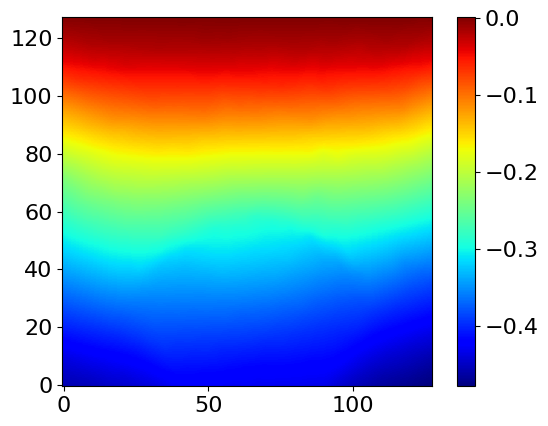

In [169]:
plt.imshow(disp, cmap='jet'); plt.gca().invert_yaxis(); plt.colorbar()

In [170]:
disp.shape

TensorShape([128, 128, 1])

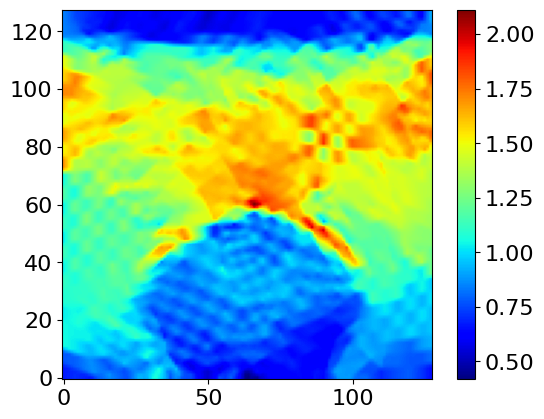

In [225]:
strain = np.gradient(disp, axis=0)
strain = strain*100/0.3
plt.imshow(strain, cmap='jet'); plt.gca().invert_yaxis(); plt.colorbar()

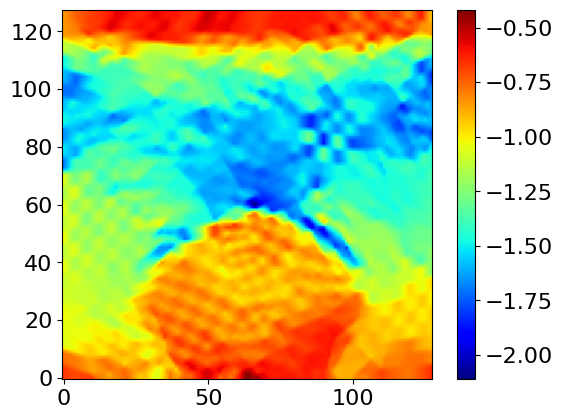

In [226]:
strain = np.gradient(-disp, axis=0)
strain = strain*100/0.3
plt.imshow(strain, cmap='jet'); plt.gca().invert_yaxis(); plt.colorbar()

### Clinical predictions

In [649]:
results_plots_folder_name = 'new_clinical_6_highres'

In [650]:
a_results_for_paper_dir = 'a_results_for_paper/' + results_plots_folder_name
a_results_for_paper_dir

'a_results_for_paper/new_clinical_6_highres'

In [651]:
os.mkdir(a_results_for_paper_dir) if not os.path.isdir(a_results_for_paper_dir) else None
# folders = [str(i) for i in range(2,82)]
# for folder in folders:
#     if(not os.path.isdir(f'{a_results_for_paper_dir}/{folder}')):
#         os.mkdir(f'{a_results_for_paper_dir}/{folder}')

In [652]:
def calculate_cnr(st, sdt, sp, sdp):
    cnr = 2*((st-sp)**2)/(sdt**2+sdp**2)
    return cnr

In [653]:
def process_phantom_recon(recon_image):
    img_mike = recon_image
    phantom_image_mod = load2(img_mike,size=(128,128))
    phantom_image_mod1 = tf.image.rot90(phantom_image_mod,3)
    phantom_image_mod2 = tf.image.flip_left_right(phantom_image_mod1)
    removed = remove_zero_pad(phantom_image_mod2)
    phantom_image_mod2 = tf.image.resize(removed, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
    return phantom_image_mod2

In [654]:
def threshold_mask(nn_mod):
    val = filters.threshold_otsu(nn_mod)
    mean_of_background = nn_mod[nn_mod < val].mean()
    print('Bg:',mean_of_background)
    mean_of_foreground = nn_mod[nn_mod > val].mean()
    print('Fg:',mean_of_foreground)
    contrast=mean_of_foreground/mean_of_background
    print('contrast =',contrast)
    # return mean_of_background, val, contrast

    std_of_background = nn_mod[nn_mod < val].std()
    std_of_foreground = nn_mod[nn_mod > val].std()
    cnr = calculate_cnr(mean_of_foreground, std_of_foreground, mean_of_background, std_of_background)
    return mean_of_background, val, contrast, cnr

In [655]:
def scale_contrast(nn_mod1):
    nn_mod = nn_mod1.numpy()
    # nn_mod = np.log(nn_mod)
    mean_of_background,val,c, cnr = threshold_mask(nn_mod)
    nn_mod_scaled = nn_mod*1.0/mean_of_background
    mean_of_background_scaled,val,c, cnr = threshold_mask(nn_mod_scaled)
    return nn_mod_scaled, mean_of_background_scaled, val, c, cnr

In [656]:
plt.tight_layout()
def plot_images_4(disp, mod, mike_mod,contrast_nn,contrast_mike, save='off',map_color='gray'):
    strain = np.gradient(disp, axis=0)
    # strain = normalize(strain)
    
    display_list = [disp,strain, mod, mike_mod]
    # mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    # mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Displacement', 'Strain', f'NN Mod, Contrast={contrast_nn:.3f}', f'ITR Mod, Constrast {contrast_mike:.3f}'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i]) #, fontsize=)
        if i==2:
            plt.imshow(display_list[i], cmap=map_color)#, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1))
            plt.gca().invert_yaxis()
            # plt.clim(0,5)
            plt.colorbar(location='bottom',pad=0.1)

            # # Create a second y-axis
            # ax2 = plt.gca().twinx()
            
            # # Example: Overlaying a line plot on the secondary y-axis
            # x = np.linspace(0, 128*3.78/128, 8)
            # y = np.linspace(0, 128*3.78/128, 8)
            # # ax2.plot(x, y, 'r-', label='Additional Data')
            # ax2.set_ylabel('Additional Y-axis', color='r')
            # ax2.set_xlabel('Additional Y-axis', color='r')
            # ax2.tick_params('y', colors='r')
            # ax2.tick_params('x', colors='r')
            
            # # Show colorbar
            # # plt.colorbar(location='bottom', pad=0.1)
            # # plt.show()
    
        elif i==3:
            plt.imshow(display_list[i], cmap=map_color)
            plt.colorbar(location='bottom',pad=0.1)
            # plt.clim(0,5)
        elif i==1:
            plt.imshow(display_list[i], cmap='autumn')
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1) #.set_ticks(np.array([-0.010,-0.0075,-0.0025]))            
        else:
            plt.imshow(display_list[i], cmap='jet')
            plt.gca().invert_yaxis()
            plt.colorbar(location='bottom',pad=0.1)
            
        plt.axis('on')
    # plt.savefig(f'data_phantom/phantom_plots/{file_name}.png', bbox_inches='tight')
    plt.show()
    plt.close()

<Figure size 640x480 with 0 Axes>

In [657]:
def plot_thresholdmap(file_name,nn_mod_scaled, val_scaled, c_nn,p_value):
    plt.subplot(1, 1, 1)
    plt.title(f'NN, :{file_name}, C={c_nn:.3f}')
    plt.imshow(nn_mod_scaled < val_scaled, cmap='gray', interpolation='nearest')
    plt.gca().invert_yaxis()
    # plt.colorbar()
    # plt.subplot(1, 2, 2)
    # plt.title(f'ITR, pos: {file_name}')
    # plt.imshow(mike_mod_scaled < val2_scaled, cmap='gray', interpolation='nearest')
    # plt.colorbar()
    # plt.show()
    plt.savefig(f'a_results_for_paper/{results_plots_folder_name}/map_{file_name}_{p_value}.png')   # save the figure to file
    # plt.show()
    plt.close()

In [658]:
def plot_it(counter,disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    
    file_num = counter
    if 1 <= file_num <=5:
        climlim_lower = 1
        climlim = 5
    elif 21 <= file_num <=20:
        climlim_lower = 0
        climlim = 2
    elif 81 <= file_num <=25:
        climlim_lower = 1
        climlim = 4
    elif 101 <= file_num <=45:
        climlim_lower = 0
        climlim = 2

    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig.tight_layout()
    
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement: {file_name}')
    ax1.invert_yaxis()
    fig.colorbar(im1,orientation='horizontal',fraction=0.046, pad=0.09)

    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain')
    ax11.invert_yaxis()
    # ax11.set_yticks([])
    fig.colorbar(im11,orientation='horizontal',fraction=0.046, pad=0.09)

    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Modulus, Contrast={c_nn:.3f}')
    im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])
    fig.colorbar(im2,orientation='horizontal',fraction=0.046, pad=0.09)

    im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # ax.invert_yaxis()
    # ax3.set_xlabel('pixel')
    # ax3.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax3.title.set_text(f'DL Prediction')
    # im3.set_clim(0, climlim)
    ax3.invert_yaxis()
    ax3.set_yticks([])
    fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)

    fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}.png')   # save the figure to file
    plt.close(fig) 

In [659]:
# phantom_images_path = 'data_phantom/apples/sim/disp/*Inclusion10*.raw'
# phantom_images_path = 'data_phantom/apples/phantom_reg12_10k/disp/*.raw'
# phantom_images_path = 'data_phantom/ExpData_7_27_2021/*/uy*.raw'
# phantom_images_path = 'data_phantom/apples/phantom_rick-strain_after1-windowstudy/*_x.raw'
# phantom_images_path = f'data_phantom/apples/phantom_rick-strain_after1-1e-4/*_x.raw'
# phantom_images_path = f'data_phantom/apples/patient/disp/*_x.raw'
phantom_images_path = f'data_phantom/apples/clin/*_x.raw'

In [660]:
# recon_image_path = 'data_phantom/apples/sim/itr_mod/Inclusion10*_mod.raw'
# recon_image_path = 'data_phantom/apples/phantom_legendary/itr_mod/*_mod.raw'
recon_image_path = phantom_images_path

In [661]:
phantom_images = glob.glob(phantom_images_path)
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
phantom_images.sort()
len(phantom_images)

4

In [662]:
# phantom_images

In [663]:
recon_images = glob.glob(recon_image_path)
# phantom_images = glob.glob('alldata/*ValData*/1/*200*.raw')
recon_images.sort()
# recon_images

In [664]:
# phantom_images = glob.glob('data_phantom/apples/liver*.raw')
# phantom_images.sort()
# phantom_images

In [665]:
# i=0

In [666]:
len(phantom_images), len(recon_images)

(4, 4)

In [667]:
phantom_images[0]

'data_phantom/apples/clin/raw_patient1_0_x.raw'

In [668]:
img = phantom_images[2]
file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]
inclusion_number = file_name.split('_')[0][-1]
frame_number = file_name.split('_')[1]
inclusion_number,frame_number

('3', '0')

In [669]:
2864*1.9250e-5/0.3*1000

183.77333333333334

In [670]:
def process_phantom_image(phantom_image, again_normalize = False):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]
    inclusion_number = file_name.split('_')[0]
    frame_number = file_name.split('_')[1]
    # again_norma = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,
    #                21,31,32,33,34,35,36,40]
    # if int(inclusion_number) in again_norma:
    #     again_normalize = True
    phantom_image = load2(img,size=(128,2864)) #2162))
    phantom_image = remove_zero_pad(phantom_image)
    phantom_image1 = tf.image.resize(phantom_image,(128,184), method = 'bicubic', preserve_aspect_ratio=False)
    
    phantom_image1_p1_un = phantom_image1[:,0:128]
    phantom_image1_p2_un = phantom_image1[:,0+20:128+20]
    phantom_image1_p3_un = phantom_image1[:,0+40:128+40]
    phantom_image1_p4_un = phantom_image1[:,0+60-4:128+60-4]

    phantom_image1_p1 = normalize(phantom_image1_p1_un)
    phantom_image1_p2 = normalize(phantom_image1_p2_un)
    phantom_image1_p3 = normalize(phantom_image1_p3_un)
    phantom_image1_p4 = normalize(phantom_image1_p4_un)

    if again_normalize == True:
        phantom_image1_p1 = normalize2(phantom_image1_p1)
        phantom_image1_p2 = normalize2(phantom_image1_p2)
        phantom_image1_p3 = normalize2(phantom_image1_p3)
        phantom_image1_p4 = normalize2(phantom_image1_p4)
        
    phantom_image4_p1 = tf.image.rot90(phantom_image1_p1,1)
    phantom_image4_p2 = tf.image.rot90(phantom_image1_p2,1)
    phantom_image4_p3 = tf.image.rot90(phantom_image1_p3,1)
    phantom_image4_p4 = tf.image.rot90(phantom_image1_p4,1)

    mod_image_p1 = generator(phantom_image4_p1[tf.newaxis, ...], training=False)
    mod_image_p2 = generator(phantom_image4_p2[tf.newaxis, ...], training=False)
    mod_image_p3 = generator(phantom_image4_p3[tf.newaxis, ...], training=False)
    mod_image_p4 = generator(phantom_image4_p4[tf.newaxis, ...], training=False)

    phantom_image4_p1_un = tf.image.rot90(phantom_image1_p1_un,1)
    phantom_image4_p2_un = tf.image.rot90(phantom_image1_p2_un,1)
    phantom_image4_p3_un = tf.image.rot90(phantom_image1_p3_un,1)
    phantom_image4_p4_un = tf.image.rot90(phantom_image1_p4_un,1)

    phantom_image4 = []
    phantom_image4.append(phantom_image4_p1_un)
    phantom_image4.append(phantom_image4_p2_un)
    phantom_image4.append(phantom_image4_p3_un)
    phantom_image4.append(phantom_image4_p4_un)
    
    mod_image =[]
    mod_image.append(mod_image_p1)
    mod_image.append(mod_image_p2)
    mod_image.append(mod_image_p3)
    mod_image.append(mod_image_p4)
    
    return phantom_image4, mod_image, file_name

In [671]:
def process_phantom_image_clin(phantom_image, again_normalize = False):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]
    patient_number = file_name.split('_')[0][-1]
    frame_number = file_name.split('_')[1]

    if patient_number == '1':
        img_size_x = 508
        img_size_y = 2596 #1964
        R1=1;R2=1964;R3=201;R4=2164;R5=401;R6=2364;R7=633;R8=2596;
    elif patient_number == '2':
        img_size_x = 360
        img_size_y = 3116 #1965
        R1=1;R2=1965;R3=401;R4=2365;R5=801;R6=2765;R7=1152;R8=3116;
    elif patient_number == '3':
        img_size_x = 256
        img_size_y = 2648 #1891
        R1=1;R2=1891;R3=251;R4=2141;R5=501;R6=2391;R7=751;R8=2641;
    elif patient_number == '4':
        img_size_x = 360
        img_size_y = 2076 #1965
        R1=1;R2=1965;R3=112;R4=2076;R5=112;R6=2076;R7=112;R8=2076;
        again_normalize = True
        
    phantom_image = load2(img,size=(img_size_x,img_size_y)) #2162))
    phantom_image = remove_zero_pad(phantom_image)
    
    phantom_image1 = tf.image.resize(phantom_image,(img_size_x,img_size_y), method = 'bicubic', preserve_aspect_ratio=False)
    
    phantom_image1_p1_un = phantom_image1[:,R1:R2]
    phantom_image1_p1_un = tf.image.resize(phantom_image1_p1_un,(128,128), method = 'bicubic', preserve_aspect_ratio=False)
    phantom_image1_p2_un = phantom_image1[:,R3:R4]
    phantom_image1_p2_un = tf.image.resize(phantom_image1_p2_un,(128,128), method = 'bicubic', preserve_aspect_ratio=False)
    phantom_image1_p3_un = phantom_image1[:,R5:R6]
    phantom_image1_p3_un = tf.image.resize(phantom_image1_p3_un,(128,128), method = 'bicubic', preserve_aspect_ratio=False)    
    phantom_image1_p4_un = phantom_image1[:,R7:R8]
    phantom_image1_p4_un = tf.image.resize(phantom_image1_p4_un,(128,128), method = 'bicubic', preserve_aspect_ratio=False)

    phantom_image1_p1 = normalize(phantom_image1_p1_un)
    phantom_image1_p2 = normalize(phantom_image1_p2_un)
    phantom_image1_p3 = normalize(phantom_image1_p3_un)
    phantom_image1_p4 = normalize(phantom_image1_p4_un)
    
    if again_normalize == True:
        phantom_image1_p1 = normalize2(phantom_image1_p1)
        phantom_image1_p2 = normalize2(phantom_image1_p2)
        phantom_image1_p3 = normalize2(phantom_image1_p3)
        phantom_image1_p4 = normalize2(phantom_image1_p4)
        
    phantom_image4_p1 = tf.image.rot90(phantom_image1_p1,1)
    phantom_image4_p2 = tf.image.rot90(phantom_image1_p2,1)
    phantom_image4_p3 = tf.image.rot90(phantom_image1_p3,1)
    phantom_image4_p4 = tf.image.rot90(phantom_image1_p4,1)

    mod_image_p1 = generator(phantom_image4_p1[tf.newaxis, ...], training=False)
    mod_image_p2 = generator(phantom_image4_p2[tf.newaxis, ...], training=False)
    mod_image_p3 = generator(phantom_image4_p3[tf.newaxis, ...], training=False)
    mod_image_p4 = generator(phantom_image4_p4[tf.newaxis, ...], training=False)

    phantom_image4_p1_un = tf.image.rot90(phantom_image1_p1_un,1)
    phantom_image4_p2_un = tf.image.rot90(phantom_image1_p2_un,1)
    phantom_image4_p3_un = tf.image.rot90(phantom_image1_p3_un,1)
    phantom_image4_p4_un = tf.image.rot90(phantom_image1_p4_un,1)

    phantom_image4 = []
    phantom_image4.append(phantom_image4_p1_un)
    phantom_image4.append(phantom_image4_p2_un)
    phantom_image4.append(phantom_image4_p3_un)
    phantom_image4.append(phantom_image4_p4_un)
    
    mod_image =[]
    mod_image.append(mod_image_p1)
    mod_image.append(mod_image_p2)
    mod_image.append(mod_image_p3)
    mod_image.append(mod_image_p4)
    
    return phantom_image4, mod_image, file_name

    # phantom_image = load2(img,size=(128,2864)) #2162))
    # phantom_image = remove_zero_pad(phantom_image)
    # phantom_image1 = tf.image.resize(phantom_image,(128,184), method = 'bicubic', preserve_aspect_ratio=False)
    
    # phantom_image1_p1_un = phantom_image1[:,0:128]
    # phantom_image1_p2_un = phantom_image1[:,0+20:128+20]
    # phantom_image1_p3_un = phantom_image1[:,0+40:128+40]
    # phantom_image1_p4_un = phantom_image1[:,0+60-4:128+60-4]

    # phantom_image1_p1 = normalize(phantom_image1_p1_un)
    # phantom_image1_p2 = normalize(phantom_image1_p2_un)
    # phantom_image1_p3 = normalize(phantom_image1_p3_un)
    # phantom_image1_p4 = normalize(phantom_image1_p4_un)

    # if again_normalize == True:
    #     phantom_image1_p1 = normalize2(phantom_image1_p1)
    #     phantom_image1_p2 = normalize2(phantom_image1_p2)
    #     phantom_image1_p3 = normalize2(phantom_image1_p3)
    #     phantom_image1_p4 = normalize2(phantom_image1_p4)
        
    # phantom_image4_p1 = tf.image.rot90(phantom_image1_p1,1)
    # phantom_image4_p2 = tf.image.rot90(phantom_image1_p2,1)
    # phantom_image4_p3 = tf.image.rot90(phantom_image1_p3,1)
    # phantom_image4_p4 = tf.image.rot90(phantom_image1_p4,1)

    # mod_image_p1 = generator(phantom_image4_p1[tf.newaxis, ...], training=False)
    # mod_image_p2 = generator(phantom_image4_p2[tf.newaxis, ...], training=False)
    # mod_image_p3 = generator(phantom_image4_p3[tf.newaxis, ...], training=False)
    # mod_image_p4 = generator(phantom_image4_p4[tf.newaxis, ...], training=False)

    phantom_image4_p1_un = tf.image.rot90(phantom_image1_p1_un,1)
    phantom_image4_p2_un = tf.image.rot90(phantom_image1_p2_un,1)
    phantom_image4_p3_un = tf.image.rot90(phantom_image1_p3_un,1)
    phantom_image4_p4_un = tf.image.rot90(phantom_image1_p4_un,1)

    phantom_image4 = []
    phantom_image4.append(phantom_image4_p1_un)
    phantom_image4.append(phantom_image4_p2_un)
    phantom_image4.append(phantom_image4_p3_un)
    phantom_image4.append(phantom_image4_p4_un)
    
    mod_image =[]
    mod_image.append(mod_image_p1)
    mod_image.append(mod_image_p2)
    mod_image.append(mod_image_p3)
    mod_image.append(mod_image_p4)

In [672]:
from matplotlib import colors

In [673]:
np.linspace(128, 0, 5)

array([128.,  96.,  64.,  32.,   0.])

In [674]:
128*37.8/508

9.524409448818897

In [736]:
def plot_it(counter, p_value, disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    inclusion_number = file_name.split('_')[0][-1]
    frame_number = file_name.split('_')[1]
    
    print('inclusion_number',inclusion_number)
    print('frame_number',frame_number)
    print('window',p_value)

    if p_value == 1:
        window_offset = 0.0
        cm_position = 0.0
        cm_points = [x for x in range(3,-1,-1)]
        dx_dx = 0.378 #128*37.8/508
        climlim_s1 = 0
        climlim_s2 = 2
    elif p_value == 2:
        window_offset = 0.58*1
        cm_position = 1.0
        cm_points = [x for x in range(4,0,-1)]
        dx_dx = 0.378 #128*37.8/360
    elif p_value == 3:    
        window_offset = 0.58*2
        cm_position = 2.0
        cm_points = [x for x in range(4,1,-1)]
        dx_dx = 0.378 # 128*37.8/256
    elif p_value == 4:
        window_offset = 0.58*3
        cm_position = 2.0
        cm_points = [x for x in range(5,1,-1)]
        dx_dx = 0.378 #128*37.8/360
    else:
        climlim_s1 = 0
        climlim_s2 = 2
        print('invalid window')
        
    climlim_s1 = 0
    climlim_s2 = 2

    climlim_lower = 0
    climlim = 5
    
    disp = -disp*1000 #converting m into mm
    
    # strain = np.gradient(disp, 30.0, 1540/40e6/2*1000)
    # strain = normalize(strain)
    strain = np.gradient(disp, axis=0)
    strain = strain*100/(dx_dx)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    original_range = (0, 128)
    new_range = (0, 3.8)
    def convert_to_original(new_value, original_range, new_range):
        return (new_value / new_range[1]) * original_range[1]

    original_range_y = (128, 0)
    new_range_y = (0+window_offset, 3.8+window_offset)

    pixel_range = (128, 0)  # Pixel range from 128 to 0
    cm_range = (0.0+window_offset, 3.8+window_offset) # cm range from 0.58 to 4.38
    scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
    # cm_position = 1.0
    pixel_position = (cm_position - cm_range[0]) * scale_factor
    pixel_position = pixel_range[0] - pixel_position

    def pix_pos(cm_position):
        scale_factor = (pixel_range[0] - pixel_range[1]) / (cm_range[1] - cm_range[0])
        pixel_position = (cm_position - cm_range[0]) * scale_factor
        pixel_position = pixel_range[0] - pixel_position
        return pixel_position
        
    def convert_to_original_y(new_value, original_range_y, new_range_y):
        return (new_value / new_range_y[1]) * original_range[1]
        
    # fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig, (ax1, ax11, ax2) = plt.subplots(1,3, figsize=(15, 8))
    fig.tight_layout(pad=2.5)
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement (mm)')
    ax1.invert_yaxis()

    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # ax1.set_xticks(new_tick_locations)
    # scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax1.set_xticklabels(scaled_tick_labels)

    new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
    ax1.set_xticks(new_tick_locations)
    scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax1.set_xticklabels(scaled_tick_labels)

    

    # new_tick_locations = [convert_to_original_y(val, original_range_y, new_range_y) for val in range(3,-1,-1)] #np.linspace(128, 0, 5)
    new_tick_locations = [pix_pos(x) for x in cm_points][::-1] #np.linspace(128, 0, 5)
    print('new_tick_locations',new_tick_locations)
    # offset = pixel_position-new_tick_locations[0]
    # new_tick_locations = [val+offset for val in new_tick_locations] #np.linspace(0, 128, 5)
    # print('new_tick_locations',new_tick_locations)
    ax1.set_yticks(new_tick_locations)
    scaled_tick_labels = [f'{val:.0f}' for val in range(cm_points[-1],cm_points[0]+1)] #["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    ax1.set_yticklabels(scaled_tick_labels)
    ax1.set_ylabel('Depth (cm)')
    ax1.set_xlabel('Lateral Position (cm)')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # 
    # h1 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h1.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    
    im1.set_clim(-0.65,0.0)
    
    cbar = fig.colorbar(im1,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    # cbar.set_ticks([-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0])
    
    # fig.colorbar(im1,orientation='vertical',fraction=0.046) #,fraction=0.046, pad=0.09)

    ######################################################## Strain
    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain (%)')
    ax11.invert_yaxis()

    # new_tick_locations =  np.linspace(0, 128, 5)
    # ax11.set_xticks(new_tick_locations)
    # scaled_tick_labels = ["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax11.set_xticklabels(scaled_tick_labels)
    # new_tick_locations = np.linspace(128, 0, 5)
    # ax11.set_yticks(new_tick_locations)
    # scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    # ax11.set_yticklabels(scaled_tick_labels)
    # ax2.get_yaxis().set_ticks([])
    # ax11.set_xlabel('(cm)')
    im11.set_clim(0,1.5)
    
    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # ax11.set_xticks(new_tick_locations)
    # scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax11.set_xticklabels(scaled_tick_labels)

    new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
    ax11.set_xticks(new_tick_locations)
    scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax11.set_xticklabels(scaled_tick_labels)


    ax11.set_xlabel('Lateral Position (cm)')
    
    ax11.get_yaxis().set_ticks([])
        
    # im11.set_clim(0.0,2.75)
    # im11.set_clim(climlim_s1,climlim_s2)
    cbar = fig.colorbar(im11,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    cbar.set_ticks([0.0,0.5,1.0,1.5])
    

    # divnorm=colors.TwoSlopeNorm(vmin=0.0, vcenter=1.0, vmax=5.0)
    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm=divnorm) # MidPointLogNorm(vmin=0.01, vmax=5.0, midpoint=1.0) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    # h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Prediction')
    # im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])

    ## New code starts here
    original_range = (0, 128)
    new_range = (0, 3.78)
    # Function to convert from new range to original range
    def convert_to_original(new_value, original_range, new_range):
        return (new_value / new_range[1]) * original_range[1]
    
    # new_tick_locations = [convert_to_original(val, original_range, new_range) for val in range(4)] #np.linspace(0, 128, 5)
    # ax2.set_xticks(new_tick_locations)
    # scaled_tick_labels = [f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    # ax2.set_xticklabels(scaled_tick_labels)
    # ax2.get_xaxis().set_ticks([0,64])
    new_tick_locations = np.array([32., 64., 96.]) #[convert_to_original(val, original_range, new_range)+32 for val in range(3)] #np.linspace(0, 128, 5)
    ax2.set_xticks(new_tick_locations)
    scaled_tick_labels = ['-1','0','+1'] #[f'{val:.0f}' for val in range(4)] #["{:.2f}".format(x / 128 * 3.8) for x in new_tick_locations]
    ax2.set_xticklabels(scaled_tick_labels)

    
    new_tick_locations = np.linspace(128, 0, 5)
    ax2.set_yticks(new_tick_locations)
    scaled_tick_labels = ["{:.2f}".format(3.8 - y / 128 * 3.8 + window_offset) for y in new_tick_locations]
    ax2.set_yticklabels(scaled_tick_labels)
    ax2.get_yaxis().set_ticks([])
    ax2.set_xlabel('Lateral Position (cm)')
    # # ax2.set_ylabel('(cm)')
    # integer_locator = ticker.MaxNLocator(integer=True)
    # ax2.xaxis.set_major_locator(integer_locator)
    im2.set_clim(0,5)
    
    cbar = fig.colorbar(im2,orientation='vertical',fraction=0.0455) #,fraction=0.046, pad=0.09)
    cbar.set_ticks([0,1,2,3,4,5]) #,  labels=['0.01', '1.0', '5.0'])
    
    # cbar = fig.colorbar(cax, orientation='horizontal')
    # cbar.set_ticks(ticks=[-1, 0, 1], labels=['Low', 'Medium', 'High'])
    # im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # # ax.invert_yaxis()
    # # ax3.set_xlabel('pixel')
    # # ax3.set_ylabel('pixel')
    # # yticks = np.arange(0,128)
    # # ax.set_yticklabels(yticks[::-1])  
    # # ax.figure.savefig('1.png')
    # v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    # ax3.title.set_text(f'DL Modulus, Contrast={c_mike:.3f}')
    # # im3.set_clim(0, climlim)
    # ax3.invert_yaxis()
    # ax3.set_yticks([])
    # fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}_{p_value}.png',dpi=300)   # save the figure to file
    plt.show(fig)
    plt.close(fig) 

In [737]:
def plot_it_1(disp, nn_mod, mike_mod, c_nn,c_mike, file_name, size=128, trans_width=3.78):
    # if file_name[0] == '1':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '2':
    #     c_nn = 1/c_nn
    #     c_mike = 1/c_mike
    #     climlim = 2
    # elif file_name[0] == '3':
    #     climlim = 3.5
    # else:
    #     climlim = 5
    print(file_name)
    inclusion_number = file_name.split('_')[0]
    frame_number = file_name.split('_')[1]
    
    print('inclusion_number',inclusion_number)
    print('widow_number',frame_number)

    
    file_num = int(inclusion_number)
    if 1 <= file_num <=5:
        climlim_lower = 1
        climlim = 5
    elif 6 <= file_num <=20:
        climlim_lower = 0
        climlim = 2
    elif 21 <= file_num <=25:
        climlim_lower = 1
        climlim = 4
    elif 26 <= file_num <=45:
        climlim_lower = 0
        climlim = 2

    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig.tight_layout()
    
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text(f'Displacement: {inclusion_number}_p{frame_number}')
    ax1.invert_yaxis()
    fig.colorbar(im1,orientation='horizontal',fraction=0.046, pad=0.09)

    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain')
    ax11.invert_yaxis()
    # ax11.set_yticks([])
    fig.colorbar(im11,orientation='horizontal',fraction=0.046, pad=0.09)

    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Modulus, Contrast={c_nn:.3f}')
    im2.set_clim(climlim_lower,climlim)
    ax2.invert_yaxis()
    # ax2.set_yticks([])
    fig.colorbar(im2,orientation='horizontal',fraction=0.046, pad=0.09)

    im3 = ax3.imshow(mike_mod, aspect='equal',cmap='gray')
    # ax.invert_yaxis()
    # ax3.set_xlabel('pixel')
    # ax3.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax3.title.set_text(f'DL Modulus, Contrast={c_mike:.3f}')
    # im3.set_clim(0, climlim)
    ax3.invert_yaxis()
    ax3.set_yticks([])
    fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)

    # fig.savefig(f'a_results_for_paper/{results_plots_folder_name}/{file_name}.png')   # save the figure to file
    plt.close(fig) 

In [738]:
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], True)
#     for p in range(len(phantom_image4)):
#         plot_it(i+1,p+1,phantom_image4[p], mod_image[p][0],mod_image[p][0],1,1,f_name)
#         # break
#     # break

In [739]:
import pandas as pd
df = pd.DataFrame(columns=['file_name', 'ROI', 'contrast'])

In [740]:
plt.rcParams.update({'font.size': 16})

In [741]:
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], True)
#     for p in range(4): #(len(phantom_image4)):
#         # plot_it(0+1,p+1,phantom_image4[p], mod_image[p][0],mod_image[p][0],1,1,f_name)
#         nn_mod_unscaled = mod_image[p][0]
#         nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn, cnr = scale_contrast(nn_mod_unscaled)
#         print('mean_of_background_scaled_nn',mean_of_background_scaled)
#         print('contrast=',c_nn)
#         plot_it(0+1,p+1,phantom_image4[p], mod_image[p][0],nn_mod_scaled,1,1,f_name)
#         plot_thresholdmap(f_name, nn_mod_scaled, val_nn, c_nn,p+1)
#         df = df._append({'file_name': int(f_name.split('_')[0]), 'ROI': p+1, 'contrast': c_nn, 'cnr':cnr}, ignore_index=True)
#     #     break
#     # break

Bg: 0.998525
Fg: 4.3161483
contrast = 4.322524
Bg: 1.0000001
Fg: 4.3225245
contrast = 4.322524
mean_of_background_scaled_nn 1.0000001
contrast= 4.322524
inclusion_number 1
frame_number 0
window 1
new_tick_locations [128.0, 94.31578947368422, 60.631578947368425, 26.94736842105263]


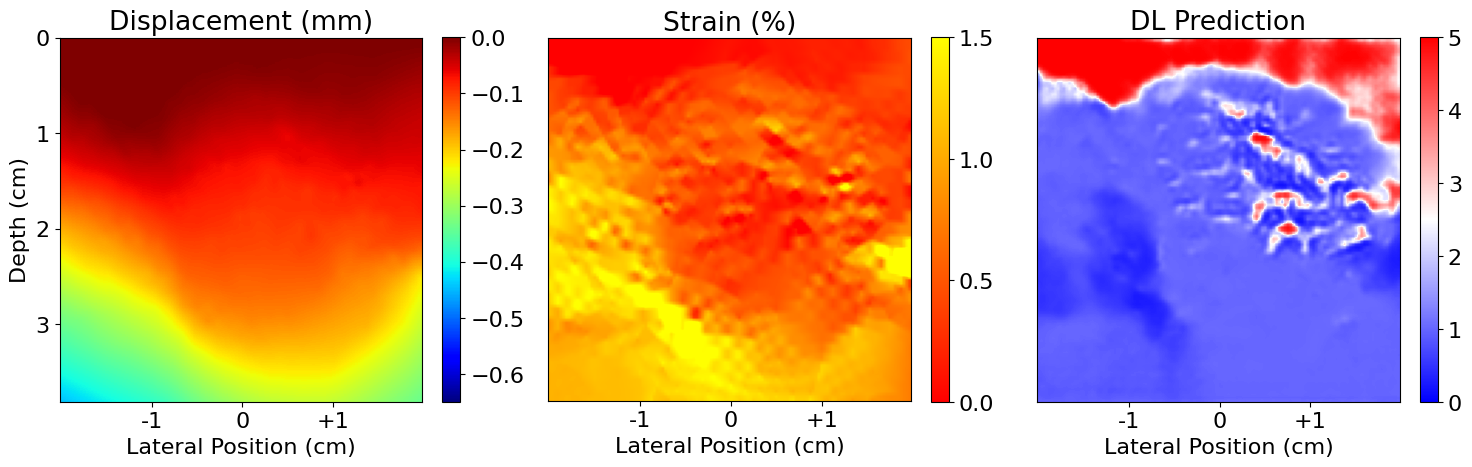

Bg: 1.0907335
Fg: 3.9566207
contrast = 3.627486
Bg: 1.0
Fg: 3.6274862
contrast = 3.6274862
mean_of_background_scaled_nn 1.0
contrast= 3.6274862
inclusion_number 1
frame_number 0
window 2
new_tick_locations [113.85263157894737, 80.16842105263159, 46.48421052631579, 12.800000000000011]


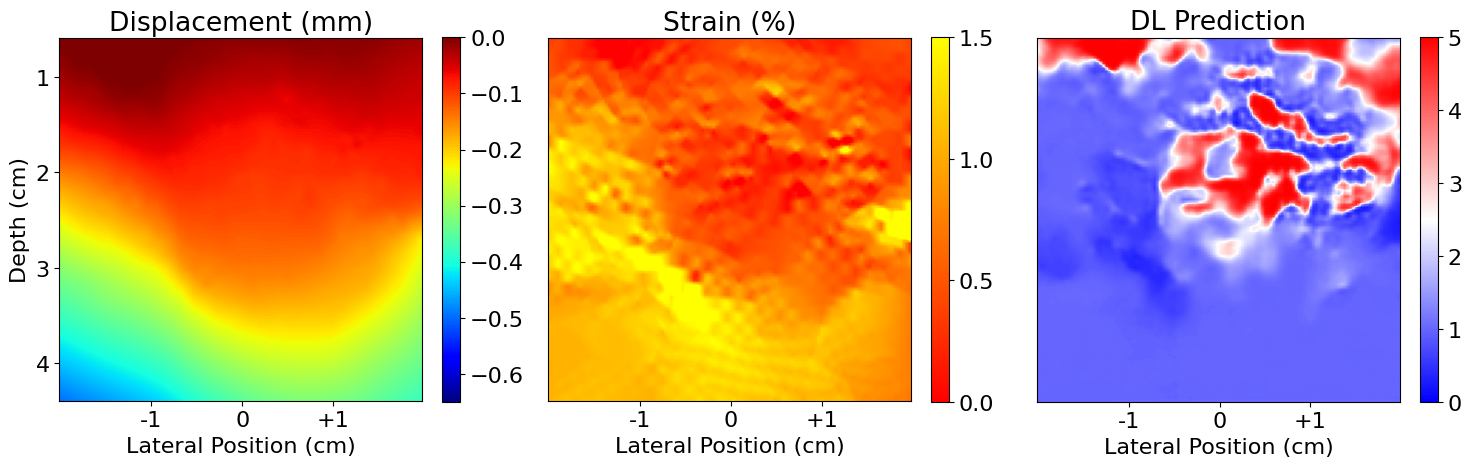

Bg: 1.1305709
Fg: 3.8100543
contrast = 3.3700268
Bg: 1.0
Fg: 3.3700268
contrast = 3.3700268
mean_of_background_scaled_nn 1.0
contrast= 3.3700268
inclusion_number 1
frame_number 0
window 3
new_tick_locations [99.70526315789473, 66.02105263157895, 32.33684210526317]


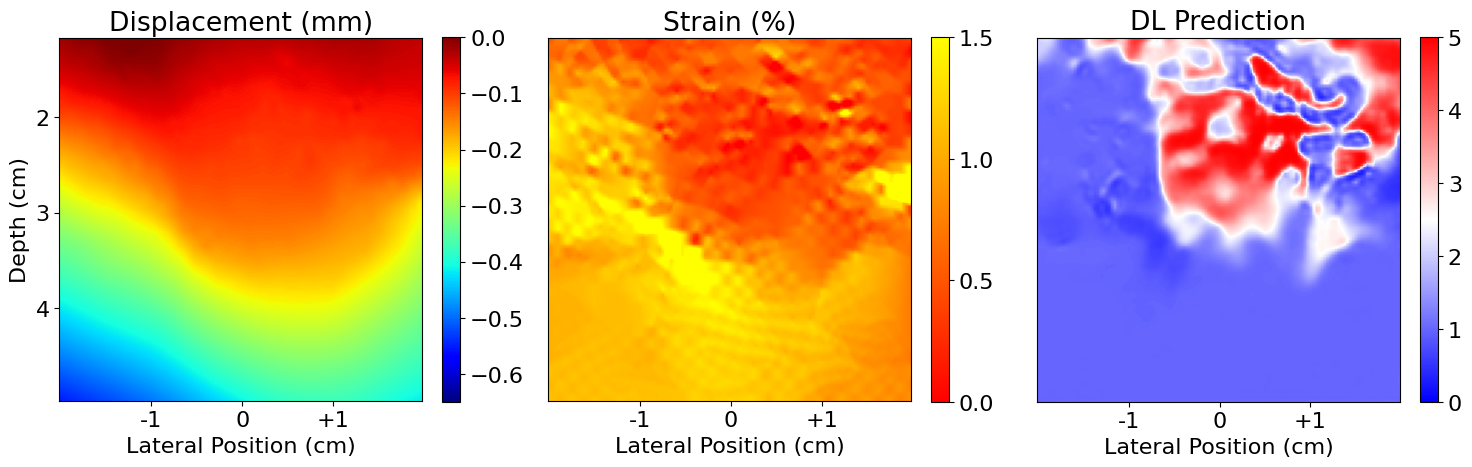

Bg: 1.1035066
Fg: 4.0373273
contrast = 3.6586347
Bg: 1.0
Fg: 3.6586342
contrast = 3.6586342
mean_of_background_scaled_nn 1.0
contrast= 3.6586342
inclusion_number 1
frame_number 0
window 4
new_tick_locations [119.24210526315788, 85.55789473684209, 51.87368421052629, 18.189473684210498]


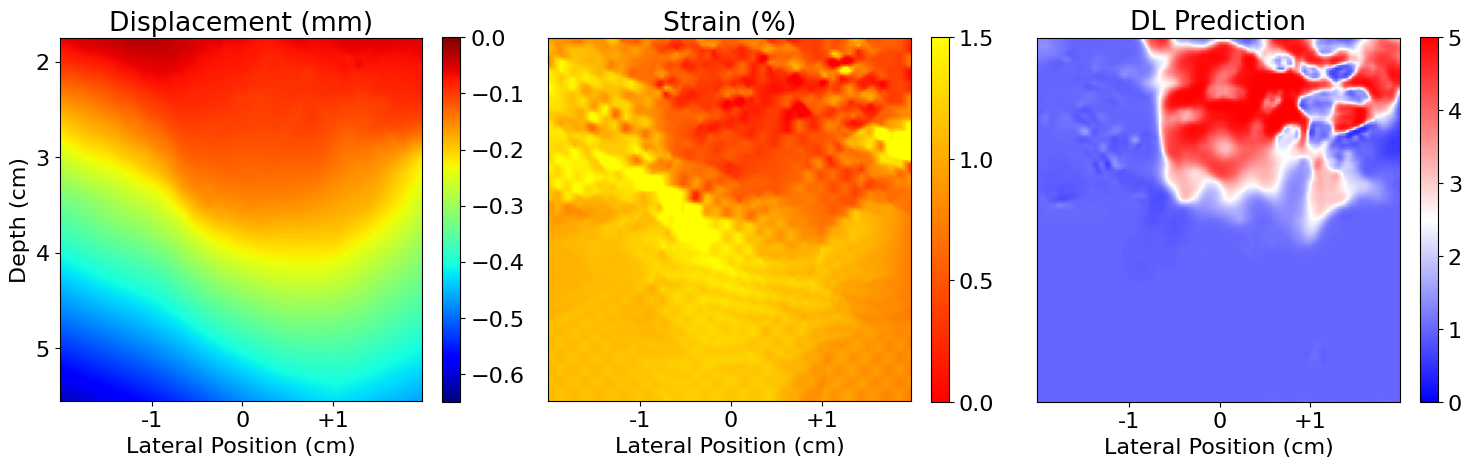

Bg: 0.93153393
Fg: 3.8597543
contrast = 4.1434393
Bg: 1.0
Fg: 4.1434393
contrast = 4.1434393
mean_of_background_scaled_nn 1.0
contrast= 4.1434393
inclusion_number 2
frame_number 0
window 1
new_tick_locations [128.0, 94.31578947368422, 60.631578947368425, 26.94736842105263]


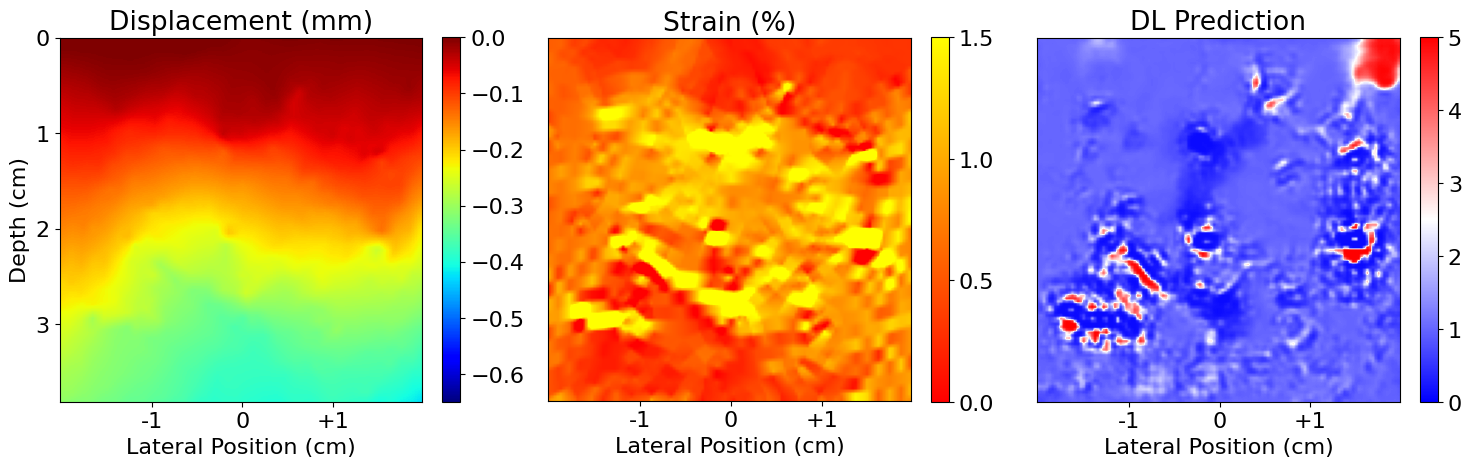

Bg: 1.0143286
Fg: 4.53919
contrast = 4.4750686
Bg: 0.99999994
Fg: 4.475069
contrast = 4.4750695
mean_of_background_scaled_nn 0.99999994
contrast= 4.4750695
inclusion_number 2
frame_number 0
window 2
new_tick_locations [113.85263157894737, 80.16842105263159, 46.48421052631579, 12.800000000000011]


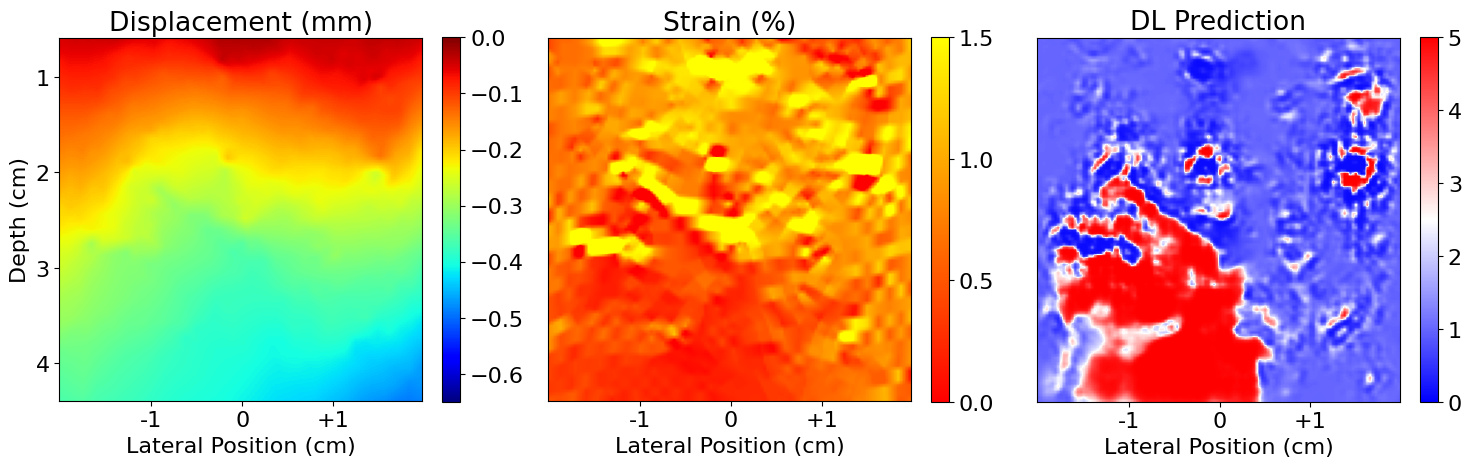

Bg: 1.1019677
Fg: 4.2284307
contrast = 3.837164
Bg: 1.0
Fg: 3.8371649
contrast = 3.8371649
mean_of_background_scaled_nn 1.0
contrast= 3.8371649
inclusion_number 2
frame_number 0
window 3
new_tick_locations [99.70526315789473, 66.02105263157895, 32.33684210526317]


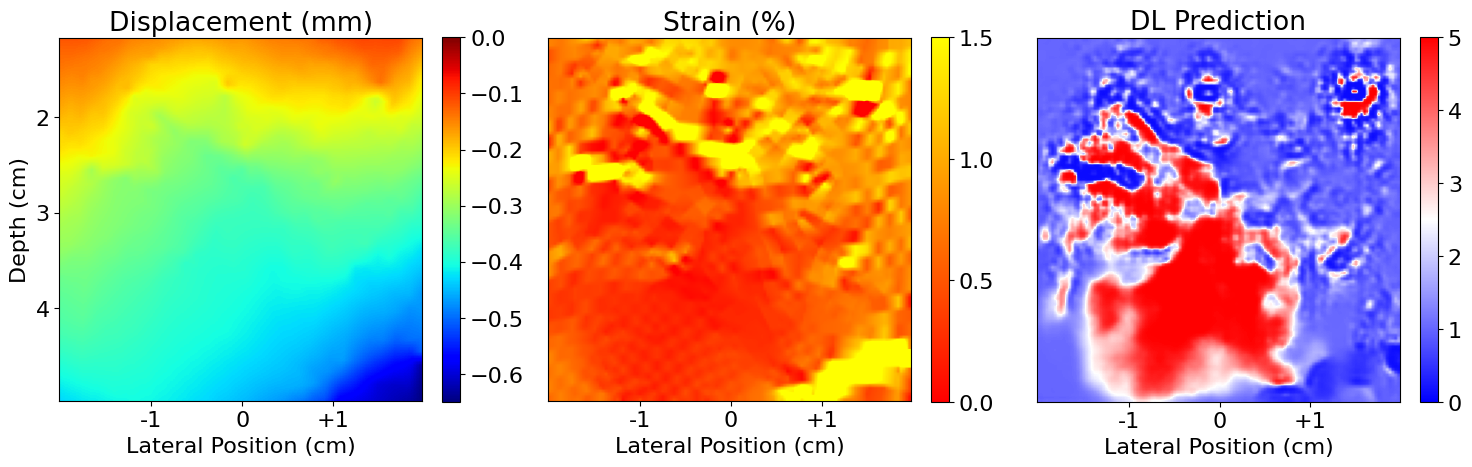

Bg: 1.0642396
Fg: 4.3326097
contrast = 4.0710845
Bg: 1.0000001
Fg: 4.071085
contrast = 4.0710845
mean_of_background_scaled_nn 1.0000001
contrast= 4.0710845
inclusion_number 2
frame_number 0
window 4
new_tick_locations [119.24210526315788, 85.55789473684209, 51.87368421052629, 18.189473684210498]


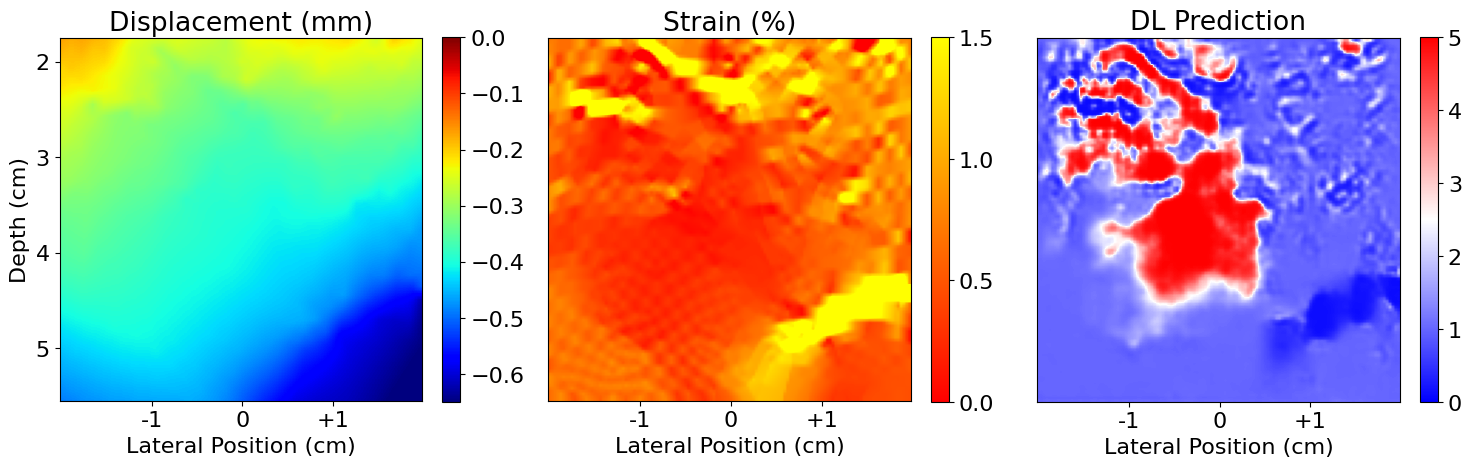

Bg: 0.8277396
Fg: 3.4371622
contrast = 4.152468
Bg: 1.0
Fg: 4.1524677
contrast = 4.1524677
mean_of_background_scaled_nn 1.0
contrast= 4.1524677
inclusion_number 3
frame_number 0
window 1
new_tick_locations [128.0, 94.31578947368422, 60.631578947368425, 26.94736842105263]


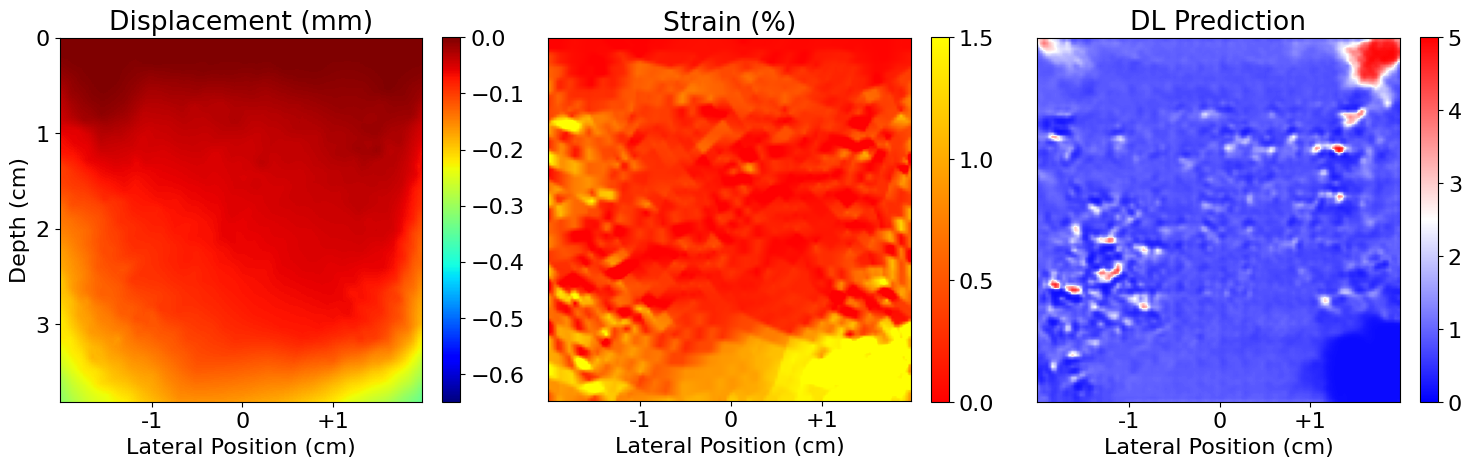

Bg: 0.8428275
Fg: 2.8801184
contrast = 3.4172099
Bg: 1.0
Fg: 3.4172099
contrast = 3.4172099
mean_of_background_scaled_nn 1.0
contrast= 3.4172099
inclusion_number 3
frame_number 0
window 2
new_tick_locations [113.85263157894737, 80.16842105263159, 46.48421052631579, 12.800000000000011]


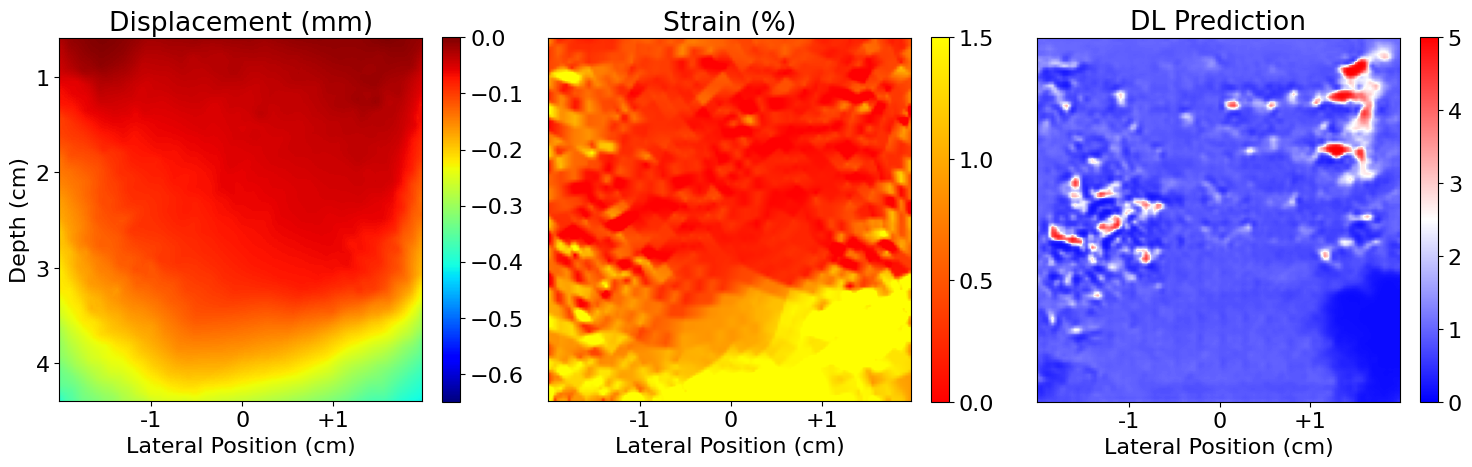

Bg: 0.9450986
Fg: 3.680422
contrast = 3.8942204
Bg: 1.0
Fg: 3.8942204
contrast = 3.8942204
mean_of_background_scaled_nn 1.0
contrast= 3.8942204
inclusion_number 3
frame_number 0
window 3
new_tick_locations [99.70526315789473, 66.02105263157895, 32.33684210526317]


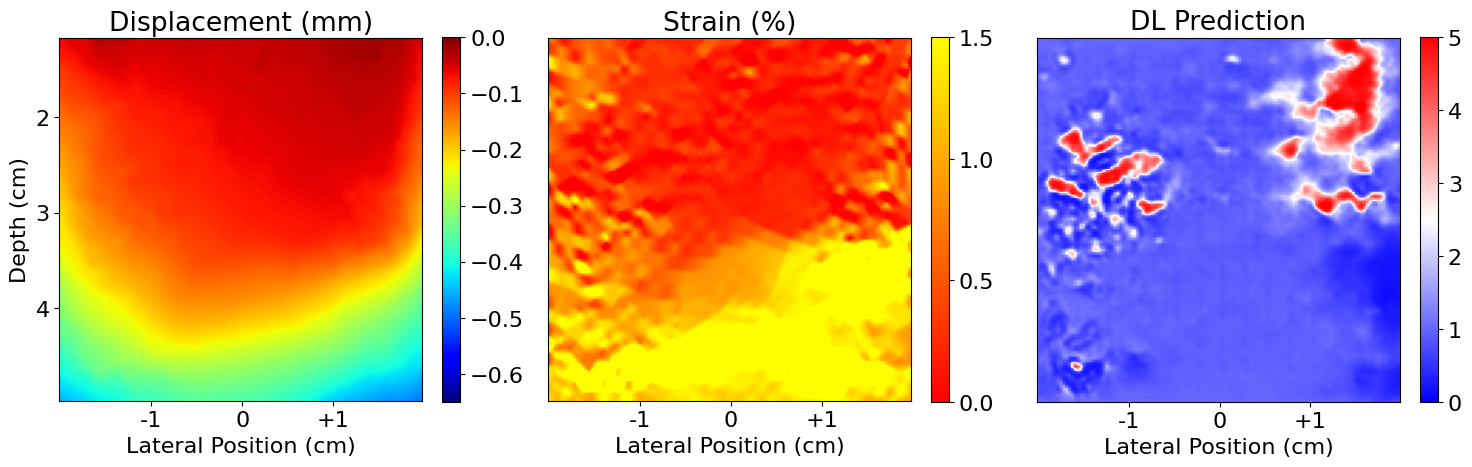

Bg: 0.9998548
Fg: 3.8229918
contrast = 3.8235471
Bg: 1.0
Fg: 3.8235466
contrast = 3.8235466
mean_of_background_scaled_nn 1.0
contrast= 3.8235466
inclusion_number 3
frame_number 0
window 4
new_tick_locations [119.24210526315788, 85.55789473684209, 51.87368421052629, 18.189473684210498]


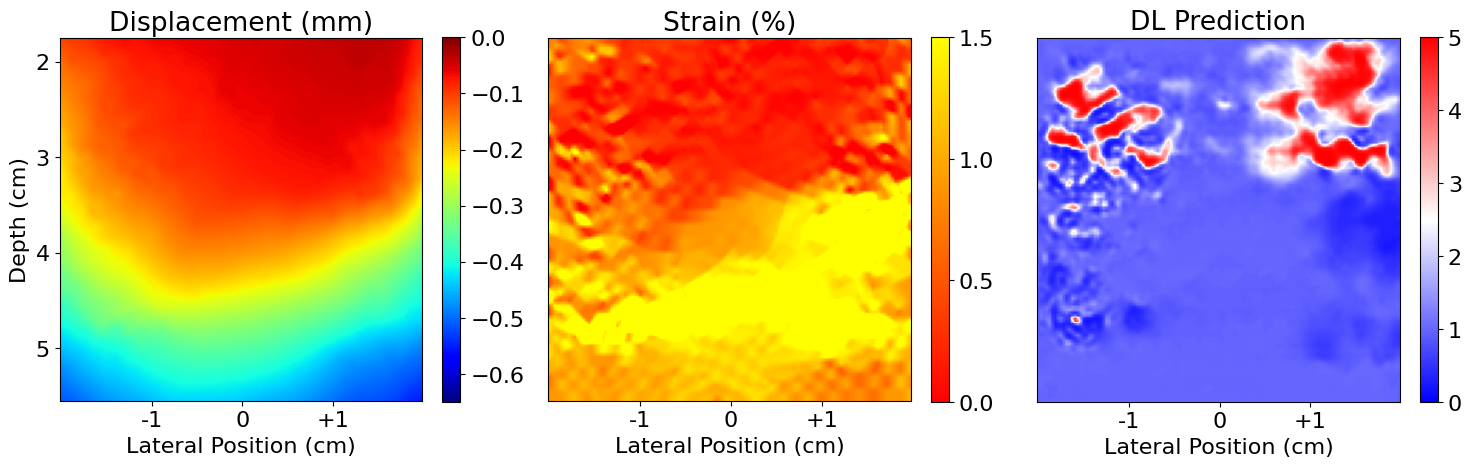

Bg: 0.6968302
Fg: 3.244119
contrast = 4.655537
Bg: 1.0
Fg: 4.6555367
contrast = 4.6555367
mean_of_background_scaled_nn 1.0
contrast= 4.6555367
inclusion_number 4
frame_number 0
window 1
new_tick_locations [128.0, 94.31578947368422, 60.631578947368425, 26.94736842105263]


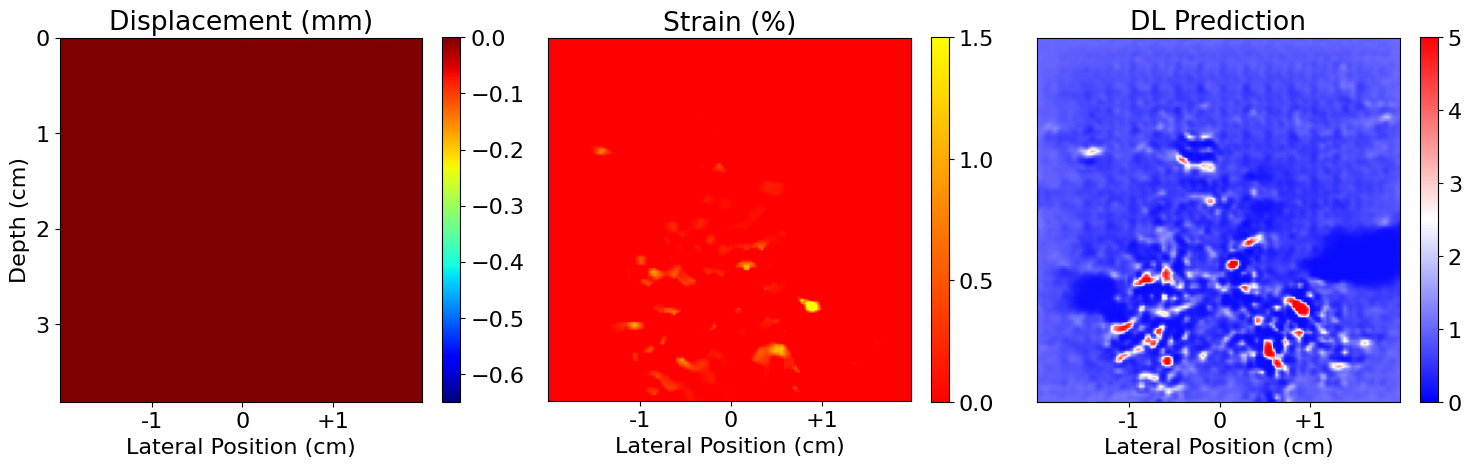

Bg: 0.6384582
Fg: 3.180187
contrast = 4.981042
Bg: 1.0
Fg: 4.981042
contrast = 4.981042
mean_of_background_scaled_nn 1.0
contrast= 4.981042
inclusion_number 4
frame_number 0
window 2
new_tick_locations [113.85263157894737, 80.16842105263159, 46.48421052631579, 12.800000000000011]


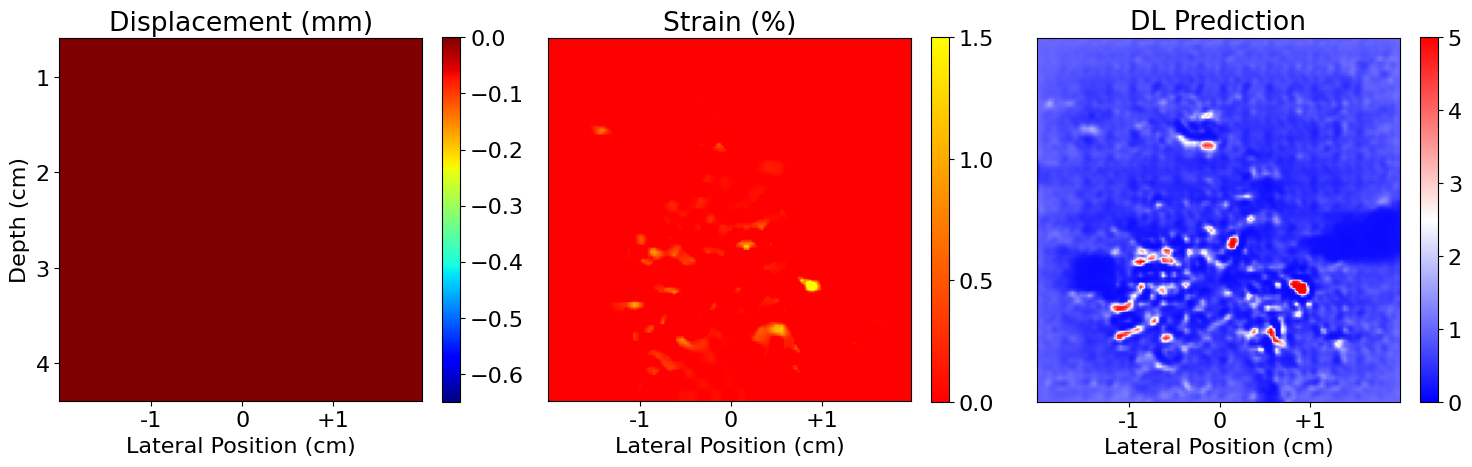

Bg: 0.6384582
Fg: 3.1801872
contrast = 4.9810424
Bg: 1.0
Fg: 4.981042
contrast = 4.981042
mean_of_background_scaled_nn 1.0
contrast= 4.981042
inclusion_number 4
frame_number 0
window 3
new_tick_locations [99.70526315789473, 66.02105263157895, 32.33684210526317]


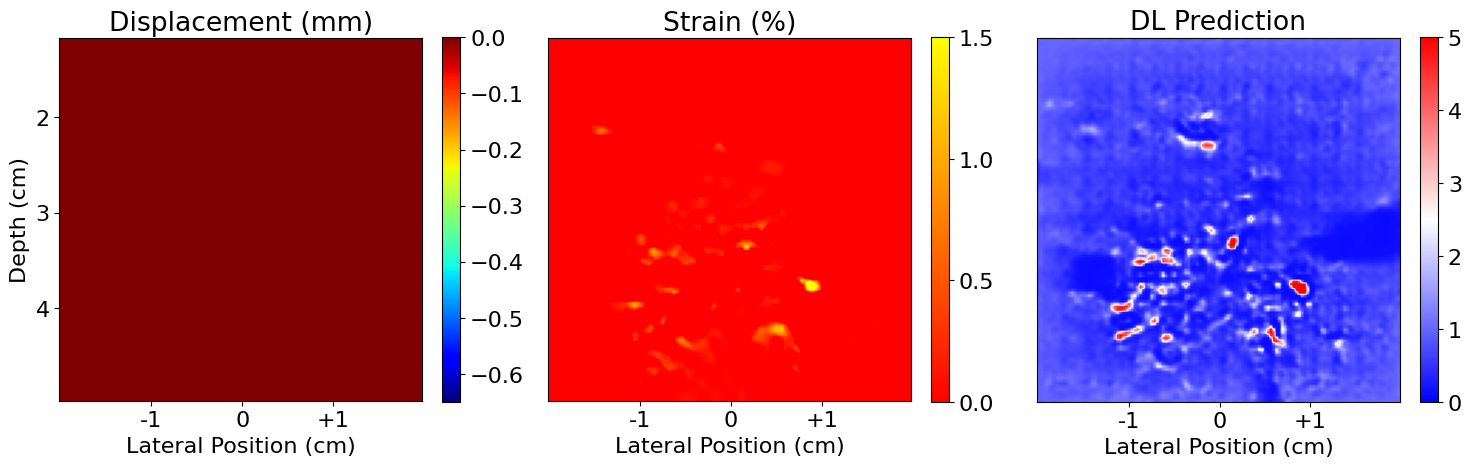

Bg: 0.6384582
Fg: 3.180187
contrast = 4.981042
Bg: 1.0
Fg: 4.981042
contrast = 4.981042
mean_of_background_scaled_nn 1.0
contrast= 4.981042
inclusion_number 4
frame_number 0
window 4
new_tick_locations [119.24210526315788, 85.55789473684209, 51.87368421052629, 18.189473684210498]


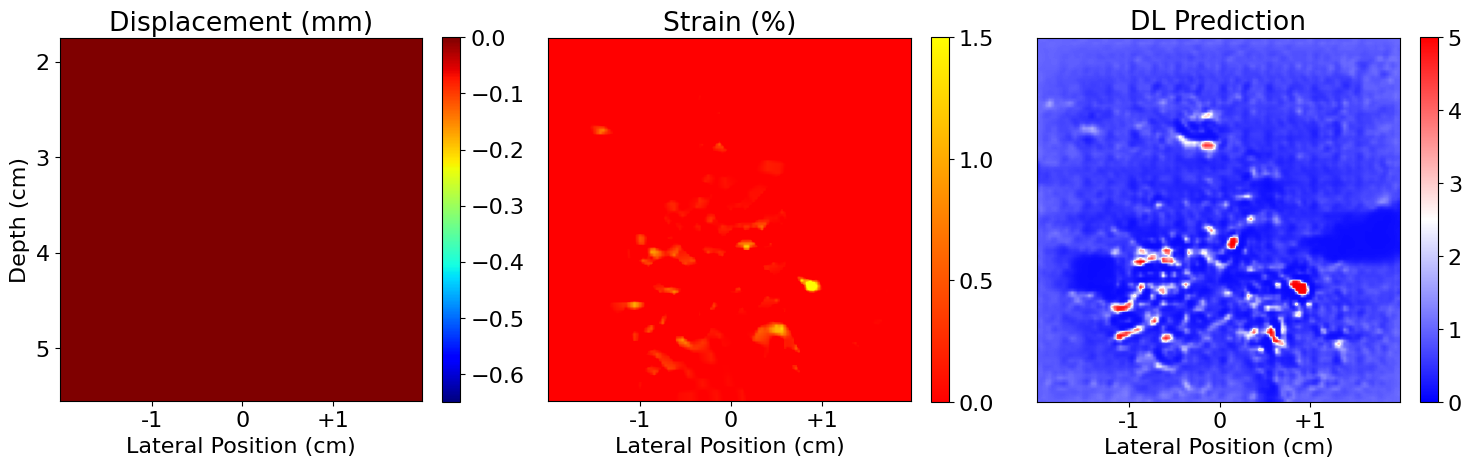

In [742]:
for i in range(len(phantom_images)):
    phantom_image4, mod_image, f_name = process_phantom_image_clin(phantom_images[i], False)
    for p in range(4): #(len(phantom_image4)):
        # plot_it(0+1,p+1,phantom_image4[p], mod_image[p][0],mod_image[p][0],1,1,f_name)
        nn_mod_unscaled = mod_image[p][0]
        nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn, cnr = scale_contrast(nn_mod_unscaled)
        print('mean_of_background_scaled_nn',mean_of_background_scaled)
        print('contrast=',c_nn)
        plot_it(0+1,p+1,phantom_image4[p], mod_image[p][0],nn_mod_unscaled,1,1,f_name)
        plot_thresholdmap(f_name, nn_mod_unscaled, val_nn, c_nn,p+1)
        df = df._append({'file_name': int(f_name.split('_')[0][-1]), 'ROI': p+1, 'contrast': c_nn}, ignore_index=True)
        # break
    # break

In [160]:
508*1964

997712

In [161]:
f_name

'patient4_0'

In [162]:
f_name.split('_')[0][-1]

'4'

In [163]:
f_name

'patient4_0'

In [164]:
df.shape

(16, 3)

In [165]:
df.sort_values(by=['file_name', 'ROI'], ascending=[True, True])

file_name  ROI  contrast
0         1.0  1.0  4.322584
1         1.0  2.0  3.627350
2         1.0  3.0  3.369833
3         1.0  4.0  3.658553
4         2.0  1.0  4.141594
5         2.0  2.0  4.474826
6         2.0  3.0  3.837025
7         2.0  4.0  4.070651
8         3.0  1.0  4.152623
9         3.0  2.0  3.416505
10        3.0  3.0  3.894149
11        3.0  4.0  3.823355
12        4.0  1.0  4.655072
13        4.0  2.0  4.975082
14        4.0  3.0  4.975082
15        4.0  4.0  4.975082

In [166]:
df.to_csv(f'a_results_for_paper/{results_plots_folder_name}/all_contrasts.csv', index=False)

In [297]:
large4 = df[(df['file_name'] >= 1.0) & (df['file_name'] <= 5.0)]
large4.mean().contrast

3.859386169910431

In [298]:
large3 = df[(df['file_name'] >= 6.0) & (df['file_name'] <= 10.0)]
large3.mean().contrast

1.7197214592070806

In [300]:
large2 = df[(df['file_name'] >= 11.0) & (df['file_name'] <= 15.0)]
1/large2.mean().contrast

0.5115793958072947

In [301]:
large1 = df[(df['file_name'] >= 16.0) & (df['file_name'] <= 20.0)]
1/large1.mean().contrast

0.4087990313549182

In [302]:
small4 = df[(df['file_name'] >= 21.0) & (df['file_name'] <= 25.0)]
small4.mean().contrast

2.344967633485794

In [303]:
small3 = df[(df['file_name'] >= 26.0) & (df['file_name'] <= 30.0)]
small3.mean().contrast

1.7412238001823426

In [305]:
small2 = df[(df['file_name'] >= 31.0) & (df['file_name'] <= 35.0)]
1/small2.mean().contrast

0.4783348984531778

In [306]:
small1 = df[(df['file_name'] >= 36.0) & (df['file_name'] <= 40.0)]
1/small1.mean().contrast

0.4060424092706626

In [ ]:
df2 = pd.DataFrame(columns=['Type', 'mean contrast'])

In [114]:
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image_1(phantom_images[i], True)
#     for p in range(len(phantom_image4)):
#         plot_it_1(phantom_image4[p], mod_image[p][0],mod_image[p][0],1,1,f_name)
#         # break
#     # break

10_1
inclusion_number 10
widow_number 1
10_2
inclusion_number 10
widow_number 2
10_3
inclusion_number 10
widow_number 3
10_4
inclusion_number 10
widow_number 4
11_1
inclusion_number 11
widow_number 1
11_2
inclusion_number 11
widow_number 2
11_3
inclusion_number 11
widow_number 3
11_4
inclusion_number 11
widow_number 4
12_1
inclusion_number 12
widow_number 1
12_2
inclusion_number 12
widow_number 2
12_3
inclusion_number 12
widow_number 3
12_4
inclusion_number 12
widow_number 4
13_1
inclusion_number 13
widow_number 1
13_2
inclusion_number 13
widow_number 2
13_3
inclusion_number 13
widow_number 3
13_4
inclusion_number 13
widow_number 4
14_1
inclusion_number 14
widow_number 1
14_2
inclusion_number 14
widow_number 2
14_3
inclusion_number 14
widow_number 3
14_4
inclusion_number 14
widow_number 4
15_1
inclusion_number 15
widow_number 1
15_2
inclusion_number 15
widow_number 2
15_3
inclusion_number 15
widow_number 3
15_4
inclusion_number 15
widow_number 4
16_1
inclusion_number 16
widow_number 1


In [115]:
for i in range(len(phantom_images)):
    phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], True)
    # phantom_image_mod1 = process_phantom_recon(recon_images[i])
    mike_mod1 = mod_image[0]
    nn_mod1 = mod_image[0]
    nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
    print('mean_of_background_scaled_nn',mean_of_background_scaled)
    mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
    print('mean_of_background_scaled_mike',mean_of_background_scaled2)
    # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
    plot_it(i+1,phantom_image4, nn_mod1,nn_mod_scaled,c_nn,c_mike,f_name)
    # plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
    # break

InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 253312 values, but the requested shape has 366592 [Op:Reshape]

In [ ]:
## For legendary data

In [ ]:
def process_phantom_image_legend(phantom_image, again_normalise = False):
    img = phantom_image
    file_name = img.split('_')[-3] + '_' +  img.split('_')[-2]

    file_name = file_name.split('/')[-2]
    print('file_name:',file_name)

    phantom_image = load(img)#,size=(128,128)) #2162))
    # # print('Original phantom size:',phantom_image.shape)
    # phantom_image = remove_zero_pad(phantom_image)
    # # print('Removed zeroes phantom size:',phantom_image.shape)
    # phantom_image1 = tf.image.resize(phantom_image, (128,128), method = 'bicubic', preserve_aspect_ratio=False)
    phantom_image1 = normalize(phantom_image)
    if again_normalise == True:
        phantom_image1 = normalize2(phantom_image1)
    # phantom_image2 = tf.image.rot90(phantom_image1,1)
    # # phantom_image3 = tf.image.flip_left_right(phantom_image2)
    # phantom_image3 = phantom_image2
    # # print('NN input phantom size:',phantom_image3.shape)
    phantom_image4 = phantom_image1
    mod_image = generator(phantom_image4[tf.newaxis, ...], training=False)
    output = np.reshape(mod_image, (128,128))
    file_name2 = f"data_phantom/predictions_raw/patient/phantom1_{file_name}.raw"
    with open(file_name2, 'wb') as fp:     
        output.tofile(fp)
    fp.close()
    return phantom_image1, mod_image, file_name

In [ ]:
# # phantom_legendary
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image_legend(phantom_images[i], False)
#     phantom_image_mod1 = process_phantom_recon(recon_images[i])
#     mike_mod1 = phantom_image_mod1
#     nn_mod1 = mod_image[0]
#     nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
#     print('mean_of_background_scaled_nn',mean_of_background_scaled)
#     mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
#     print('mean_of_background_scaled_mike',mean_of_background_scaled2)
#     # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
#     plot_it(i,phantom_image4, nn_mod1,nn_mod1,c_nn,c_mike,f_name)
#     plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
#     # break

In [ ]:
# for i in range(len(phantom_images)):
#     phantom_image4, mod_image, f_name = process_phantom_image(phantom_images[i], True)
#     phantom_image_mod1 = process_phantom_recon(recon_images[i])
#     mike_mod1 = phantom_image_mod1
#     nn_mod1 = mod_image[0]
#     nn_mod_scaled, mean_of_background_scaled, val_nn, c_nn = scale_contrast(nn_mod1)
#     print('mean_of_background_scaled_nn',mean_of_background_scaled)
#     mike_mod_scaled, mean_of_background_scaled2, val_mike, c_mike = scale_contrast(mike_mod1)
#     print('mean_of_background_scaled_mike',mean_of_background_scaled2)
#     # plot_images_4(phantom_image4, nn_mod_scaled, mike_mod_scaled,c_nn,c_mike, save='off',map_color='bwr' )
#     plot_it(phantom_image4, nn_mod_scaled,mike_mod_scaled,c_nn,c_mike,f_name)
#     plot_thresholdmap(f_name,nn_mod_scaled, val_nn, mike_mod_scaled, val_mike)
#     # break

In [339]:
# plot_it(phantom_image4, nn_mod_scaled,mike_mod_scaled,c_nn,c_mike)

In [340]:
def plot_it(disp, nn_mod, mike_mod, c_nn,c_mike, size=128, trans_width=3.78):
    strain = np.gradient(disp, axis=0)
    strain = normalize(strain)

    def px_to_mm(values):
        return values*trans_width/128

    def mm_to_px(values):
        return values*128/trans_width
    
    fig, (ax1, ax11, ax2, ax3) = plt.subplots(1,4, figsize=(15, 8))
    fig.tight_layout()
    
    im1 = ax1.imshow(disp, aspect='equal',cmap='jet')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax1.title.set_text('Hassan Displacement')
    ax1.invert_yaxis()
    fig.colorbar(im1,orientation='horizontal',fraction=0.046, pad=0.09)

    im11 = ax11.imshow(strain, aspect='equal',cmap='autumn')
    # ax.invert_yaxis()
    # ax1.set_xlabel('pixel')
    # ax1.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    # v2 = ax1.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    # v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # # v2.set_ylabel('cm')
    # v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # # ax.figure.savefig('2.png')
    # h2 = ax1.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    # h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # # h2.set_xlabel('cm')
    # # ax.figure.savefig('3.png')
    ax11.title.set_text('Strain')
    ax11.invert_yaxis()
    # ax11.set_yticks([])
    fig.colorbar(im11,orientation='horizontal',fraction=0.046, pad=0.09)

    im2 = ax2.imshow(nn_mod, aspect='equal',cmap='bwr') #, norm= MidPointLogNorm(vmin=0.01, vmax=5, midpoint=1) )
    # ax.invert_yaxis()
    # ax2.set_xlabel('pixel')
    # ax2.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax2.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax2.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax2.title.set_text(f'DL Modulus, Contrast={c_nn:.3f}')
    im2.set_clim(0,5)
    ax2.invert_yaxis()
    # ax2.set_yticks([])
    fig.colorbar(im2,orientation='horizontal',fraction=0.046, pad=0.09)

    im3 = ax3.imshow(mike_mod, aspect='equal',cmap='bwr')
    # ax.invert_yaxis()
    # ax3.set_xlabel('pixel')
    # ax3.set_ylabel('pixel')
    # yticks = np.arange(0,128)
    # ax.set_yticklabels(yticks[::-1])  
    # ax.figure.savefig('1.png')
    v2 = ax3.secondary_yaxis('right', functions=(px_to_mm, mm_to_px))
    v2.set_yticks(np.linspace(0, size*trans_width/128, 8, endpoint=True))
    # v2.set_ylabel('cm')
    v2.set_yticklabels(np.round(np.linspace(0.00,size*trans_width/128, 8, endpoint=True),2))         # <- Changed
    # ax.figure.savefig('2.png')
    h2 = ax3.secondary_xaxis('top', functions=(px_to_mm, mm_to_px))
    h2.set_xticks(np.round(np.linspace(0, size*trans_width/128, 8, endpoint=True),2))
    # h2.set_xlabel('cm')
    # ax.figure.savefig('3.png')
    ax3.title.set_text(f'ITR Modulus, Contrast={c_mike:.3f}')
    im3.set_clim(0, 5)
    # ax3.invert_yaxis()
    ax3.set_yticks([])
    fig.colorbar(im3,orientation='horizontal',fraction=0.046, pad=0.09)
    fig.savefig('path/to/save/image/to.png')   # save the figure to file
    plt.close(fig) 

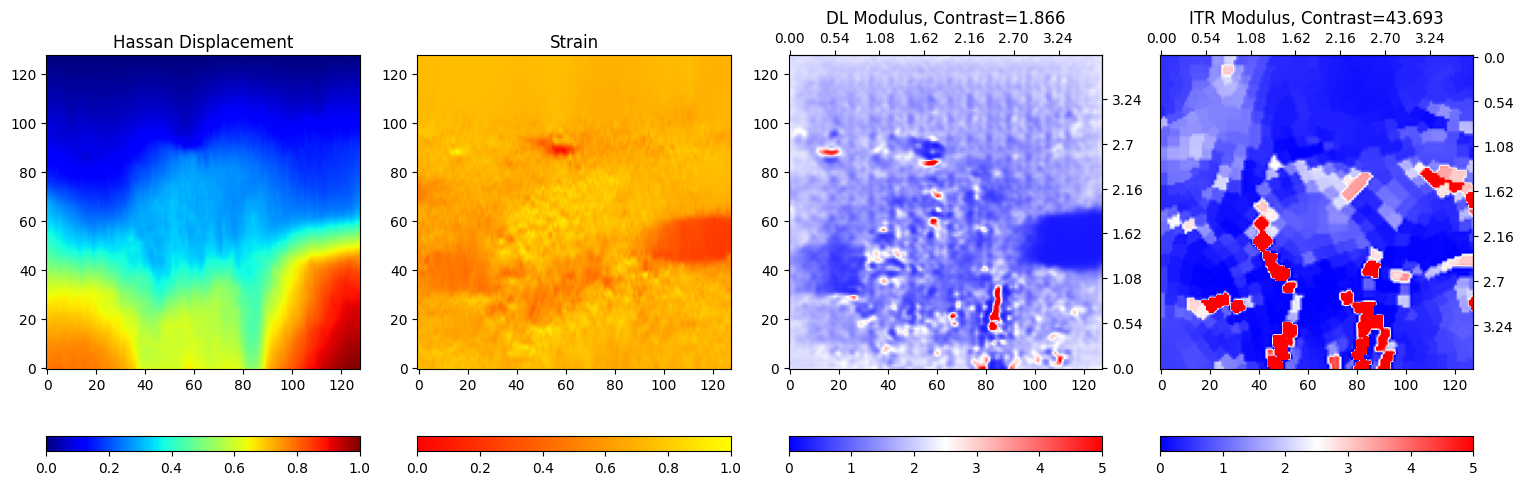

In [341]:
plot_it(phantom_image4, nn_mod_scaled,mike_mod_scaled,c_nn,c_mike)